# Исследование данных медицинской клиники

**Цель исследования**

Необходимо провести анализ изменения цены лечения в медицинской клинике в 2022 году относительно цен 2021 года и определить ключевые драйверы изменения цены лечения и прибыльности бизнеса.

**Описание данных**

Мы будем работать с данными из следующего файла:
- /datasets/data_test_task_2022.xlsx,
где:
  - record_id - уникальный идентификатор строки данных;
  - service_date - дата оказания медицинской услуги;
  - service_name - наименование медицинской услуги;
  - service_number - количество услуг;
  - service_amount - сумма выплат (стоимость оказанных услуг в рублях);
  - isured - уникальный идентификатор пациента;
  - sex_id - пол пациента;
  - age_for_service_date - возраст пациента.
 
О качестве данных ничего не известно. Поэтому перед исследованием данных понадобится их обзор.

**Ход исследования**

Изучим общую информацию о датасете. Что можно сказать о каждом столбце? Значения какого типа они хранят? 

Проверим данные на ошибки, и оценим их влияние на исследование, затем, на этапе предобработки, изучим возможность исправить самые критичные ошибки в данных.

Далее проведем необходимые вычисления, на основании которых проанализируем данные и, таким образом, исследование пройдёт в 7 этапов:

- [Загрузка и базовый анализ данных.](#1)
- [Предобработка данных.](#2)
- [Добавление новых признаков.](#3)
- [Исследовательский анализ данных.](#4)
  - [Матрица корреляций;](#5)
  - [Изменение прибыли в 2022 году относительно 2021 года;](#6)
  - [Расчет среднего чека;](#7)
  - [Расчет продуктовых метрик.](#8)
- [Сегментация пользователей (RFM анализ).](#9)
- [Формирование гипотез.](#10)
  - [Первая гипотеза;](#11)
  - [Вторая гипотеза;](#12)
  - [Третья гипотеза;](#13)
  - [Четветая гипотеза;](#14)
  - [Пятая гипотеза;](#15)
  - [Шестая гипотеза;](#16)
  - [Седьмая гипотеза;](#17)
  - [Восьмая гипотеза;](#18)
  - [Девятая гипотеза;](#19)
- [Общий вывод.](#20)
- Презентация: https://1drv.ms/p/c/6fce2725f38b83eb/Eboq_NYZhYxHrNHvGtBsODUBMGsrbYogj8rzRMGfScvoCQ?e=Jsy38c
- Материалы, использованные в работе: данные Росстата (https://rosstat.gov.ru/).

<a id="1"></a>

### Загрузка и обзор данных

In [1]:
#!pip install phik

In [2]:
# Импорт библиотек
import pandas as pd
import os
import requests
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats as st
import phik

# Устанавливаем длину вывода текста
pd.options.display.max_colwidth = 300

In [3]:
# Чтение файла
path = '/Users/marina/CSV_files/data_test_task_2022.xlsx'

if os.path.exists(path):
    data = pd.read_excel(path)
else:
    print('Something is wrong')

In [4]:
# Выводим основную информацию по датасету 
display(data.head(10))
print()
data.info()
print()
print('Самая часто встречающаяся услуга:', data['service_name'].mode())
print()
print('Самое часто встречающееся количество услуг:', data['service_number'].mode())
print()
print('Самый часто встречающийся пол:', data['sex_id'].mode())
print()
print('Самый часто встречающийся возраст:', data['age_for_service_date'].mode())
print()
print('Минимальная дата:', data['service_date'].min())
print()
print('Максимальная дата:', data['service_date'].max())

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date
0,30268157003,2021-01-24,Прием первичный,1470,1,490777,2.0,26
1,30268157103,2021-01-24,"Взятие материала на посев, цитологическое исследование ( риноцитограмма)",284,1,490777,2.0,26
2,30268157203,2021-01-24,"Посев отдел, дыхательных путей - слизистая зева с определением чувствительности к антибиотикам",1134,1,490777,2.0,26
3,30268157303,2021-01-24,"Общий анализ крови (лейкоцитарная форм,, СОЭ)",693,1,490777,2.0,26
4,30268157403,2021-01-24,Ревматоидный фактор,420,1,490777,2.0,26
5,30268157503,2021-01-24,С-реактивный белок,420,1,490777,2.0,26
6,30268157603,2021-01-24,Взятие крови из периферической вены,158,1,490777,2.0,26
7,30268157703,2021-01-26,Прием первичный,1470,1,490777,2.0,26
8,30268157803,2021-01-26,Магнитотерапия (1 сеанс),1040,1,490777,2.0,26
9,30268157903,2021-01-26,УВЧ-терапия (1 сеанс) (1 поле),1040,1,490777,2.0,26



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85369 entries, 0 to 85368
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   record_id             85369 non-null  int64  
 1   service_date          85369 non-null  object 
 2   service_name          85369 non-null  object 
 3   service_amount        85369 non-null  int64  
 4   service_number        85369 non-null  int64  
 5   insured               85369 non-null  int64  
 6   sex_id                85348 non-null  float64
 7   age_for_service_date  85369 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 5.2+ MB

Самая часто встречающаяся услуга: 0    Прием первичный
Name: service_name, dtype: object

Самое часто встречающееся количество услуг: 0    1
Name: service_number, dtype: int64

Самый часто встречающийся пол: 0    2.0
Name: sex_id, dtype: float64

Самый часто встречающийся возраст: 0    34
Name: age_for_service_date, 

В датасете 8 столбцов, 85368 строк.

Согласно документации к данным:
- record_id - уникальный идентификатор строки данных;
- service_date - дата оказания медицинской услуги;
- service_name - наименование медицинской услуги;
- service_number - количество услуг;
- service_amount - сумма выплат (стоимость оказанных услуг в рублях);
- isured - уникальный идентификатор пациента;
- sex_id - пол пациента;
- age_for_service_date - возраст пациента.

Необходимо поменять тип данных в столбце service_date на datetime. Попытаемся также определить, какой пол скрывается за значениями 1 и 2 в столбце sex_id, и заменим на эти значения. Если данных будет недостаточно для замены, то изменим тип данных на integer.

In [5]:
# Выводим статистическое описание данных
display(data.describe())

,record_id,service_amount,service_number,insured,sex_id,age_for_service_date
count,8.536900e+04,85369.000000,85369.000000,8.536900e+04,85348.000000,85369.000000
mean,3.179983e+10,1166.094636,1.022865,6.549163e+05,1.618691,33.851691
std,8.370650e+08,799.062660,0.229015,2.623356e+05,0.485711,12.144646
min,3.026816e+10,147.000000,1.000000,1.250730e+05,1.000000,0.000000
25%,3.111193e+10,550.000000,1.000000,5.096900e+05,1.000000,27.000000
50%,3.181413e+10,1155.000000,1.000000,6.518950e+05,2.000000,34.000000
75%,3.251116e+10,1530.000000,1.000000,8.227280e+05,2.000000,41.000000
max,3.317815e+10,26999.000000,16.000000,1.306795e+06,2.000000,83.000000


По этим данным можно сделать следующие выводы:
- Минимальная сумма, оплаченная за услугу - 147 р., максимальная 26999 р. Средний чек - 1166 р. Стандартное отклонение сильно отличается от среднего, возможны выбросы;
- Минимальное количество оказанных услуг - 1, максимальное -16, также возможны выбросы;
- Вероятно, превалирует пол с кодом 2;
- Минимальный возраст - 0 лет, максимальный - 83. Также есть выбросы.

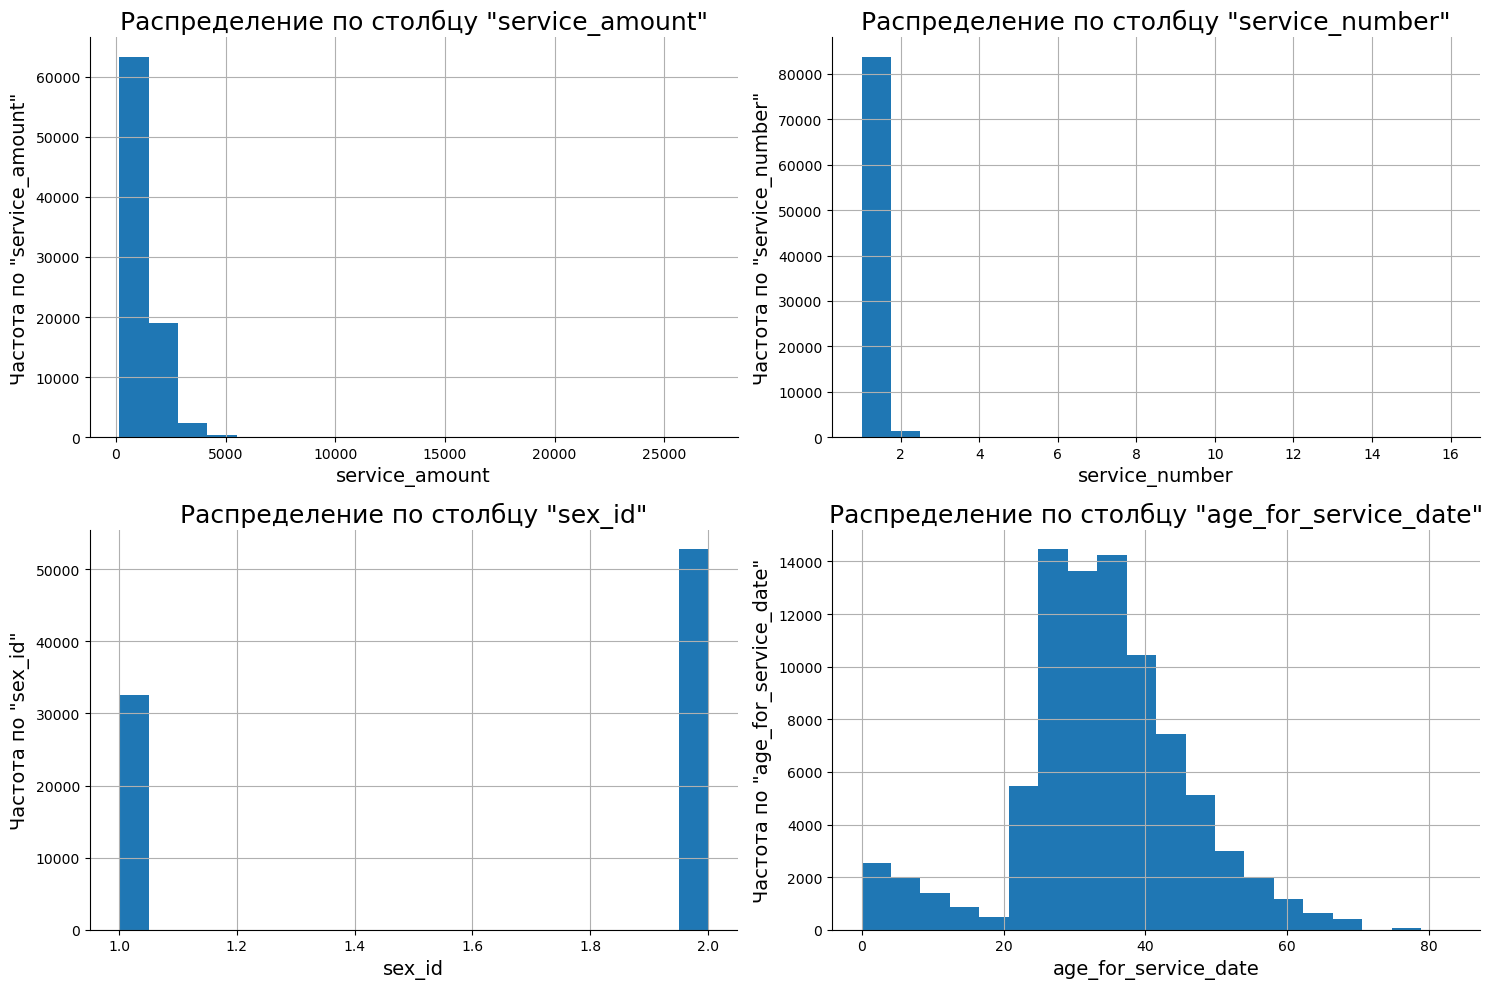

In [6]:
# Построим гистограммы для количественных столбцов нашего датасета
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Выберем столбцы c типом данных int и float
selected_columns = data[['service_amount', 'service_number', 'sex_id', 'age_for_service_date']]
# Визуализируем данные по выбранным столбцам
for i, column in enumerate(selected_columns):
        row = i // 2 # вычисление номера строки для текущего графика в сетке
        col = i % 2 # вычисление номера столбца для текущего графика в сетке
        data[column].hist(bins=20, ax=axes[row, col])
        axes[row, col].set_title(f'Распределение по столбцу "{column}"', fontsize=18)
        axes[row, col].set_xlabel(column, fontsize=14)
        axes[row, col].set_ylabel(f'Частота по "{column}"', fontsize=14)

# Скроем пустую рамку в конце вывода
for i in range(len(selected_columns), len(axes.flatten())):
    fig.delaxes(axes.flatten()[i])

sns.despine()
plt.tight_layout()

plt.show()

- Сумма за оказанные услуги лежит по большей части в диапазоне до 3 тыс. р.;
- В большинстве случаем, пациенты ограничивались одной услугой;
- Пациентов с полом 2 больше, чем пациентов с полом 1;
- Основная масса пациентов по возрасту от 25 до 38 лет.

**Выводы:**

На данном этапе мы:
- Прочитали файл с данными;
- Вывели и изучили общую информацию о нем;
- Минимальная дата в датасете: 2021-01-03;
- Максимальная дата в датасете: 2022-08-31.

Впереди предобработка данных.

<a id="2"></a>

### Предобработка данных

#### Объявление функций для предобработки данных

In [7]:
# Определим функцию для проверки данных на наличие явных дубликатов
def find_explicit_duplicates(dataset):
    
    # Находим явные дубликаты
    explicit_duplicates_cnt = display(f'Количество явных дубликатов: {dataset.duplicated().sum()}')
    
    explicit_duplicates = None
    explicit_duplicates_cnt = 0
    
    # Выводим дубликаты в виде таблицы, если они есть
    if dataset.duplicated().sum() > 0:
        explicit_duplicates = display(dataset[dataset.duplicated(keep=False)])
    
    else:
        display('Явные дубликаты не найдены')
    
    return explicit_duplicates_cnt, explicit_duplicates

In [8]:
# Определим функцию для проверки данных на наличие неявных дубликатов
def find_implicit_duplicates(dataset, columns_to_compare):
    
    # Находим неявные дубликаты
    implicit_duplicates = dataset[dataset.duplicated(subset=columns_to_compare, keep=False)]
    if implicit_duplicates.empty:
        display('Неявных дубликатов нет.')
  
    return implicit_duplicates

In [9]:
# Определим функцию, которая будет выводить описание данных в столбце, количество уникальных значений и 
# топ-5 лист самых популярных значений
def unique_describe(dataset):
    return  display(dataset.describe(), 
                    f'Количество уникальных значений: {len(dataset.unique())}',
                    dataset.value_counts().head())                   

In [10]:
# Определим функцию, с помощью которой произведем первичную обработку данных
def standardization_data(value):
    
    # Удаление лишних пробелов перед и после запятых
    value = re.sub(r'\s*,\s*', ', ', value)

    # Удаление пробелов после закрывающейся скобки перед запятой
    value = re.sub(r'\)\s*,', '),', value)
    
    # Удаление лишних пробелов после открывающихся и перед закрывающимися скобками
    value = re.sub(r'\s*([(\[{])\s*', r'\1', value)
    value = re.sub(r'\s*([)\]}])\s*', r'\1', value)
    
    # Добавление пробела перед открывающейся скобкой и после закрывающейся скобки
    value = re.sub(r'\(', ' (', value)
    value = re.sub(r'\)', ') ', value)

    # Удаление лишних пробелов перед и после текста
    value = ' '.join(value.split())
    
    # Удаление пробелов перед и после дефиса
    value = re.sub(r'\s*-\s*', '-', value)
    
    # Удаление пробелов перед запятой
    value = value.replace(' ,', ',')

    return value

#### Преобразуем типы данных, где необходимо

In [11]:
data['service_date'] = pd.to_datetime(data['service_date'], format='%Y-%m-%d')

#### Проверим пропуски в датасете

In [12]:
# Создадим копию датасета до преобразований
temp = data.copy() 
len(temp)

85369

In [13]:
# Выведем количество пропущенных значений для датасета и отсортируем по возрастанию.
data.isna().sum().sort_values()

record_id                0
service_date             0
service_name             0
service_amount           0
service_number           0
insured                  0
age_for_service_date     0
sex_id                  21
dtype: int64

In [14]:
# Вычислим долю пропусков данных в столбцах 
missing_values_percentage = pd.DataFrame(round(data.isna().mean()*100,3))
missing_values_percentage.style.background_gradient()

,0
record_id,0.000000
service_date,0.000000
service_name,0.000000
service_amount,0.000000
service_number,0.000000
insured,0.000000
sex_id,0.025000
age_for_service_date,0.000000


In [15]:
# Посмотрим на пропуски в стобце sex_id
mask = data['sex_id'].isna()
rows_with_missing_values = data[mask]
display(rows_with_missing_values)

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date
4411,30489299203,2021-03-18,Прием первичный,1470,1,512590,NaN,26
4412,30489299303,2021-03-27,"Общий анализ крови (лейкоцитарная форм,, СОЭ)",693,1,512590,NaN,26
4413,30489299403,2021-03-27,Общий анализ мочи,431,1,512590,NaN,26
4414,30489299503,2021-03-27,Альфа-амилаза панкреатическая,287,1,512590,NaN,26
4415,30489299603,2021-03-27,АЛТ (аланинаминотрансфераза),278,1,512590,NaN,26
4416,30489299703,2021-03-27,АСТ (аспартатаминотрансфераза),242,1,512590,NaN,26
4417,30489299803,2021-03-27,Билирубин общий,287,1,512590,NaN,26
4418,30489299903,2021-03-27,ГГТ (гамма - глютамилтрансфераза),287,1,512590,NaN,26
4419,30489300003,2021-03-27,Глюкоза крови,273,1,512590,NaN,26
4420,30489300103,2021-03-27,Фосфотаза щелочная,287,1,512590,NaN,26


Пропущены данные 2х клиентов, попробуем найти другие данные по их идентификатору.

In [16]:
# Выделим номера клиентов, у которых есть пропуск в поле пола
missing = data.query('sex_id != sex_id').insured.unique()

# Посмотрим, а есть ли такие записи для этих клиентов без пропусков
data.query('sex_id == sex_id and insured in @missing')

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date
29311,31408954403,2021-09-24,Прием первичный,1470,1,512590,2.0,27
29312,31408954503,2021-09-25,Рентгенография крупного сустава (2 снимка),1575,1,512590,2.0,27
29313,31408954603,2021-09-25,Ультразвуковое исследование сустава,1890,1,512590,2.0,27
29314,31408954703,2021-09-27,Прием повторный,1313,1,512590,2.0,27


In [17]:
# Заменим пропуски cтолбце sex_id по insured 512590 на 2.0
display(f'Было пропусков: {data["sex_id"].isna().sum()}')

data['sex_id'].fillna(data.groupby(['insured'])['sex_id'].transform('first'), inplace=True)

display(f'Осталось пропусков: {data["sex_id"].isna().sum()}')

'Было пропусков: 21'

'Осталось пропусков: 4'

Данных для пациента с идентификатором 221581 для заполнения пропусков в столбце sex_id нет. Оставим 4 пропуска без изменений.

#### Изучим дубликаты  в датасете

In [18]:
# Проверим явные дубликаты в датасете 
dataset = data.copy()
find_explicit_duplicates(dataset)

'Количество явных дубликатов: 0'

'Явные дубликаты не найдены'

(0, None)

In [19]:
# Проверим неявные дубликаты в датасете
dataset = data.copy()
columns_to_compare = ['service_date', 'insured', 'service_name']
find_implicit_duplicates(dataset.sort_values(by=['insured', 'service_date']), columns_to_compare)

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date
28849,31408907803,2021-09-21,Прием первичный,1470,1,125073,2.0,66
28850,31408907903,2021-09-21,Прием первичный,1470,1,125073,2.0,66
8284,30620823203,2021-04-23,Прием первичный,1470,1,139539,2.0,42
8293,30620824103,2021-04-23,Прием первичный,1470,1,139539,2.0,42
13179,30786118903,2021-05-03,Прием первичный,1470,1,142447,1.0,24
...,...,...,...,...,...,...,...,...
78061,32978689603,2022-07-13,Взятие мазка,396,1,1217300,2.0,27
85246,33178128603,2022-08-28,"В,мышечная инъекция (за 1 процедуру без стоимости лекарств)",320,1,1302824,2.0,39
85247,33178128703,2022-08-28,"В,мышечная инъекция (за 1 процедуру без стоимости лекарств)",320,1,1302824,2.0,39
83240,33177757303,2022-08-01,Исследование отделяемого молочной железы,1000,1,1302956,2.0,39


Гипотетически, это могут быть неявные дубликаты, когда одна и та же услуга записалась несколько раз под разными record_id. Но, к сожалению, неполнота данных не позволяет утверждать это наверняка, оставим эти данные без изменений.

#### Изучим уникальные значения в столбцах service_name,	service_amount, 	service_number, 	sex_id, 	age_for_service_date

In [20]:
# Выведем уникальные значения в стобце sex_id
data['sex_id'].unique()

array([ 2.,  1., nan])

In [21]:
# Попробуем предположить пол, скрытый за цифрами 1 и 2
data.query('sex_id == 2').head(20)

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date
0,30268157003,2021-01-24,Прием первичный,1470,1,490777,2.0,26
1,30268157103,2021-01-24,"Взятие материала на посев, цитологическое исследование ( риноцитограмма)",284,1,490777,2.0,26
2,30268157203,2021-01-24,"Посев отдел, дыхательных путей - слизистая зева с определением чувствительности к антибиотикам",1134,1,490777,2.0,26
3,30268157303,2021-01-24,"Общий анализ крови (лейкоцитарная форм,, СОЭ)",693,1,490777,2.0,26
4,30268157403,2021-01-24,Ревматоидный фактор,420,1,490777,2.0,26
5,30268157503,2021-01-24,С-реактивный белок,420,1,490777,2.0,26
6,30268157603,2021-01-24,Взятие крови из периферической вены,158,1,490777,2.0,26
7,30268157703,2021-01-26,Прием первичный,1470,1,490777,2.0,26
8,30268157803,2021-01-26,Магнитотерапия (1 сеанс),1040,1,490777,2.0,26
9,30268157903,2021-01-26,УВЧ-терапия (1 сеанс) (1 поле),1040,1,490777,2.0,26


In [22]:
data.query('service_name == "Гинекологический мазок"').head()

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date
16,30268158603,2021-01-27,Гинекологический мазок,525,1,232418,2.0,25
145,30268171503,2021-01-21,Гинекологический мазок,525,1,166120,2.0,33
151,30268172103,2021-01-25,Гинекологический мазок,525,1,535243,2.0,38
156,30268172603,2021-01-23,Гинекологический мазок,525,1,210891,2.0,40
268,30268183803,2021-01-15,Гинекологический мазок,525,1,490772,2.0,35


Судя по наименованию некоторых услуг за цифрой 2 скрыты женщины. Переименуем значения в стобце sex_id для удобства.

In [23]:
data['sex_id'] = data['sex_id'].replace({1:'мужской', 2:'женский'}, regex=True)

In [24]:
# Проанализируем данные столбца sex_id
dataset = data['sex_id'].copy()
unique_describe(dataset)

count       85365
unique          2
top       женский
freq        52821
Name: sex_id, dtype: object

'Количество уникальных значений: 3'

sex_id
женский    52821
мужской    32544
Name: count, dtype: int64

Как я уже отмечала выше, пациентов женского пола (2) больше, чем мужского.

In [25]:
# Проанализируем данные столбца service_amount
dataset = data['service_amount'].copy()
unique_describe(dataset)

count    85369.000000
mean      1166.094636
std        799.062660
min        147.000000
25%        550.000000
50%       1155.000000
75%       1530.000000
max      26999.000000
Name: service_amount, dtype: float64

'Количество уникальных значений: 535'

service_amount
1540    8258
1380    6062
1470    5415
1313    4025
300     2455
Name: count, dtype: int64

Пока ничего необычного не вижу. Разброс цен от 147 рублей до 26999 рублей за услугу. Всего 535 вариантов чеков. Посмотрим на минимальное и максимальное значение поближе.

In [26]:
# Срез по данным с минимальным чеком
data.query('service_amount == 147').head(20)

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date
472,30268204203,2021-01-21,Инстилляция лекарственных веществ в конъюнктивную полость,147,1,490556,женский,11
797,30268236703,2021-01-20,СОЭ,147,1,194724,женский,31
1109,30268268103,2021-01-05,Инстилляция лекарственных веществ в конъюнктивную полость,147,1,160739,женский,29
1116,30268268803,2021-01-08,Инстилляция лекарственных веществ в конъюнктивную полость,147,1,160739,женский,29
1119,30268269103,2021-01-10,Инстилляция лекарственных веществ в конъюнктивную полость,147,1,160739,женский,29
1353,30268292603,2021-01-28,Инстилляция лекарственных веществ в конъюнктивную полость,147,1,288612,мужской,38
1572,30268314503,2021-01-22,Инстилляция лекарственных веществ в конъюнктивную полость,147,1,181935,женский,36
2072,30346794503,2021-02-15,Калий,147,1,490619,мужской,42
2073,30346794603,2021-02-15,Натрий,147,1,490619,мужской,42
2123,30346800103,2021-02-05,Инстилляция лекарственных веществ в конъюнктивную полость,147,1,490556,женский,11


In [27]:
# Срез по данным с максимальным чеком
data.query('service_amount == 26999').head()

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date
18519,30961787103,2021-06-24,"гистерорезектоскопия при полипах , РДВ",26999,1,362928,женский,51


В целом, ничего не обычного, 147 рублей стоят некоторые анализы и процедуры, 26999 - хирургическая операция. Посмотрим на историю посещений пациентки с операцией.

In [28]:
data.query('insured == 362928')

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date
5980,30489456103,2021-03-31,Ультразвуковое исследование гинекология трансвагинально с ДС сосудов,2100,1,362928,женский,51
5981,30489456203,2021-03-31,Прием первичный,1470,1,362928,женский,51
5982,30489456303,2021-03-31,Рефрактометрия,714,1,362928,женский,51
5983,30489456403,2021-03-31,Подбор сферических очков,756,2,362928,женский,51
5984,30489456503,2021-03-31,Измерение внутриглазного давления,1156,2,362928,женский,51
6167,30489474803,2021-03-31,Исследование глазного дна щелевой лампой (офтальмоскопия),966,1,362928,женский,51
6168,30489474903,2021-03-31,Периметрия,903,1,362928,женский,51
6169,30489475003,2021-03-31,Прием повторный,1313,1,362928,женский,51
6170,30489475103,2021-03-31,Взятие мазка,682,2,362928,женский,51
6171,30489475203,2021-03-31,Гинекологический мазок,525,1,362928,женский,51


Пациентка довольно активно следит за здоровьем, но сопоставимых по стоимости с операцией услуг у нее больше нет, кроме сопутствующей операции анастезии (11550 р.). Посмотрим, сколько вообще в данных было чеков больше, чем на 10000р.

In [29]:
display(len(data.query('service_amount > 10000')))
display(data.query('service_amount > 10000'))

13

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date
8316,30620826503,2021-04-13,МСКТ почек и надпочечников с внутривенным болюсным контрастированием,11025,1,544444,мужской,31
15588,30961493203,2021-06-17,МРТ брюшной полости и забрюшинного пространства с внутривенным контрастированием,17325,1,634755,мужской,41
16373,30961571703,2021-06-06,МСКТ мочевыделительной системы с внутривенным болюсным контрастированием,12075,1,634765,мужской,42
16564,30961590803,2021-06-06,Вскрытие абсцесса различной локализации,12810,2,181718,женский,34
18518,30961787003,2021-06-24,Тотальная внутривенная анестезия от 20 минут до 60 минут,11550,1,362928,женский,51
18519,30961787103,2021-06-24,"гистерорезектоскопия при полипах , РДВ",26999,1,362928,женский,51
23794,31249334503,2021-08-20,МРТ головного мозга и гипофиза с контрастированием,15225,1,544627,женский,34
27994,31408821503,2021-09-09,Мультипараметрическая МРТ предстательной железы с динамическим контрастированием,14175,1,531654,мужской,59
36348,31680600903,2021-11-07,МСКТ органов брюшной полости и забрюшинного пространства с внутривенным болюсным контрастированием,12680,1,716141,женский,31
36760,31680642403,2021-11-20,МСКТ органов брюшной полости и забрюшинного пространства с внутривенным болюсным контрастированием,12680,1,743829,мужской,42


Всего 13 записей. И это либо хирургия, либо  МРТ/МСКТ. Удалять это данные, как выбросы, я не буду, их удаление повлияет на изучение размера выручки и категорий услуг.

In [30]:
# Проанализируем данные столбца service_number
dataset = data['service_number'].copy()
unique_describe(dataset)

count    85369.000000
mean         1.022865
std          0.229015
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         16.000000
Name: service_number, dtype: float64

'Количество уникальных значений: 13'

service_number
1    83807
2     1373
3      135
4       26
5       10
Name: count, dtype: int64

In [31]:
# Посмотрим на сами уникальные значения в столбце service_number
sorted(data['service_number'].unique())

[1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16]

Количество оказанных услуг за раз услуг вариьируется от 1 до 7, затем от 11 до 16. Посмотрим на строки, где количество услуг больше или равно 11.

In [32]:
data.query('service_number >= 11')

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date
9050,30620900003,2021-04-03,Постановка кожных аллергопроб (за 1 единицу),2772,12,512453,мужской,29
12519,30786052903,2021-05-01,Постановка кожных аллергопроб (за 1 единицу),2541,11,512572,женский,35
12618,30786062803,2021-05-15,Постановка кожных аллергопроб (за 1 единицу),3003,13,363075,женский,34
14404,30786241403,2021-05-15,Постановка кожных аллергопроб (за 1 единицу),3003,13,596505,мужской,33
36313,31680597403,2021-11-20,Постановка кожных аллергопроб (за 1 единицу),3840,16,544906,мужской,31
37567,31680727103,2021-11-25,Постановка кожных аллергопроб (за 1 единицу),3840,16,734530,женский,43
48871,32112436003,2022-02-05,Постановка кожных аллергопроб (за 1 единицу),3600,15,698543,женский,36
58060,32327252803,2022-03-24,Постановка кожных аллергопроб (за 1 единицу),3120,13,611837,женский,50
63295,32511089303,2022-04-30,Постановка кожных аллергопроб (за 1 единицу),3120,13,873314,женский,37
69049,32631559703,2022-05-05,Постановка кожных аллергопроб (за 1 единицу),3120,13,194239,мужской,42


Только аллергопробы в списке, получается одна услуга - один аллерген.

In [33]:
# Проанализируем данные столбца age_for_service_date
dataset = data['age_for_service_date'].copy()
unique_describe(dataset)

count    85369.000000
mean        33.851691
std         12.144646
min          0.000000
25%         27.000000
50%         34.000000
75%         41.000000
max         83.000000
Name: age_for_service_date, dtype: float64

'Количество уникальных значений: 76'

age_for_service_date
34    4190
30    3560
31    3469
37    3437
36    3400
Name: count, dtype: int64

In [34]:
# Посмотрим на сами уникальные значения в столбце service_number
print(sorted(data['age_for_service_date'].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75, 83]


Пациенты клиники - люди разных возрастов, от грудничков (0 лет) до людей пожилого возраста старше 70, максимальный возраст пациента - 83 года. Посмотрим, на всякий случай на крайние значения 0 и 83.

In [35]:
# Срез по минимальному возрасту
data.query('age_for_service_date == 0').head(10)

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date
116,30268168603,2021-01-20,Прием повторный,1313,1,246934,женский,0
117,30268168703,2021-01-03,Прием повторный,1313,1,246935,женский,0
118,30268168803,2021-01-08,Прием повторный,1313,1,246935,женский,0
127,30268169703,2021-01-04,Прием первичный,1470,1,221630,мужской,0
128,30268169803,2021-01-06,Общий анализ мочи,431,1,221630,мужской,0
129,30268169903,2021-01-06,Взятие крови из периферической вены,158,1,221630,мужской,0
130,30268170003,2021-01-06,"Общий анализ крови (лейкоцитарная форм,, СОЭ)",693,1,221630,мужской,0
424,30268199403,2021-01-30,Прием первичный,1470,1,490546,мужской,0
425,30268199503,2021-01-17,Прием первичный,1470,1,512434,мужской,0
426,30268199603,2021-01-17,Прием первичный,1470,1,512434,мужской,0


In [36]:
# Срез по максимальному возрасту
data.query('age_for_service_date == 83').head()

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date
3910,30347019403,2021-02-04,Прием первичный,1470,1,490933,мужской,83


Пока ничего необычного нет. Пациент 83-х лет был всего один.

In [37]:
# Проанализируем данные столбца service_name
dataset = data['service_name'].copy()
unique_describe(dataset)

count               85369
unique                875
top       Прием первичный
freq                 6058
Name: service_name, dtype: object

'Количество уникальных значений: 875'

service_name
Прием первичный                                  6058
Прием повторный                                  4477
Взятие крови из периферической вены              4215
Общий анализ крови (лейкоцитарная форм,, СОЭ)    3190
Магнитотерапия (1 сеанс)                         2838
Name: count, dtype: int64

In [38]:
# Посмотрим на сами уникальные значения столбца service_name
sorted(data['service_name'].unique())

['(1 E)Аллергопанель IgE (Молоко коровье, Молоко козье, Молоко овечье,Сыр, Творог,Сметана, Йогурт, Кефир )',
 '(2 E)Аллергопанель IgE (Пшеничная мука, Ржаная мука, Рис, Гречка, Овес, Перловка, Пшено, Ячменнная крупа )',
 '(3 E)Аллергопанель IgE (Фасоль (бобы), Горох, Чечевица (смесь), Кукуруза, Дрожжи пекарские, Белок куриного яйца, Желток куриного яйца, Яйцо перепелиное)',
 '(4 E)Аллергопанель IgE (Говядина, Телятина, Свинина, Баранина, Курица, Индейка, Утка, Гусь)',
 '(Б1 (11))Аллергопанель IgE шерсть кошки, шерсть собаки, шерсть овцы, клещ D,pteroniss, клещ D.farina, пыль домашняя, перо подушки, библиотечная пыль)',
 '17-OH - гидроксипрогестерон',
 '25-OH витамин D (25-гидроксихолекальциферол)',
 'Ascaris IgG',
 'Bordetella (pertusis) IgA',
 'Bordetella (pertusis) IgG',
 'Bordetella (pertusis) IgM',
 'Bordetella pertussis (Слюна)',
 'Bordetella pertussis (Соскоб)',
 'CMV (цитомегаловирус) (Кровь)',
 'CMV (цитомегаловирус) (Слюна)',
 'CMV (цитомегаловирус) (Соскоб)',
 'Candida albica

Если внимательно посмотреть на уникальные данные, можно найти достаточно много опечаток, заглавных букв, где не нужно, услуг непонятного характера, например, "Таракан" или "Перо попугая", так же видим лишние пробелы после открывающихся скобок и перед закрывающимися, нехватку пробелов после запятых и т.д. Постараюсь привести данные к условно одному формату. 

In [39]:
# Применение функции для первичной обработки данных к каждой ячейке столбца service_name
data['service_name'] = data['service_name'].apply(standardization_data)

Мне бы не хотелось приводить данные к нижнему регистру, так как в них много медицинской терминологии, обозначаемой заглавными буквами или их сочетанием со строчными, поэтому я вручную заменю некоторые слова и опечатки в пределах видимости.

In [40]:
# Приводим данные к условному единообразию
data = data.apply(lambda x: x.replace({'Ультразвуковое исследование':'УЗИ',
                                       'ВИТАМИН':'Витамин',
                                       'ТРЕСКА':'Треска',
                                       'ДРОЖЖИ ПЕКАРСКИЕ':'Аллерген индивидуальный (Дрожжи пекарские)',
                                       'ДРОЖЖИ ПИВНЫЕ':'Аллерген индивидуальный (Дрожжи пивные)',
                                       'ЖЕЛТОК КУРИНОГО ЯЙЦА':'Аллерген индивидуальный (Желток куриного яйца)',
                                       'БЕЛОК КУРИНОГО ЯЙЦА':'Аллерген индивидуальный (Белок куриного яйца)',
                                       'ТВОРОГ':'Аллерген индивидуальный (Творог)',
                                       'Таракан':'Аллерген индивидуальный (Таракан) IgE',
                                       'Перо попугая':'Аллерген индивидуальный (Перо попугая) IgE',
                                       'ГЛЮТЕН':'Аллерген индивидуальный (Глютен)',
                                       'ЙОГУРТ':'Аллерген индивидуальный (Йогурт)',
                                       'КАЗЕИН':'Аллерген индивидуальный (Казеин)',
                                       'КЛУБНИКА':'Аллерген индивидуальный (Клубника)',
                                       'КОРОВЬЕ МОЛОКО':'Аллерген индивидуальный (Коровье молоко)',
                                       'КУРИЦА':'Аллерген индивидуальный (Курица)',
                                       'ПШЕНИЦА':'Аллерген индивидуальный (Пшеница)',
                                       'РЫБА':'Аллерген индивидуальный',
                                       'СМЕТАНА':'Аллерген индивидуальный (Сметана)',
                                       'МОРКОВЬ':'Аллерген индивидуальный (Морковь)',
                                       'КЕФИР':'Аллерген индивидуальный (Кефир)',
                                       'Латекс':'Аллерген индивидуальный (Латекс) IgE',
                                       'Плесень':'Аллерген индивидуальный IgE Плесень',
                                       'Пыльца амброзии':'Аллерген индивидуальный (Пыльца амброзии) IgE',
                                       'Пыльца березы':'Аллерген индивидуальный (Пыльца березы) IgE',
                                       'Пыльца ежи':'Аллерген индивидуальный (Пыльца ежи) IgE',
                                       'Пыльца ольхи':'Аллерген индивидуальный (Пыльца ольхи) IgE',
                                       'Пыльца орешника':'Аллерген индивидуальный (Пыльца орешника) IgE',
                                       'Пыльца полыни':'Аллерген индивидуальный (Пыльца полыни) IgE',
                                       'Эпителий кошки':'Аллерген индивидуальный (Эпителий кошки) IgE',
                                       'Эпителий кролика':'Аллерген индивидуальный (Эпителий кролика) IgE',
                                       'Эпителий лошади':'Аллерген индивидуальный (Эпителий лошади) IgE',
                                       'Эпителий морской свинки':
                                       'Аллерген индивидуальный (Эпителий морской свинки) IgE',
                                       'Эпителий мыши':'Аллерген индивидуальный (Эпителий мыши) IgE',
                                       'Эпителий собаки':'Аллерген индивидуальный (Эпителий собаки) IgE',
                                       'Клещ домашней пыли D, farinae':
                                       'Аллерген индивидуальный (Клещ домашней пыли D.farina) IgE',
                                       'Клещ домашней пыли D, pteronyssinus':
                                       'Аллерген индивидуальный (Клещ домашней пыли D.pteroniss) IgE',
                                       'Ячменнная крупа': 'Ячменная крупа',
                                       'шерсть':'Шерсть',
                                       'клещ':'Клещ',
                                       'библиотечная':'Библиотечная',
                                       'перо':'Перо',
                                       'таракан':'Таракан',
                                       'перхоть':'Перхоть',
                                       'пыль':'Пыль',
                                       'дафния':'Дафния',
                                       'вата':'Вата',
                                       'латекс':'Латекс',
                                       'береза, орешник, ольха, тимофеевка, ежа сборная, овсянница, полынь, лебеда':
                                       'Береза, Орешник, Ольха, Тимофеевка, Ежа сборная, Овсянница, Полынь, Лебеда',
                                       'дуб, мятлик, лисохвост, амброзия, одуванчик, пырей, цветы сирени, \
                                       подсолнечник':
                                       'Дуб, Мятлик, Лисохвост, Амброзия, Одуванчик, Пырей, Цветы сирени, \
                                       Подсолнечник',
                                       'D, pteroniss':'D.pteroniss',
                                       'Посев отдел,':'Посев отдел',
                                       'форм,':'формула',
                                       'поверхн,':'поверхности',
                                       'Bordetella (pertusis)':'Bordetella pertussis',
                                       'Инстиляция':'Инстилляция',
                                       'В, в':'В/в',
                                       'в, р.':'в.р.',
                                       'С:':'С',  
                                       '03; 09':'03, 09',
                                       'Соксоб':'Соскоб',
                                       'от 0, 6 до 1, 0см':'от 0.6 до 1.0 см',
                                       'В, мышечная': 'В/мышечная',
                                       'Внутримышечное':'В/мышечное',
                                       'virus(8)':'virus 8',
                                       'сут, моча':'сут. моча',
                                       '-1 зона, 1 сеанс':'(1 зона)(1 сеанс)',
                                       'ед,':'ед.',
                                       'более 4 кв.см.':'более 4 кв. см.',
                                       'более 4см, кв.':'более 4 кв. см.',
                                       'менее 4 кв, см.':'менее 4 кв. см.',
                                       'менее 4 кв.см.':'менее 4 кв. см.',
                                       'менее 4см, кв.':'менее 4 кв. см.',
                                       'более 4 см, кв.':'более 4 кв. см.',
                                       'менее 4 см, кв.':'менее 4 кв. см.',                                      
                                       'Блох С, П':'Блох С.П.',
                                       'Блох С.П':'Блох С.П.',
                                       'терапевта первичный':'терапевта, первичный',
                                       'Прием главного специалиста, врача-дерматолога, врача-эксперта':
                                       'Прием врача-дерматолога, главного специалиста, врача-эксперта',
                                       'общ,': 'общ.',
                                       'путем 1ед, на теле': 'путем на теле (1 ед.)',
                                       'др,': 'др.',
                                       'spp,': 'spp',
                                       'agal,':'agal',
                                       '(1 шт. размером до 5 мм.)':'(1 шт.) (размером до 5 мм.)',
                                       '0, 5': '0.5',
                                       'орг, ': 'орг.', 
                                       '2см,':'2 см.',
                                       '2 см':'2 см.',
                                       ',,':',',
                                       'а/ген':'антиген',
                                       'альфа-амилаза': 'Альфа-амилаза',
                                       'бета-ХГЧ': 'Бета-ХГЧ',                                       
                                       'гистерорезектоскопия при полипах': 'Гистерорезектоскопия при полипах',
                                       'тиреоПыльксидазе': 'тиреопероксидазе',
                                       'Кортизол слюна': 'Кортизол (Cлюна)',
                                       'иследование': 'исследование',
                                       'Cladosporium Herb, , Penicillium tardum': 
                                       'Cladosporium Herb, Penicillium tardum',
                                       'Прием мануального терапевта повторный': 
                                       'Прием мануального терапевта, повторный',
                                       'Прием рефлексотерапевта повторный': 'Прием рефлексотерапевта, повторный',
                                       'Прием трапевта, первичный': 'Прием тeрапевта, первичный'
                                       }, regex=True))

Отредактируем строку с неправильно расставленными скобками.

In [41]:
# (Б1 (11) ) Аллергопанель IgE Шерсть кошки, Шерсть собаки, Шерсть овцы, Клещ D.pteroniss,
# Клещ D.farina, Пыль домашняя, Перо подушки, Библиотечная Пыль)

what_to_replace_1 = r'\(Б1 \(11\) \) (?P<content>.+?)\)(?=,|$)'
what_to_replace_with_1 = r'Б1 (11) \g<content>'
data['service_name'] = data['service_name'].replace(what_to_replace_1, what_to_replace_with_1, regex=True)

what_to_replace_2 = r'Б1 \(11\) Аллергопанель IgE (?P<content>.+)$'
what_to_replace_with_2 = r'Б1 (11) Аллергопанель IgE (\g<content>)'
data['service_name'] = data['service_name'].replace(what_to_replace_2, what_to_replace_with_2, regex=True)

В списке наименований мне встретились возможные неявные дубликаты, очень похожие наименования, которые могли появиться благодаря технической ошибке. Проверим эту теорию.

In [42]:
(data
 .query('service_name.str.contains("Комплекс на операцию")', engine='python')
 .groupby(['service_name','service_amount'])
 .agg({'record_id':'nunique', 'service_date':'min'}).reset_index()
)

,service_name,service_amount,record_id,service_date
0,"Комплекс на операцию: (Общий анализ крови (без лейкоцитарной формулы), СОЭ, Лейкоцитарная формула, Группа крови, Rh-фактор, Келл, АЛТ",4250,9,2021-12-03
1,"Комплекс на операцию: (Общий анализ крови (без лейкоцитарной формулы), СОЭ, Лейкоцитарная формула, Группа крови, Rh-фактор, Келл, АЛТ (аланинаминотрансфераза), АСТ (аспартатаминотрансфераза), Билирубин общий, Глюкоза крови, Калий, Натрий, Креатинин, Моче",4043,2,2021-05-16
2,"Комплекс на операцию: (Общий анализ крови (без лейкоцитарной формулы), СОЭ, Лейкоцитарная формула, Группа крови, Rh-фактор, Келл, АЛТ (аланинаминотрансфераза), АСТ (аспартатаминотрансфераза), Билирубин общий, Глюкоза крови, Калий, Натрий, Креатинин, Моче",4250,1,2021-10-14


Думаю, что это одна и таже услуга, которая, кстати, подорожала с октября 2021 года, заменю дубликаты на полную строку.

In [43]:
# Заменяем неявные дубликаты
what_to_replace_1 = 'Комплекс на операцию: (Общий анализ крови (без лейкоцитарной формулы), СОЭ, \
Лейкоцитарная формула, Группа крови, Rh-фактор, Келл, АЛТ'

data = data.replace(what_to_replace_1, what_to_replace_1 + ' (аланинаминотрансфераза), \
АСТ (аспартатаминотрансфераза), Билирубин общий, Глюкоза крови, Калий, Натрий, Креатинин, Мочевина)') 

what_to_replace_2 = 'Комплекс на операцию: (Общий анализ крови (без лейкоцитарной формулы), СОЭ, \
Лейкоцитарная формула, Группа крови, Rh-фактор, Келл, АЛТ (аланинаминотрансфераза), \
АСТ (аспартатаминотрансфераза), Билирубин общий, Глюкоза крови, Калий, Натрий, Креатинин, Моче'

data = data.replace(what_to_replace_2, what_to_replace_2 + 'вина)') 

In [44]:
(data
 .query('service_name.str.contains("Alternaria tenuis")', engine='python')
 .groupby(['service_name','service_amount'])
 .agg({'record_id':'nunique', 'service_date':'min'}).reset_index()
)

,service_name,service_amount,record_id,service_date
0,"Гр (8) Аллергопанель IgE (Alternaria tenuis, Mucor pusillus, Aspergillus niger, Cladosporium Herb, Penicillium tardum, Penicillium expansum, Candida albicans",1520,1,2022-03-15
1,"Гр (8) Аллергопанель IgE (Alternaria tenuis, Mucor pusillus, Aspergillus niger, Cladosporium Herb, Penicillium tardum, Penicillium expansum, Candida albicans, Fusarium oxyspora)",1449,2,2021-07-16
2,"Гр (8) Аллергопанель IgE (Alternaria tenuis, Mucor pusillus, Aspergillus niger, Cladosporium Herb, Penicillium tardum, Penicillium expansum, Candida albicans, Fusarium oxyspora)",1520,1,2021-10-17


В данном случае похожая ситуация, с октября 2021 цена на услугу поднялась, заменю неяный дубликат.

In [45]:
# Заменяем неявный дубликат
what_to_replace = 'Гр (8) Аллергопанель IgE (Alternaria tenuis, Mucor pusillus, Aspergillus niger, \
Cladosporium Herb, Penicillium tardum, Penicillium expansum, Candida albicans'

data = data.replace(what_to_replace, what_to_replace + ', Fusarium oxyspora)') 

In [46]:
(data
 .query('service_name.str.contains("Гемостазиограмма")', engine='python')
 .groupby(['service_name','service_amount'])
 .agg({'record_id':'nunique', 'service_date':'min'}).reset_index()
)

,service_name,service_amount,record_id,service_date
0,"Гемостазиограмма (Коагулограмма: Антитромбин III, АЧТВ, МНО, Плазминоген, Протромбиновое время, РФМК, Тромбиновое время, Фибриноген, Активность",2060,27,2021-11-16
1,"Гемостазиограмма (Коагулограмма: Антитромбин III, АЧТВ, МНО, Плазминоген, Протромбиновое время, РФМК, Тромбиновое время, Фибриноген, Активность",2100,2,2022-07-21
2,"Гемостазиограмма (Коагулограмма: Антитромбин III, АЧТВ, МНО, Плазминоген, Протромбиновое время, РФМК, Тромбиновое время, Фибриноген, Активность факторов протромбинового комплекса % по Квику)",1964,23,2021-01-20
3,"Гемостазиограмма (Коагулограмма: Антитромбин III, АЧТВ, МНО, Плазминоген, Протромбиновое время, РФМК, Тромбиновое время, Фибриноген, Активность факторов протромбинового комплекса % по Квику)",2060,4,2021-10-05
4,"Гемостазиограмма (Коагулограмма: Антитромбин III, АЧТВ, МНО, Плазминоген, Протромбиновое время, РФМК, Тромбиновое время, Фибриноген, Активность факторов протромбинового комплекса % по Квику)",2100,1,2022-08-22


Эти строки похожи на дубликаты, так как в первом варианте не хватает закрывающейся скобки, как будто часть строки обрезана. Я заменю эти два варианта на один полный. Но и тут имеет место повышения цены два раза за указанный период, с октября 2021, затем с июля 2022.

In [47]:
# Заменяем неявный дубликат
what_to_replace = 'Гемостазиограмма (Коагулограмма: Антитромбин III, АЧТВ, МНО, Плазминоген, \
Протромбиновое время, РФМК, Тромбиновое время, Фибриноген, Активность'

data = data.replace(what_to_replace, what_to_replace + ' факторов протромбинового комплекса % по Квику)') 

In [48]:
# Проверим количество оставшихся уникальных значений в столбце service_name
len(data.service_name.unique())

861

После обработки удалось сократить список уникальных значений в столбце service_name на 14 позиций. Не так и много, но тоже неплохо.

In [49]:
# Сверяем наши данные по количеству строк по окончанию обработки данных в датасете.
a, b = len(temp), len(data)
print(len(temp), len(data), round((a - b) / a * 100, 2))

85369 85369 0.0


**Вывод:**

В рамках этапа предобработки данных были сделаны следующие изменения:
- Был изменен тип данных в столбце service_date;
- Данные в стобцах были проверены на пропуски, в столбце sex_id было найдено 21 пропущенное значение, 17 из них удалось дозаполнить, сравнив данные по столбцу insured;
- Изучены уникальные значения в стобцах;
- Уникальные значения столбца sex_id были заменены с 1 и 2 на "мужской" и "женский";
- Данные проверены на наличие дубликатов. Явные дубликаты отсутствуют;
- Заменены 3 неявных дубликата в столбце service_name;
- Исправлены опечатки, убраны лишние пробелы, запятые, скобки и добавлены недостающие, данные приведены к условно одинаковой стилистике в столбце service_name, благодаря чему количество уникальных значений в столбце сократилось с 875 до 861.

<a id="3"></a>

### Добавление новых признаков

#### Категоризация данных в столце service_name

Категоризировать данные с точностью до одного наименования довольно сложно не зная медицинскую терминологию, поэтому постараюсь разбить данные на условно близкие группы и сохраню данные в столбце category_name.

In [50]:
# Категоризируем данные в столбце service_name с помощью функции и создадим новый столбец category_name
service_name_dict = {'Анализы':['Антитела', 'антитела', 'АСЛО', 'Аллерг', 'AT', 'Аль', 'Андро', 'антиген', 'АТ',
                                'Аполипопротеин', 'Билирубин', 'белок', 'взятие', 'Витамин', 'вирус', 'ВИЧ', 
                                'ВПЧ', 'Гепатит', 'гепатит', 'геназа', 'Гистологич', 'гистолог', 'гормон', 
                                'Госпитальный', 'Гликоли', 'Глюкоз', 'Гомоцис', 'гемоглоб', 'гестерон', 
                                'глобулин', 'ДНК', 'Д-димер', 'Диаскин', 'железо', 'Железо', 'забор', 'Инсулин', 
                                'Иммунный', 'Кров', 'кров', 'Комплекс на', 'Креатин', 'Кортизол', 'кал', 'Кал', 
                                'Келл', 'ЛДГ', 'липопр', 'лактат', 'Лактат', 'ЛПНП', 'липаза', 'Липаза','лактин', 
                                'моч', 'Моч', 'мазок', 'мазка', 'мокроты', 'Магний', 'Манту', 'МНО', 'Натрий', 
                                'общий', 'отделяемого', 'ОЖСС', 'посев', 'Посев', 'пунктатов', 'ПЦР', 'протеин',
                                'пептид', 'Проба', 'проба', 'Проинсулин', 'РНК', 'РФМК', 'Ренин', 'Ретикул', 
                                'Риноцит', 'ресниц', 'Слюна', 'Соскоб', 'соскоб', 'сока', 'секрет', 'СА', 
                                'сфераза', 'стерон', 'Серотонин', 'Скрининг', 'скрининг', 'стрепто', 'стераза', 
                                'СОЭ', 'Тест', 'Т4', 'ТТГ', 'Т3', 'Тромб', 'тромб', 'титр', 'Триглицериды', 
                                'уреаз', 'фракци', 'фактор', 'Ферритин', 'феррин', 'формула', 'Фибрин', 
                                'Флороценоз', 'Форф', 'Фолие', 'ХГЧ', 'Фосф', 'Хлор', 'Холестерин', 'Цитологи', 
                                'цитологич', 'Цинк', 'Эстрадиол', 'Экспресс', 'экспресс', '25-OH', 'IgA', 'IgM', 
                                'IgG', 'IgE', 'IgG/IgM', 'НЕ4', 'HLA', 'Rh', 'Toxoplasma', 'virus'], 
                     'Инструментальные исследования':['аспирация', 'Биопсия', 'биопсия', 'бинокуляр',
                                                      'Водно-сифонная', 'графия', 'Дуплексное сканирование',
                                                      'Зонд', 'Измерение', 'КТГ', 'лампой', 'мониторирование', 
                                                      'метрия', 'МРТ', 'МСКТ', 'Осмотр', 'полихром', 'Пункция', 
                                                      'Рентген', 'рентген', 'скопия', 'сканирование', 'слуха', 
                                                      'Тредмил', 'Холтер', 'ЭКГ', 'ЭЭГ', 'УЗИ', 
                                                      'Ультразвуковое исследование', 'Эндоскоп'],
                     'Физиотерапия':['ВТЭС', 'КУФ', 'ЛФК', 'Массаж', 'массаж', 
                                     'Мануальная', 'мануальная', 'миостимуляция', 'сеанс', 'Сеанс', 'терапия',
                                     'токи', 'Ударно', 'УВЧ', 'форез', 'Ярило'],
                     'Вакцинация':['Вакцинация'],
                     'Процедурный кабинет':['Аппликаци', 'Анемизация', 'Анестезия', 'блокада', 'Блокада', 
                                            'В/мышеч', 'Введение', 'Вливание', 'Иммобилизация', 'Инъекция', 
                                            'инъекция', 'инфузия', 'Инстилляция', 'Ингаляция', 'компресс',
                                            'Катетеризация', 'Накожное', 'Наложение', 'наложение',  
                                            'Небулайзеротерапия', 'Обработка', 'обработка', 'проведение', 
                                            'Постановка', 'промывание', 'Промывание', 'пункция', 'повязки', 
                                            'перевязка', 'Перевязка', 'Прижигание', 'Снятие', 'Санация', 
                                            'Смазывание', 'тампонада', 'Туалет', 'Туширование', 'Шинирование', 
                                            'швов'],
                     'Хирургия':['анестезия', 'Вскрытие', 'вскрытие', 'Гистерорезектоскопия',  
                                 'Коагуляция', 'Криодеструкция', 'ножом', 'Репозиция', 'Хирургич', 'хирургич',
                                 'Удаление', 'удаление'],
                     'Прием':['Консультация', 'осмотр', 'Прием', 'Консультация']                        
}

# Определение функции для категоризации данных в столбце service_name
def category(name):
    for category, items_list in service_name_dict.items():
        for item in items_list:
            if item in name:
                return category
    return 'Другое'
        
data['category_name'] = data['service_name'].apply(category)

In [51]:
# Посмотрим, как распределились данные по категориям
data['category_name'].value_counts()

category_name
Анализы                          28670
Прием                            26414
Инструментальные исследования    14797
Физиотерапия                     11422
Процедурный кабинет               2908
Другое                             585
Хирургия                           544
Вакцинация                          29
Name: count, dtype: int64

In [52]:
# Проверим, все ли данные из датасета попали в распределение
data['category_name'].value_counts().sum()

85369

In [53]:
# Проверим, какие услуги попали в категорию "Другое"
data.query('category_name == "Другое"').groupby('service_name').agg({'record_id':'nunique'}).reset_index()

,service_name,record_id
0,Вестибулярные маневры,1
1,Подбор СРАР терапии,1
2,Подбор сферических очков,263
3,Подбор цилиндрических очков,58
4,Пребывание в палате стационара (дневное до 21:00),2
5,Проведение комплекса специфических вестибулярных тестов,45
6,Проведение комплекса специфических вестибулярных тестов у пациентов с головокружением,71
7,Продувание слуховых труб по Политцеру,13
8,Продувание слуховых труб по Политцеру с двух сторон,53
9,Функция внешнего дыхания,78


#### Категоризация данных в столце age_for_one_service

In [54]:
# Создадим новый категориальный столбец category_age с разбивкой по возрастным группам
# Определение функции для категоризации данных по стобцу age_for_service_date
def categorization_age(age):
    try:
        if 0 <= age <= 9:
            return '0-9'
        elif 10 <= age <= 19:
            return '10-19'
        elif 20 <= age <= 29:
            return '20-29'
        elif 30 <= age <= 39:
            return '30-39'
        elif 40 <= age <= 49:
            return '40-49'
        elif 50 <= age <= 59:
            return '50-59'
        elif 60 <= age <= 69:
            return '60-69'
        elif 70 <= age <= 79:
            return '70+'  
    except:
        pass
        
data['category_age'] = data['age_for_service_date'].apply(categorization_age)    

#### Выделение года из даты

In [55]:
# Создадим новый столбец  service_year с годом посещения клиники
data['service_year'] = data['service_date'].dt.year

#### Выделение месяца из даты

In [56]:
# Создадим новый столбец  service_month с месяцем посещения клиники
data['service_month'] = data['service_date'].dt.month

#### Расчет средней стоимости одной услуги в течение одного дня

In [57]:
# Создадим новый столбец price_for_one_service со средней ценой стоимости услуги за одно посещение
data['price_for_one_service'] = data['service_amount'] / data['service_number']

#### Категоризация сезонности

In [58]:
# Создадим столбец с сезоном на дату визита
# Определение функции для категоризации данных по стобцу service_month
def categorization_season(month):
    try:
        if month in [12,1,2]:
            return 'зима'
        elif month in [3,4,5]:
            return 'весна'
        elif month in [6,7,8]:
            return 'лето'
        elif month in [9,10,11]:
            return 'осень'
    except:
        pass
    
data['season'] = data['service_month'].apply(categorization_season)

#### Отток клиентов

In [59]:
# Найдем количество тех клиентов, кто был в клинике только один раз
len(data
    .groupby('insured').agg({'record_id':'nunique'}).reset_index()
    .query('record_id == 1'))


528

Этих клиентов можно записать в отток, они  больше не вернулись. Определим сколько дней в среднем проходило между визитами в клинику у пациентов.

In [60]:
# Добавим новый столбец с разницей в днях между визитами
data['days_between_visits'] = (data
                               .sort_values(by=['insured', 'service_date'])
                               .groupby('insured')['service_date'].diff().dt.days
                               # Заполним нулями даты первых визитов
                               .fillna(0)) 

# Подсчитаем среднюю разницу в днях для каждого уникального пациента
average_days = data.groupby('insured')['days_between_visits'].mean()

# Подсчитаем среднее количество дней между визитами по всему датасету
print(f'Среднее количество дней между визитами: {round(average_days.mean())}')

Среднее количество дней между визитами: 5


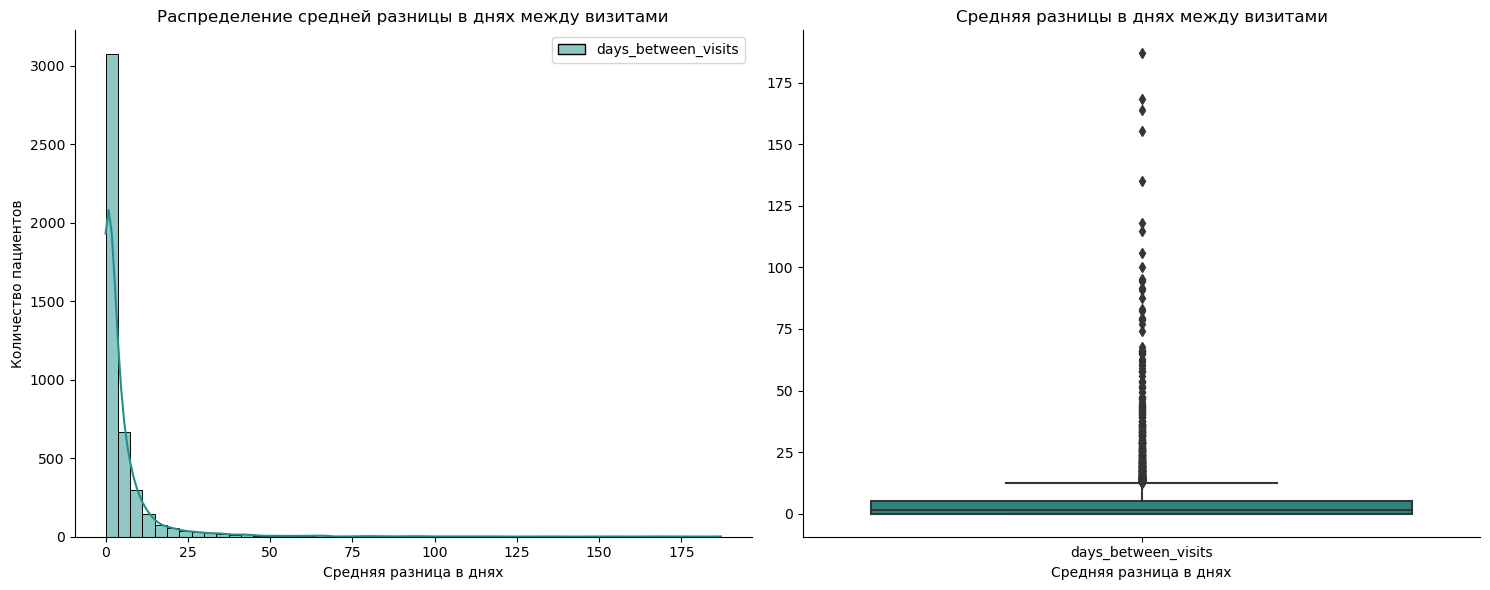

In [61]:
# Визуализируем данные по среднему количеству дней между визитами
average_days_data = average_days.to_frame()

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Построение гистограммы
sns.histplot(data=average_days_data, bins=50, kde=True, ax=axes[0], palette='viridis')
axes[0].set_title('Распределение средней разницы в днях между визитами')
axes[0].set_xlabel('Средняя разница в днях')
axes[0].set_ylabel('Количество пациентов')

# Построение боксплота
sns.boxplot(data=average_days_data, ax=axes[1], palette='viridis')
axes[1].set_title('Cредняя разницы в днях между визитами')
axes[1].set_xlabel('Средняя разница в днях')

sns.despine()
plt.tight_layout()

plt.show()

В медицинских учреждениях пациенты могут обращаться за разными видами услуг, и интервалы между посещениями могут значительно различаться в зависимости от характера оказываемых услуг и здоровья пациентов. Сложно определить на наших данных период, после которого пациент может считаться ушедшим в отток. Анализ данных и графики показывают, что у большинства пациентов среднее окно между посещениями - 5 дней. Также на графике мы видим, что есть немало людей, у которых среднее окно гораздо длительнее. Используем данные боксплота и возьмем окно - 14 дней, после чего для пациентов, если они не вернулись, будем считать, что они ушли в отток.

In [62]:
# Создадим столбец churn, запишем тех, кто посетил клинику один раз  и тех, у кого между визитами прошло менее 
# 28 дней, как 1 (попали в отток), остальных как 0 (не попали в отток)
data['churn'] = data.apply(lambda row: 1 if (row['record_id'] == 1) | 
                                       (average_days[row['insured']] <= 14) else 0, axis=1)

In [63]:
print(f'Отток составляет: {round(len(data.query("churn==1"))/len(data)*100,1)}%')

Отток составляет: 96.2%


**Вывод:**

В рамках данного этапа категоризировали данные и добавили следующие слолбцы:
- category_name содержит категории: Анализы, Инструментальные исследования, Физиотерапия, Вакцинация, Процедурный кабинет, Хирургия, Прием, Другое;
- category_age содержит данные по возрастным катгориям: 0-9, 10-19, 20-29, 30-39, 40-49, 40-59, 60-69, 70+;
- service_year содержит год посещения клиники;
- service_month содержит месяц посещения клиники;
- price_for_one_service содержит среднюю стоимость одной услуги в течении дня;
- season содержит данные по сезонности: зима, весна, лето, осень;
- churn содержит данные об оттоке клиентов: 0-остались, 1- ушли.

<a id="4"></a>

### Исследовательский анализ данных

<a id="5"></a>

#### Матрица корреляций

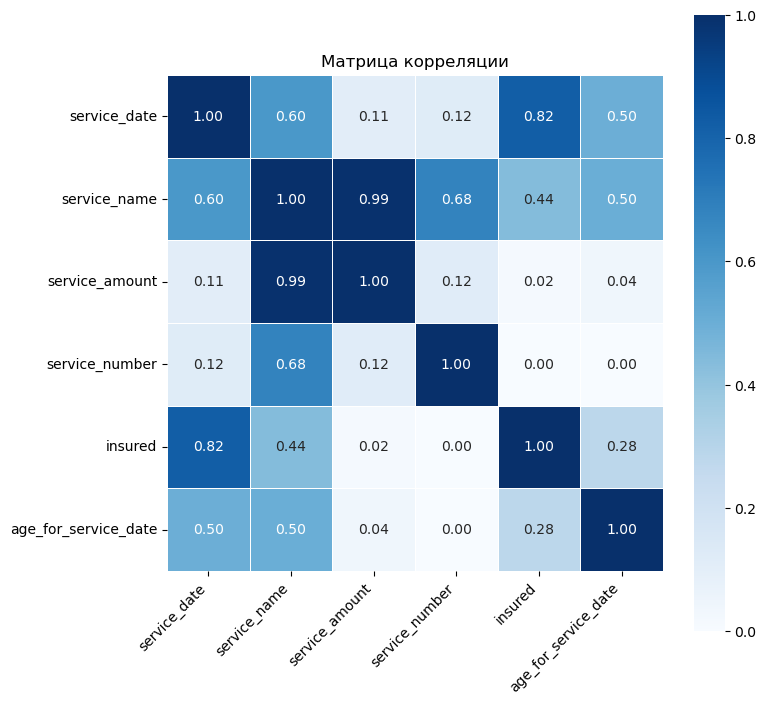

In [64]:
# Вычисляем phik matrix для заданных столбцов
selected_cols = ['service_date', 'service_name', 'service_amount', 'service_number', 'insured',
                 'age_for_service_date']

matrix = data[selected_cols].phik_matrix(interval_cols=['service_amount', 'service_number', 'insured', 
                                                        'age_for_service_date'])
# Строим тепловую карту
plt.figure(figsize=(8, 8))
sns.heatmap(matrix, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5, square=True)
plt.title('Матрица корреляции')
plt.xticks(rotation=45, ha='right')

plt.show()

<a id="6"></a>

Судя по матрице видим высокую мультиколлинеарную зависимость у столбцов service_name и service_amount, insured и service_date, service_name и service_number и др. Из интересного, зависимость наименования услуги от возраста довольно немаленькая - 0.5.

#### Изменение выручки в 2022 году относительно 2021 года

Ранее мы уже выяснили, что у нас есть данные с 2021-01-03 по 2022-08-31, т.е. за 12 месяцев 2021 года и за 8 месяцев 2022 года.

In [65]:
# Посчитаем выручку за вышеуказанные периоды
data_amount_per_year = data.pivot_table(index = ['service_year'], 
                                        values = ['service_amount'], 
                                        aggfunc = 'sum').reset_index()

data_amount_per_year.style.background_gradient()

,service_year,service_amount
0,2021,50561671
1,2022,48986662


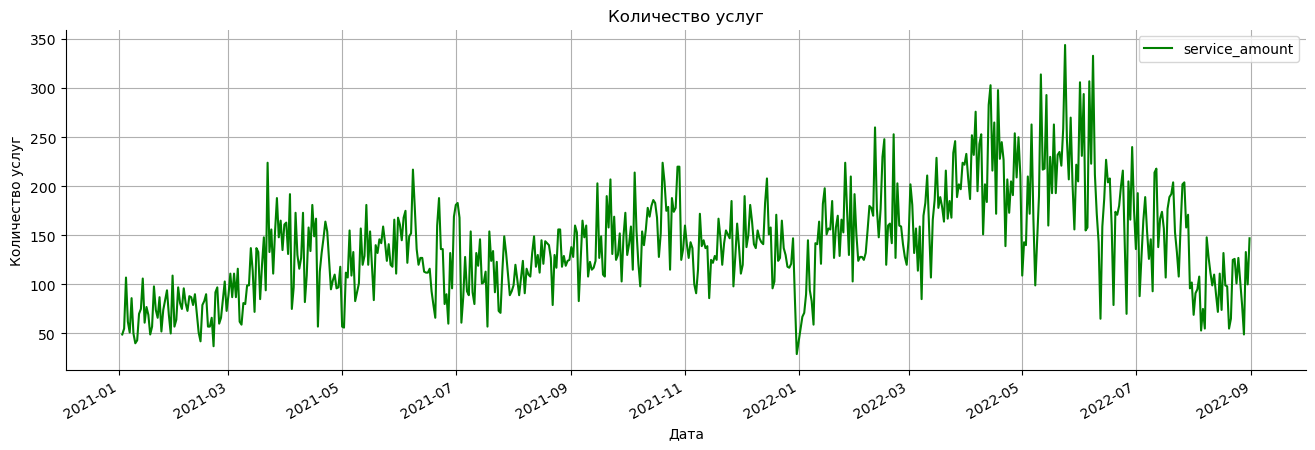

In [66]:
# Посмотрим на общую динамику по количеству услуг за весь период
data.pivot_table(index=['service_date'],
                values='service_amount', 
                aggfunc='count').plot(figsize=(16,5), grid=True, color='green', title="Количество услуг", 
                                      xlabel='Дата', ylabel='Количество услуг')

sns.despine()

plt.show()

Выручка за 2021 год немного больше, чем за 2022, но за 2021 год и данных в датасете больше. На графике видна недельная цикличность, а также общее увеличение услуг весной 2022 года, низкая активность в начале 2021 года. Посмотрим данные по совпадающим месяцам.

In [67]:
# Данные за 8 месяцев 2021 года
data_amount_month_21 = (data
                        .query('service_month in [1,2,3,4,5,6,7,8] & service_year == 2021')
                        .groupby(['service_year','service_month'])
                        .agg({'service_amount':'sum'})
                        .reset_index()
                        .rename(columns={'service_amount':'amount_month'}))

In [68]:
# Данные за те же 8 месяцев 2022 года
data_amount_month_22 = (data
                        .query('service_month in [1,2,3,4,5,6,7,8] & service_year ==2022')
                        .groupby(['service_year','service_month'])
                        .agg({'service_amount':'sum'})
                        .reset_index()
                        .rename(columns={'service_amount':'amount_month'}))

In [69]:
# Объединим данные за первые 8 месяцев обоих лет в одну таблицу
data_amount_month = (data_amount_month_21
                     .merge(data_amount_month_22, on='service_month', how='left')
                     .drop(columns=['service_year_x', 'service_year_y'])
                     .rename(columns={'amount_month_x': 'amount_21', 'amount_month_y': 'amount_22'}))

data_amount_month.style.background_gradient()

,service_month,amount_21,amount_22
0,1,2265931,4800320
1,2,2379125,5298235
2,3,3927248,6451060
3,4,4380487,8035080
4,5,4298978,7588110
5,6,4522585,6879580
6,7,3872209,6216498
7,8,4310989,3717779


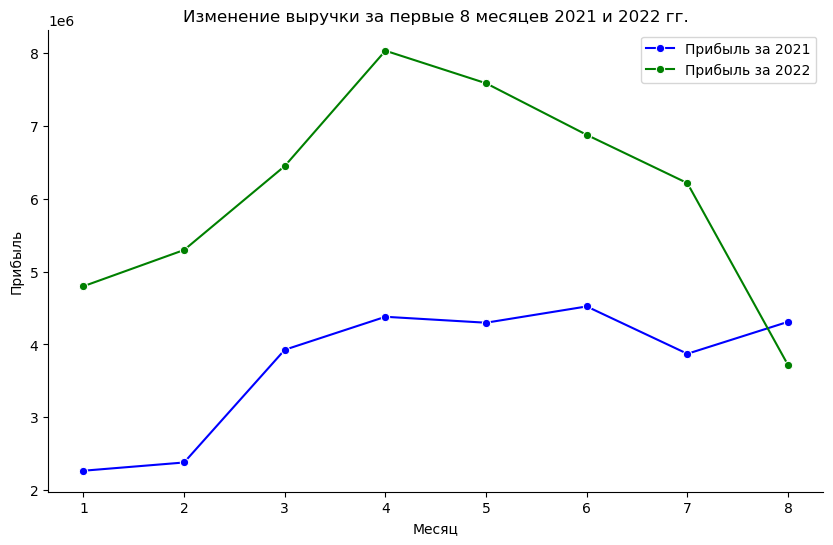

In [70]:
# Построим график изменения выручки клиники за первые 8 месяцев 2021 и 2022 года
plt.figure(figsize=(10, 6))

# Задаем данные для графика
x = data_amount_month['service_month']
y1 = data_amount_month['amount_21']
y2 = data_amount_month['amount_22']

# Строим графики
sns.lineplot(x=x, y=y1, label='Прибыль за 2021', marker='o', linestyle='-', color='blue')
sns.lineplot(x=x, y=y2, label='Прибыль за 2022', marker='o', linestyle='-', color='green')

plt.xlabel('Месяц')
plt.ylabel('Прибыль')
plt.title('Изменение выручки за первые 8 месяцев 2021 и 2022 гг.')
plt.legend()
plt.grid(False)

sns.despine()

plt.show()

In [71]:
# Считаем выручку за первые 8 месяцев каждого года
income_21 = data_amount_month['amount_21'].sum()
display(f'Выручка за январь-август 2021 года: {income_21}')

income_22 = data_amount_month['amount_22'].sum()
display(f'Выручка за январь-август 2022 года: {income_22}')

'Выручка за январь-август 2021 года: 29957552'

'Выручка за январь-август 2022 года: 48986662'

In [72]:
# Расчет роста выручки в процентах
income_increase_percentage = ((income_22 - income_21) / income_21) * 100

# Вывод результата
if income_increase_percentage > 0:
    print(f"Выручка выросла на {income_increase_percentage:.1f}%.")
elif income_increase_percentage < 0:
    print(f"Выручка упала на {-income_increase_percentage:.1f}%.")
else:
    print('Выручка осталась примерно на том же уровне.')

Выручка выросла на 63.5%.


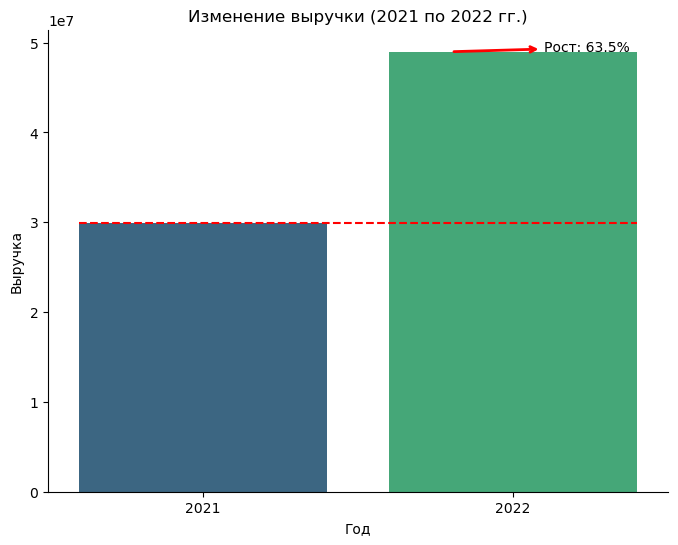

In [73]:
# Графическое представление с акцентом на рост
plt.figure(figsize=(8, 6))

colors = ['red' if income_increase_percentage < 0 else 'green', 'blue' if income_increase_percentage == 0 else 
          'green']

# Строим график
sns.barplot(x=['2021', '2022'], y=[income_21, income_22], palette='viridis')

plt.xlabel('Год')
plt.ylabel('Выручка')
plt.title('Изменение выручки (2021 по 2022 гг.)')

sns.despine()

# Добавим акцент на рост
if income_increase_percentage > 0:
    growth_label = f"Рост: {income_increase_percentage:.1f}%"
    plt.annotate(growth_label, xy=(0.8, income_22), xytext=(1.1, income_22),
                 arrowprops=dict(arrowstyle='<-', lw=2, color='red'))

# Добавим пунктирную линию по верхней границе столбца 2021
plt.axhline(y=income_21, color='red', linestyle='--', xmin=0.05, xmax=0.95)

plt.show()

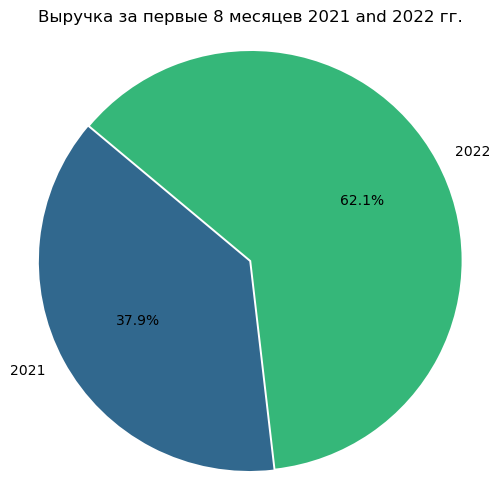

In [74]:
# Построим круговую диаграмму, показывающую размер выручки за первые 8 месяцев в 2021 и в 2022 годах
plt.figure(figsize=(6, 6))

# Задаем данные для графика
labels = ['2021', '2022']
sizes = [data_amount_month['amount_21'].sum(), data_amount_month['amount_22'].sum()]
colors = sns.color_palette('viridis', len(labels))

# Строим график
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, explode = (0.01, 0))

plt.title('Выручка за первые 8 месяцев 2021 and 2022 гг.')
plt.axis('equal')

plt.show()

На графиках отлично видно, как выросла выручка в сравнении 2021го с 2022ым годом помесячно (с января по август). В цифрах: с почти 30 млн. рублей в 2021 году до почти 49 млн. рублей в 2022 году. В 2021 году прибыль планомерно росла до июня, в июле мы видим небольшой спад и снова рост. Пик же роста в 2022 году пришелся на апрель, с июля мы видим резкое падение.

In [75]:
# Посчитаем выручку за сентябрь-декабрь 2021 года
data_income_sep_dec_21 = (data
                          .query('service_month in [9,10,11,12]')
                          .groupby(['service_year'])
                          .agg({'service_amount':'sum'})
                          .reset_index())

data_income_sep_dec_21

,service_year,service_amount
0,2021,20604119


In [76]:
# Посчитаем разницу между выручкой за первые 8 месяцев 2021 года и за последние 4
data_diff_income_21 = round(data_income_sep_dec_21['service_amount'] / data_amount_per_year.\
query('service_year == 2021')['service_amount'] * 100, 1)

data_diff_income_21

0    40.8
Name: service_amount, dtype: float64

Выручка за последние 4 месяца 2021 года составляет 40.8% от общегодовой. Что-то явно поменялось за эти 4 месяца. Возможно было увеличение цен (индексация) или рост количества пациентов, или другие причины.

<a id="7"></a>

#### Расчет среднего чека

In [77]:
# Посчитаем средний чек по категориям в 2021 и 2022 годах
mean_bill_cat  = (data
                  .groupby('category_name')
                  .agg({'service_amount':'sum', 'insured':'count'})
                  .reset_index())

mean_bill_cat['mean_bill'] = round(mean_bill_cat['service_amount'] / mean_bill_cat['insured'])   

mean_bill_cat.style.background_gradient()

,category_name,service_amount,insured,mean_bill
0,Анализы,16596924,28670,579.000000
1,Вакцинация,92759,29,3199.000000
2,Другое,543798,585,930.000000
3,Инструментальные исследования,23725388,14797,1603.000000
4,Прием,39063677,26414,1479.000000
5,Процедурный кабинет,2617335,2908,900.000000
6,Физиотерапия,15806991,11422,1384.000000
7,Хирургия,1101461,544,2025.000000


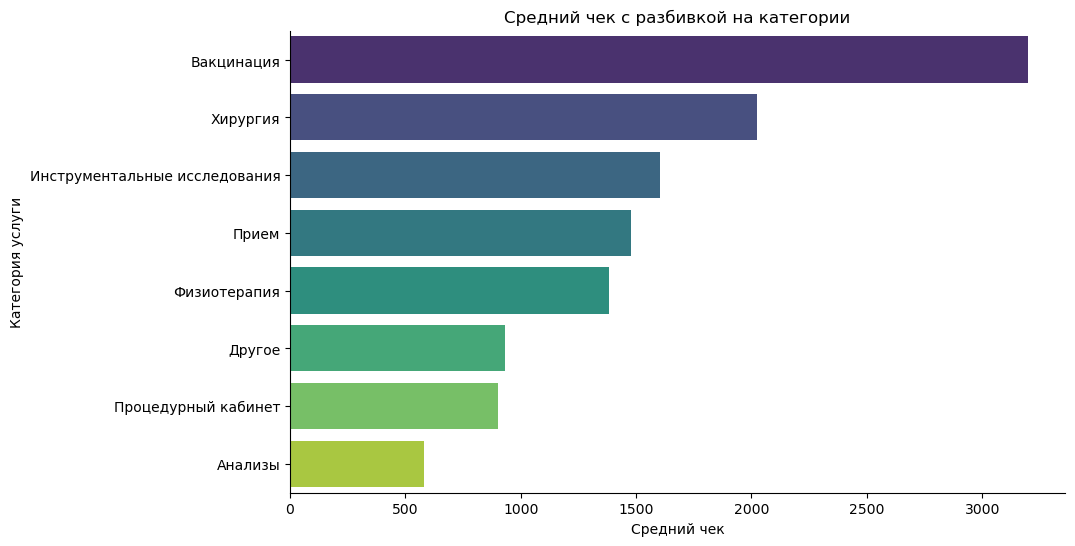

In [78]:
# Построим график по среднему чеку с разбивкой по категориям
mean_bill_sorted = mean_bill_cat.sort_values(by='mean_bill', ascending=False)

plt.figure(figsize=(10, 6)) 

# Строим график
sns.barplot(x='mean_bill', y='category_name', data=mean_bill_sorted, palette='viridis')

plt.xlabel('Средний чек')
plt.ylabel('Категория услуги')
plt.title('Средний чек с разбивкой на категории')
plt.grid(False)

sns.despine()

plt.show()

In [79]:
# Посчитаем средний чек по категориям за первые 8 месяцев  2021 года
mean_bill_21  = (data
                 .query('service_year == 2021 & service_month in [1,2,3,4,5,6,7,8]')
                 .groupby('category_name')
                 .agg({'service_amount':'sum', 'insured':'count'})
                 .reset_index())

mean_bill_21['mean_bill'] = round(mean_bill_21['service_amount'] / mean_bill_21['insured'])  

In [80]:
# Посчитаем средний чек по категориям в 2022 году
mean_bill_22  = (data
                 .query('service_year == 2022')
                 .groupby('category_name')
                 .agg({'service_amount':'sum', 'insured':'count'})
                 .reset_index())

mean_bill_22['mean_bill'] = round(mean_bill_22['service_amount'] / mean_bill_22['insured']) 

In [81]:
# Объединим данные
mean_bill_cat = (mean_bill_21[['category_name', 'mean_bill']]
                 .merge(mean_bill_22[['category_name', 'mean_bill']], on='category_name', how='left')
                 .rename(columns={'mean_bill_x':'2021', 'mean_bill_y':'2022'})
                 .fillna(0))

mean_bill_cat['diff, %'] = round(mean_bill_cat['2022']/mean_bill_cat['2021']*100, 1)

mean_bill_cat.style.background_gradient()   

,category_name,2021,2022,"diff, %"
0,Анализы,569.000000,590.000000,103.700000
1,Вакцинация,3167.000000,3446.000000,108.800000
2,Другое,1045.000000,811.000000,77.600000
3,Инструментальные исследования,1546.000000,1638.000000,106.000000
4,Прием,1424.000000,1516.000000,106.500000
5,Процедурный кабинет,809.000000,973.000000,120.300000
6,Физиотерапия,1389.000000,1363.000000,98.100000
7,Хирургия,2114.000000,2045.000000,96.700000


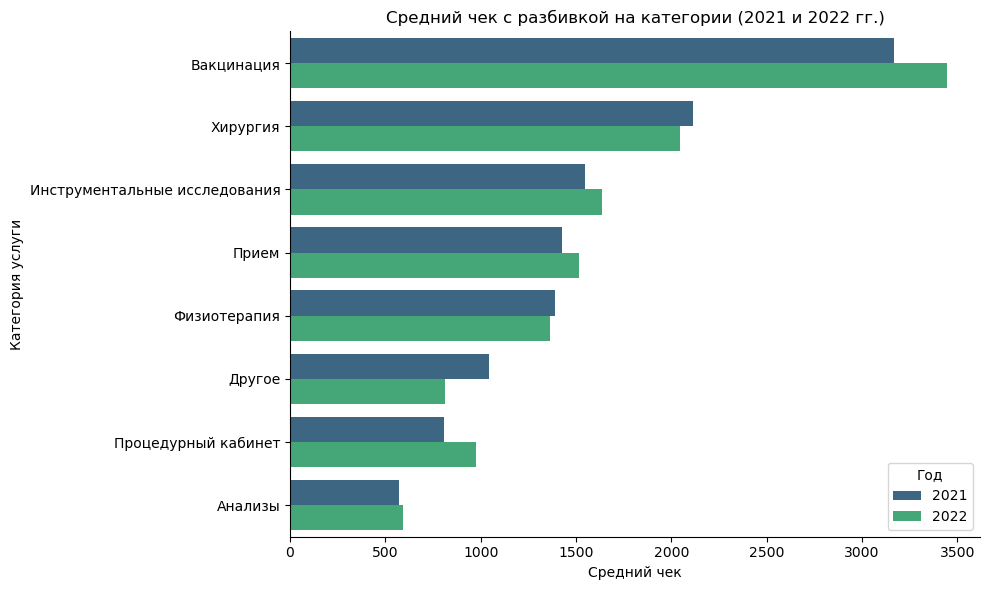

In [82]:
# Построим график разницы средних чеков за 8 месяцев каждого года по категориям
mean_bill_cat_sorted = mean_bill_cat.sort_values(by='2021', ascending=False)

melted_data = pd.melt(mean_bill_cat_sorted, id_vars='category_name', value_vars=['2021', '2022'],
                      var_name='Год', value_name='Средний чек')

plt.figure(figsize=(10, 6))

# Cтроим график
sns.barplot(data=melted_data, x='Средний чек', y='category_name', hue='Год', orient='h', palette='viridis')

plt.xlabel('Средний чек')
plt.ylabel('Категория услуги')
plt.title('Средний чек с разбивкой на категории (2021 и 2022 гг.)')
sns.despine()
plt.grid(False)
plt.tight_layout()

plt.show()

Средний чек вырос в 2022 году практически повсем категориям, кроме хирургии и физиотерапии и категории другое.

In [83]:
# Посчитаем средний чек по категориям за последние 4 месяца 2021 года
mean_bill_21_end  = (data
                     .query('service_year == 2021 & service_month in [9,10,11,12]')
                     .groupby('category_name')
                     .agg({'service_amount':'sum', 'insured':'count'})
                     .reset_index())

mean_bill_21_end['mean_bill_21_end'] = round(mean_bill_21_end['service_amount'] / mean_bill_21_end['insured'])    
mean_bill_21_end = mean_bill_21_end.sort_values(by='mean_bill_21_end', ascending=False)

mean_bill_21_end.style.background_gradient()

,category_name,service_amount,insured,mean_bill_21_end
1,Вакцинация,5846,2,2923.000000
7,Хирургия,186768,102,1831.000000
3,Инструментальные исследования,4671877,2913,1604.000000
4,Прием,8057379,5466,1474.000000
6,Физиотерапия,3720958,2618,1421.000000
2,Другое,112858,113,999.000000
5,Процедурный кабинет,513694,567,906.000000
0,Анализы,3334739,5875,568.000000


Итак, мы видим, что дороже всего пациентам обошлись услуги из категорий "Вакцинация", "Хирургия", "Другое" и "Инструментальные исследования" (УЗИ, МРТ, КТ и тд.) и в 2021 году, и в 2022 году. 

Считаю, что считать средний чек по дате не совсем корректно, т.к. кто-то мог потратить в этот день 147 р. на анализ, а кто-то 10 тыс. р. на МРТ, но все равно попробуем.

In [84]:
# Посчитаем средний чек по дате визита  в 2021 году
mean_bill_21_date  = (data
                      .query('service_year == 2021 & service_month in [1,2,3,4,5,6,7,8]')
                      .groupby('service_date')
                      .agg({'service_amount':'sum', 'insured':'count'})
                      .reset_index())

mean_bill_21_date['mean_bill_date'] = round(mean_bill_21_date['service_amount'] / mean_bill_21_date['insured'])

In [85]:
# Посчитаем средний чек по дате визита  в 2022 году
mean_bill_22_date  = (data
                      .query('service_year == 2022')
                      .groupby('service_date')
                      .agg({'service_amount':'sum', 'insured':'count'})
                      .reset_index())

mean_bill_22_date['mean_bill_date'] = round(mean_bill_22_date['service_amount'] / mean_bill_22_date['insured'])   

In [86]:
# Объединим данные
mean_bill_date = (mean_bill_21_date[['service_date', 'mean_bill_date']]
                  .merge(mean_bill_22_date[['service_date', 'mean_bill_date']], on='service_date', how='outer')
                  .rename(columns={'mean_bill_date_x':'2021', 'mean_bill_date_y':'2022'})
                  .fillna(0))

mean_bill_date     

,service_date,2021,2022
0,2021-01-03,789.0,0.0
1,2021-01-04,1152.0,0.0
2,2021-01-05,972.0,0.0
3,2021-01-06,931.0,0.0
4,2021-01-07,1141.0,0.0
...,...,...,...
475,2022-08-27,0.0,1055.0
476,2022-08-28,0.0,1261.0
477,2022-08-29,0.0,1161.0
478,2022-08-30,0.0,1297.0


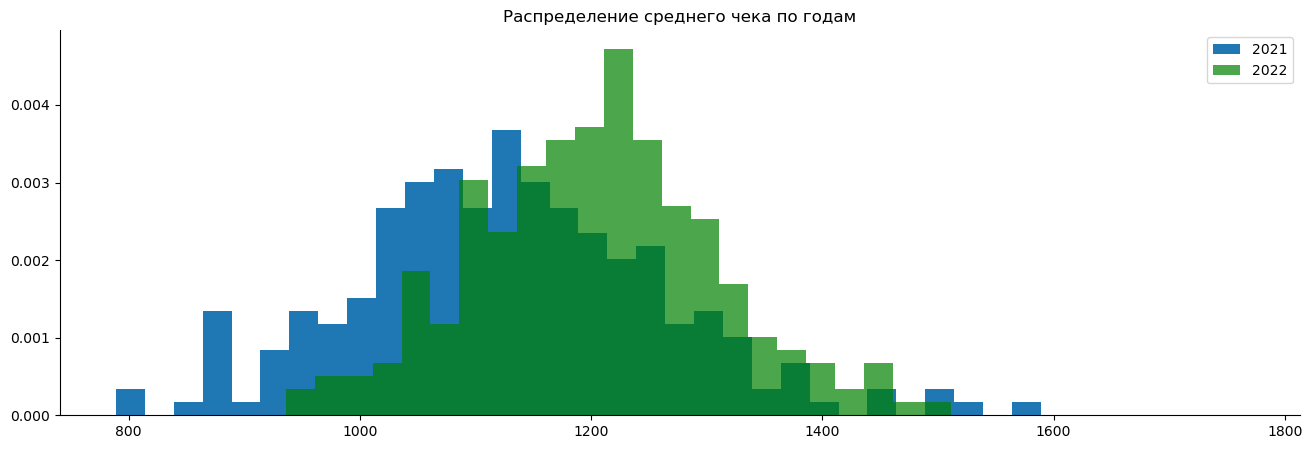

In [87]:
# Построим гистограммы для средних чеков по годам
plt.figure(figsize=(10, 6))

# Исключим чеки ниже 200 р.
tmp2021 = mean_bill_date[(mean_bill_date['2021'] != 0)]['2021']
tmp2022 = mean_bill_date[(mean_bill_date['2022'] != 0)]['2022']

tmp2021.hist(bins=np.arange(tmp2021.min(), tmp2021.max(), 25), figsize=(16,5), label='2021', density=True)
tmp2022.hist(bins=np.arange(tmp2022.min(), tmp2022.max(), 25), figsize=(16,5), label='2022', alpha=0.7, 
             density=True, color='green')
plt.legend()
plt.title('Распределение среднего чека по годам')
plt.grid(False)

sns.despine()

plt.show()

На гистограмме мы видим, что в 2022 году средний чек вырос и, не считая большого количества дешевых услуг (до 200 р.) в обоих годах, средний чек в 2022 году стартует от примерно 950 р., в отличие от 800 р. в  2021 году. 

In [88]:
# Расчет средних чеков по годам
display(round(mean_bill_date[mean_bill_date['2021'] != 0]['2021'].mean(), 1)) 
display(round(mean_bill_date[mean_bill_date['2022'] != 0]['2022'].mean(), 1))

1131.6

1205.5

Можно сказать, что в основной массе, средний чек в 2021 году составляет около 1132 рублей, в 2022 году уже около 1201 р.

<a id="8"></a>

#### Расчет продуктовых метрик

##### Monthly Active Users (MAU)

,service_year,service_month,MAU
2,2021,3,446
17,2022,6,738
19,2022,8,359


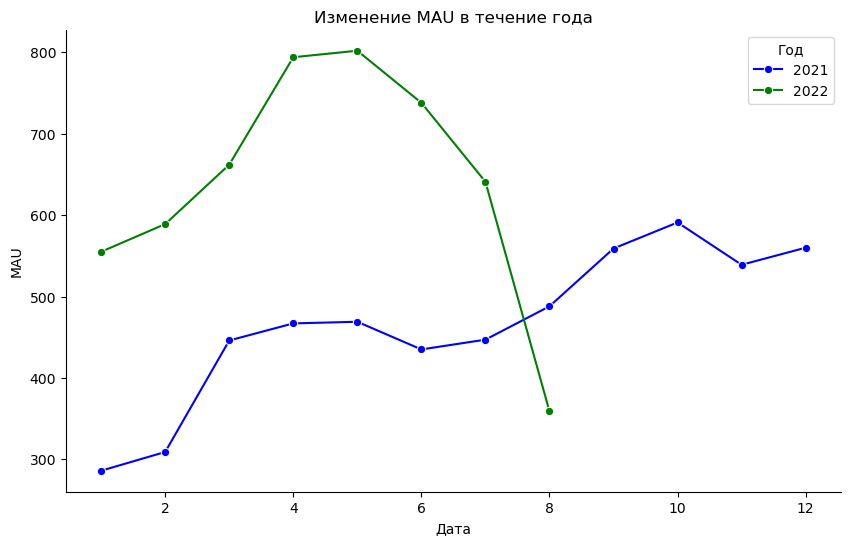

In [89]:
# Создадим копию датасета
tmp = data.copy()

# Рассчитаем метрику MAU - количество уникальных пользователей клиники в месяц
tmp_mau = (tmp
           .groupby(['service_year', 'service_month'])
           .agg(MAU=('insured','nunique'))
           .reset_index())

display(tmp_mau.sample(3))

# Построим графики распределения количества уникальных пользователей по месяцам
plt.figure(figsize=(10, 6))

for i, year in enumerate(tmp_mau['service_year'].unique()):
    color = 'blue' if i == 0 else 'green'
    sns.lineplot(data=tmp_mau[tmp_mau['service_year'] == year], x='service_month', y='MAU', linestyle='-', 
                 marker='o', label=f'{year}', color=color)
plt.title('Изменение MAU в течение года')
plt.xlabel('Дата')
plt.ylabel('MAU')
plt.grid(False)
plt.legend(title='Год')

sns.despine()

plt.show()

В 2021 году количество уникальных пользователей ежемесячно плавно растет с незначительными откатами в июне и ноябре, в 2022 же году количество уникальных пациентов в месяц начинает уменьшаться примерно с мая. Можно это, конечно, связать с сезонностью или уменьшением количества новых пациентов, но 2021 году такого явления не наблюдается. Возможно, причина станет ясна в результате дальнейшего анализа.

##### Customer Retention Rate (CRR)

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date,category_name,category_age,service_year,service_month,price_for_one_service,season,days_between_visits,churn,week,first_week,lifetime
78533,32631790003,2022-05-19,Общий анализ мочи,450,1,1072726,женский,37,Анализы,30-39,2022,5,450.0,весна,1.0,1,2022-05-16/2022-05-22,2022-05-16/2022-05-22,1.0
38021,31112003003,2021-07-24,В/мышечная инъекция (за 1 процедуру без стоимости лекарств),556,2,363072,женский,24,Процедурный кабинет,20-29,2021,7,278.0,лето,0.0,1,2021-07-19/2021-07-25,2021-07-19/2021-07-25,1.0
81435,32801404003,2022-06-10,"Прием невролога, первичный",1540,1,881236,мужской,26,Прием,20-29,2022,6,1540.0,лето,0.0,1,2022-06-06/2022-06-12,2022-06-06/2022-06-12,1.0


,first_week,lifetime,lifetime_users,total_users,rr
1607,2021-06-21/2021-06-27,44.0,1,38,0.026316
2972,2022-03-21/2022-03-27,6.0,14,53,0.264151
3181,2022-06-06/2022-06-12,10.0,2,48,0.041667


,lifetime,year,rr
69,36.0,2021,0.050586
114,81.0,2021,0.020408
95,62.0,2021,0.037143


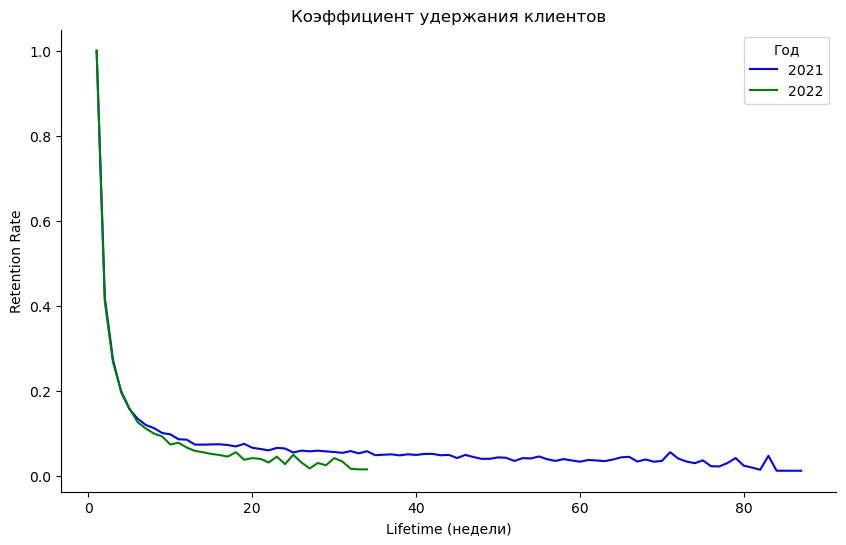

In [90]:
# Выделение недель из даты
tmp['week'] = tmp['service_date'].dt.to_period('W')

# Находим первую неделю для каждого клиента - это будут когорты
cohorts = tmp.groupby('insured').agg(first_week=('week','min')).reset_index()

# Присоединяем первую неделю и считаем лайфтайм каждой услуги:
tmp = (tmp
       .merge(cohorts, on='insured')
       .assign(lifetime=lambda x: np.floor(((x['week'] - x['first_week']).apply(lambda y: y.n) + 1))))

display(tmp.sample(3))

# Cчитаем для каждой когорты количество пользователей на нулевой лайфтайм (размер когорт)
tmp_ch_size = tmp.groupby('first_week').agg(total_users=('insured','nunique')).reset_index()

# Группируем данные по лайфтайму и первой неделе, добавляем данные о размере когорт и считаем удержание
tmp_rr = tmp.groupby(['first_week','lifetime']).agg(lifetime_users=('insured','nunique')).reset_index()
tmp_rr = (tmp_rr
          .merge(tmp_ch_size, on='first_week')
          .assign(rr=lambda x: x['lifetime_users']/x['total_users']))

display(tmp_rr.sample(3))

# Выделим год и подсчитаем среднее значение по удержанию по сегментам лайфтама
tmp_rr = (tmp_rr
          .assign(year=lambda x: x['first_week'].dt.year)
          .groupby(['lifetime', 'year'])['rr'].mean().reset_index())

display(tmp_rr.sample(3))

# Построим графики средней выручки на одного пользователя по годам
plt.figure(figsize=(10, 6))

for i, year in enumerate(tmp_rr['year'].unique()):
    color = 'blue' if i == 0 else 'green'
    sns.lineplot(data=tmp_rr[tmp_rr['year'] == year], x='lifetime', y='rr', linestyle='-', label=f'{year}', 
                 color=color)
plt.title('Коэффициент удержания клиентов')
plt.xlabel('Lifetime (недели)')
plt.ylabel('Retention Rate')
plt.legend(title='Год')

sns.despine()

plt.show()

На графике видно, что в целом у клиентов, которые пришли в клинику в 2021 году, удержание в первые недели выше. Конечно, данные за 2022 год неполные, но по имеющимся данным картина именно такая. 

##### Churn rate

Найдем коэффициент оттока двумя способами. Первый, по сути, представляет из себя разницу между 1 и удержанием. В данном случае, это все же не совсем корректно, так как отток не происходит разово. Во втором случае, используем наш новый столбец churn. Проанализируем различия.

,first_week,lifetime,lifetime_users,total_users,churn
2673,2021-12-27/2022-01-02,8.0,1,21,0.952381
963,2021-04-05/2021-04-11,21.0,5,54,0.907407
1342,2021-05-24/2021-05-30,5.0,9,50,0.820000


,lifetime,year,churn
58,30.0,2021,0.942988
22,12.0,2021,0.914034
47,24.0,2022,0.971450


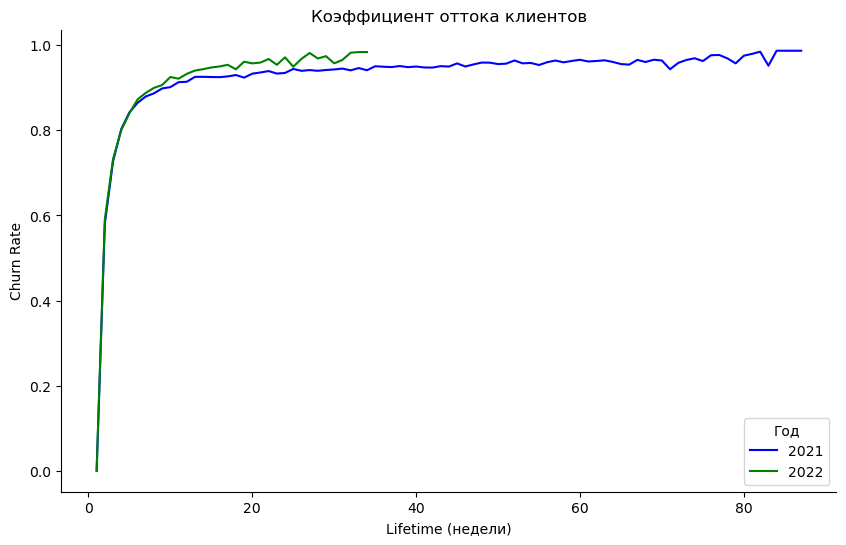

In [91]:
# Первый способ
# Группируем данные по лайфтайму и первой неделе, добавляем данные о размере когорт и считаем отток
tmp_churn = tmp.groupby(['first_week','lifetime']).agg(lifetime_users=('insured','nunique')).reset_index()
tmp_churn = (tmp_churn
             .merge(tmp_ch_size, on='first_week')
             .assign(churn=lambda x: (x['total_users']-x['lifetime_users'])/x['total_users']))

display(tmp_churn.sample(3))

# Выделим год и подсчитаем среднее значение по удержанию по сегментам лайфтама
tmp_churn = (tmp_churn
             .assign(year=lambda x: x['first_week'].dt.year)
             .groupby(['lifetime', 'year'])['churn'].mean().reset_index())

display(tmp_churn.sample(3))

# Построим графики средней выручки на одного пользователя по годам
plt.figure(figsize=(10, 6))

for i, year in enumerate(tmp_churn['year'].unique()):
    color = 'blue' if i == 0 else 'green'
    sns.lineplot(data=tmp_churn[tmp_churn['year'] == year], x='lifetime', y='churn', linestyle='-', 
                 label=f'{year}', color=color)
plt.title('Коэффициент оттока клиентов')
plt.xlabel('Lifetime (недели)')
plt.ylabel('Churn Rate')
plt.legend(title='Год')

sns.despine()

plt.show()

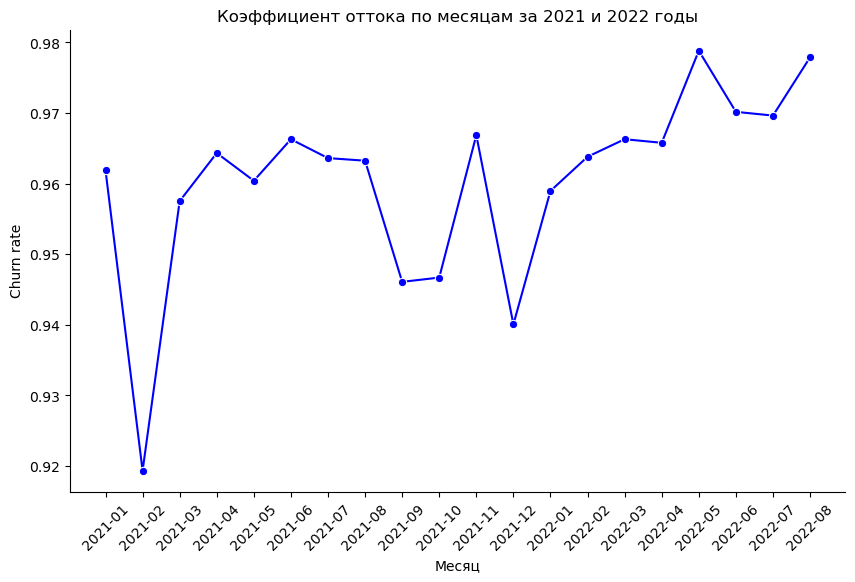

In [92]:
# Второй способ
# Выделяем месяц из даты
tmp['month'] = tmp['service_date'].dt.to_period('M').astype(str)

# Построим график
plt.figure(figsize=(10, 6))
sns.lineplot(data=tmp.sort_values(by='month'), x='month', y='churn', linestyle='-', marker='o', 
             color='blue', errorbar=None)
plt.title('Коэффициент оттока по месяцам за 2021 и 2022 годы')
plt.xlabel('Месяц')
plt.ylabel('Churn rate')
plt.xticks(rotation=45)

sns.despine()

plt.show()

Обе визуализации показывают, что отток в 2022 году был в целом выше, чем в 2021. В феврале и декабре 2021 отток был наименьшим, в мае и августе 2022 - самым высоким. Возможно это связано с эпидемиологической сезонностью, зимой люди болеют чаще, поэтому отток был низким, в летние месяцы отток высокий из-за отпусков, и снижения заболеваемости, например, ОРВИ.

##### Average revenue per user (ARPU)

,service_year,service_month,amount_total,insured_cnt,ARPU
8,2021,9,4782859,559,8556.0
4,2021,5,4298978,469,9166.0
5,2021,6,4522585,435,10397.0


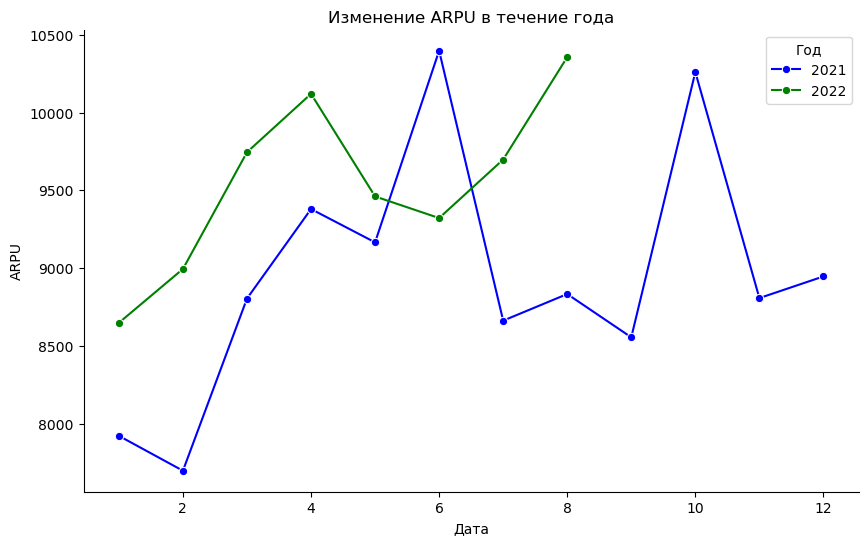

In [93]:
# Рассчитаем среднюю выручку на одного пользователя 
tmp_arpu = (tmp
            .groupby(['service_year', 'service_month'])
            .agg(amount_total=('service_amount','sum'), insured_cnt=('insured','nunique'))
            .reset_index())

tmp_arpu['ARPU'] = round(tmp_arpu['amount_total'] / tmp_arpu['insured_cnt'])

display(tmp_arpu.sample(3))

# Построим графики средней выручки на одного пользователя по годам
plt.figure(figsize=(10, 6))

for i, year in enumerate(tmp_arpu['service_year'].unique()):
    color = 'blue' if i == 0 else 'green'
    sns.lineplot(data=tmp_arpu[tmp_arpu['service_year'] == year], x='service_month', y='ARPU', linestyle='-', 
                 label=f'{year}', marker='o', color=color)
plt.title('Изменение ARPU в течение года')
plt.xlabel('Дата')
plt.ylabel('ARPU')
plt.grid(False)
plt.legend(title='Год')

sns.despine()

plt.show()

До мая каждого года графики практически симметричны (правда, в 2022 году выручка на одного клиента повыше), а дальше графики расходятся. В 2021 году выручка с одного клиента максимальная в июне, затем резко падает и снова уходит в пике только к октябрю. В 2022 году выручка начинает расти с июня.

**Выводы:**
- Рассчитали изменение прибыли в 2022 году по сравнению с 2021 годом:
  - Выручка за 8 месяцев 2022 года на 19 млн. рублей больше выручки за аналогичные месяцы 2021 года; 
  - Прибыль за последние 4 месяца 2021 года составляет 40.8% от общегодовой прибыли за этот год. Причины этого попробуем определить в дальнейшем исследовании;
  - Цены на популярные услуги выросли в октябре 2021 года и в июле 2022 года.
- Рассчитали средние чеки по категориям и по дням:
  - Самые высокие средние чеки в категории "Вакцинация", "Хирургия", "Другое", "Инструментальные исследования";
  - В 2022 году средний чек по дате вырос и стартует от, примерно, 950 р., в отличие от 800 р. в 2021 году.
- Рассчитали продуктовые метрики MAU, CRR, Churn rate, ARPU:
  - MAU: в 2021 году число уникальных посетителей ежемесячно плавно растет с незначительными откатами в июне и ноябре, в 2022 же году количество уникальных пациентов уменьшается примерно с мая;
  - CRR: у клиентов, которые пришли в клинику в 2021 году удержание в первые недели выше;
  - Churn rate: отток в 2022 году был в целом выше, чем в 2021. В феврале и декабре 2021 отток был наименьшим, в мае и августе 2022 - самым высоким;
  - ARPU: до мая каждого года выручка с клиента растет симметрично по обоим годам, в 2021 году выручка с одного клиента максимальная в июне, затем резко падает и снова уходит в пике только к октябрю. В 2022 году выручка начинает расти как раз с июня.

<a id="9"></a>

### Сегментация пользователей (RFM анализ)

In [94]:
# Рассчитываем параметры RFM
current_date = datetime.now()

rfm_data = (data
            .groupby('insured')
            .agg({
                'service_date': lambda x: (current_date - x.max()).days,  # Recency
                'record_id': lambda x: len(x),  # Frequency
                'service_amount': lambda x: x.sum()  # Monetary
            }).reset_index())

# Переименовываем столбцы
rfm_data.columns = ['insured', 'recency', 'frequency', 'monetary']

# Выводим результаты
print(rfm_data.head())

# Сегментация клиентов
rfm_data['recency_score'] = pd.qcut(rfm_data['recency'], q=4, labels=[4, 3, 2, 1])
rfm_data['frequency_score'] = pd.qcut(rfm_data['frequency'], q=4, labels=[1, 2, 3, 4])
rfm_data['monetary_score'] = pd.qcut(rfm_data['monetary'], q=4, labels=[1, 2, 3, 4])

# Общий RFM Score
rfm_data['RFM'] = rfm_data['recency_score'].astype(str) + rfm_data['frequency_score'].astype(str) +\
rfm_data['monetary_score'].astype(str)

# Выводим результаты сегментации
print(rfm_data.head())

# Анализ сегментов
segment_counts = rfm_data['RFM'].value_counts().sort_index()
print('Количество клиентов в каждом сегменте:')
print(segment_counts)

# Анализ средних значений для каждого сегмента
average_values = (rfm_data
                  .groupby('RFM')
                  .agg({
                      'recency': 'mean',
                      'frequency': 'mean',
                      'monetary': 'mean'
                  }))
print('Средние значения для каждого сегмента:')
print(average_values)

   insured  recency  frequency  monetary
0   125073      813         27     33080
1   125094      677         19     27519
2   125404      929          1      1470
3   139315      783          3      3300
4   139539      994         55     75239
   insured  recency  frequency  monetary recency_score frequency_score  \
0   125073      813         27     33080             2               4   
1   125094      677         19     27519             3               3   
2   125404      929          1      1470             1               1   
3   139315      783          3      3300             2               1   
4   139539      994         55     75239             1               4   

  monetary_score  RFM  
0              4  244  
1              3  333  
2              1  111  
3              1  211  
4              4  144  
Количество клиентов в каждом сегменте:
RFM
111    344
112     51
113      1
121     49
122    216
123     43
131      1
132     37
133    198
134     12
143     21
1

Используем данную сегментацию при необходимости для во время дальнейшего анализа гипотез.

<a id="10"></a>

### Формирование гипотез

<a id="11"></a>

#### Первая гипотеза

Пойдем от обратного, может нет никакого изменения цен. Проверим следующую гипотезу.

*Цены не изменились в 2022 году по сравнению с 2021 годом.*

Нулевая гипотеза (H0): цены на услуги в 2021 и 2022 годах одинаковые.

Альтернативная гипотеза (H1): цены на услуги в 2021 и 2022 году отличаются.

In [95]:
# Проверка гипотезы о том, что цены в 2021 и 2022 году равны
alpha = 0.05

# Разделяем данные по годам
data_2021 = data.query('service_year == 2021')['price_for_one_service']
data_2022 = data.query('service_year == 2022')['price_for_one_service']

# Проверка равенства дисперсий
_, p_var = st.levene(data_2021, data_2022)
print(f'p-value для проверки равенства дисперсий: {p_var}')

if p_var < alpha:
    print('Eсть статистически значимые различия в дисперсиях между группами')
else:
    print('Нет статистически значимых различий в дисперсиях между группами')

p-value для проверки равенства дисперсий: 0.644469033236671
Нет статистически значимых различий в дисперсиях между группами


In [96]:
# Используем t-тест с учетом равенства дисперсий
results = st.ttest_ind(data_2021, data_2022)
print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу о том, что цены на услуги в 2021 и 2022 одинаковые')
else:
    print('Нет оснований отвергнуть нулевую гипотезу о том, что цены на услуги в 2021 и 2022 году одинаковые')

p-value: 1.8282867879172934e-29
Отвергаем нулевую гипотезу о том, что цены на услуги в 2021 и 2022 одинаковые


Полученное значение p-value говорит о том, что мы отвергаем нулевую гипотезу, что цены в 2021 и 2022 году равны. Вероятно, было изменение цен в 2022 году по сравнению с 2021 годом. Проверим это.

In [97]:
# Вернемся к изнальчальному датасету
tmp = pd.read_excel('/Users/marina/CSV_files/data_test_task_2022.xlsx')

# Выделим из даты месяц
tmp['service_date'] = pd.to_datetime(tmp['service_date'])
tmp['month'] = tmp['service_date'].dt.to_period('M')

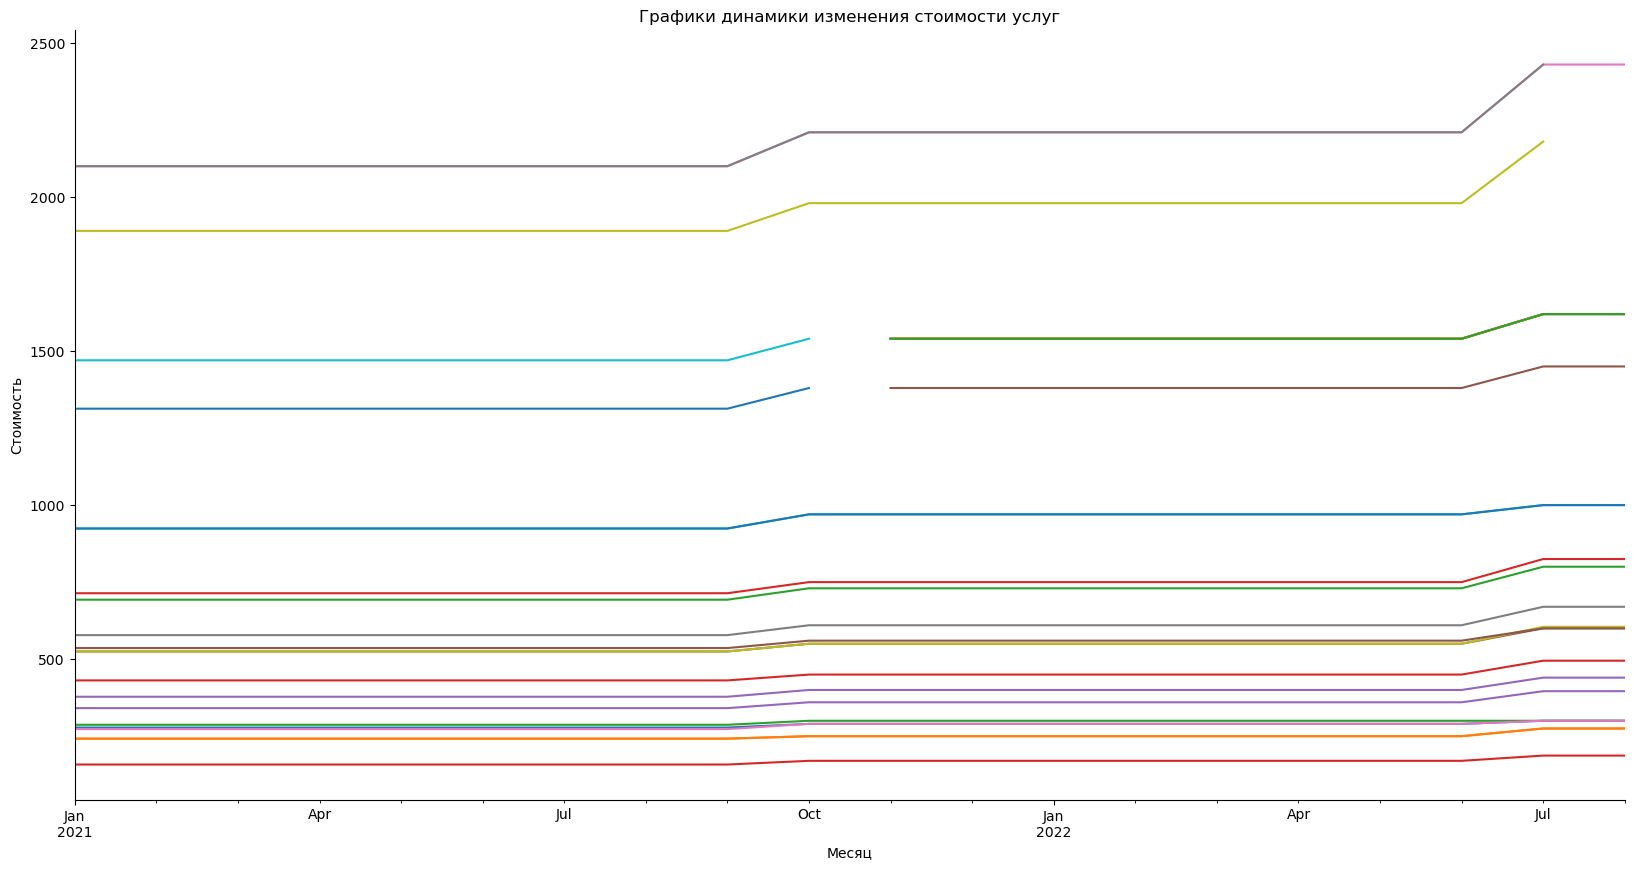

In [98]:
# Подсчитаем для каждой услуги стоимость в месяц с помощью mode:
(tmp
 .assign(one_service_price = lambda x: x['service_amount']/x['service_number'])
 .groupby(['month','service_name'])
 .agg({'one_service_price':lambda x: x.mode().iloc[0]})
 .reset_index()
 
# Добавим данные, насколько была востребована услуга:
 .merge(tmp.groupby('service_name').agg({'insured':'nunique'}).reset_index(), on='service_name')
  
# Оставим услуги, например, те, которые заказывали более 500 клиентов 
 .query('insured > 500') 
 
# Создаем сводную таблицу для построения графиков динамики:
 .pivot_table(index='month', columns='service_name', values='one_service_price', aggfunc='mean')
).plot(figsize=(20, 10), title='Графики динамики изменения стоимости услуг')
plt.xlabel('Месяц')
plt.ylabel('Стоимость')
plt.legend().remove()
sns.despine()

plt.show()

Мы видим поднятие цен на большинство услуг в октябре 2021 года и в мае 2022 года. Проверим, на какие услуги изменились цены, была ли это все же общая индексация, или частичное поднятие цен на определенные виды услуг.

In [99]:
# Сделаем несколько срезов в датасете, сначала отберем нужные для анализа столбцы, затем сделаем срезы по годам 
# и обьединим их в одну таблицу
tmp = data.copy()
tmp = data[['insured', 'service_name', 'service_date', 'service_year','price_for_one_service', 'category_name']]

tmp_21 = tmp.query('service_year == 2021')
tmp_22 = tmp.query('service_year == 2022')

tmp_change_prices = tmp_21.merge(tmp_22, on = 'insured', how='inner')

In [100]:
# Сделаем еще один срез, в котором наименование услуги в 2021 году совпадает с наименованием услуги в 2022 году.
# Проверим, сколько цен остались прежними
tmp_prices_not_change = tmp_change_prices.query('service_name_x == service_name_y & \
                                                 price_for_one_service_x == price_for_one_service_y')
len(tmp_prices_not_change)

3230

In [101]:
# Проверим, по скольким позициям цены выросли
tmp_prices_change = tmp_change_prices.query('service_name_x == service_name_y & \
                                                 price_for_one_service_x < price_for_one_service_y')
len(tmp_prices_change)

4074

In [102]:
# Посчитаем % услуг от общего количества, по котором цены в 2022 году выросли.
round(len(tmp_prices_change) / (len(tmp_prices_not_change) + len(tmp_prices_change)) * 100,1)

55.8

По 55.8% наименованиям из нашего среза цены выросли. Сделаем срезы по годам по категориям услуг, посмотрим на изменения.

In [103]:
# Сделаем срез по 2021 году
tmp_cat_price_21 = (tmp
                    .query('service_year == 2021')
                    .groupby('category_name')
                    .agg({'price_for_one_service':'sum', 'insured':'count'})
                    .reset_index())

# Добавим столбец со средним чеком на пациента по категориям
tmp_cat_price_21['price_for_person'] = tmp_cat_price_21['price_for_one_service'] / tmp_cat_price_21['insured']

In [104]:
# Сделаем срез по 2022 году
tmp_cat_price_22 = (tmp
                    .query('service_year == 2022')
                    .groupby('category_name')
                    .agg({'price_for_one_service':'sum', 'insured':'count'})
                    .reset_index())

# Добавим столбец со средним чеком на пациента по категориям
tmp_cat_price_22['price_for_person'] = tmp_cat_price_22['price_for_one_service'] / tmp_cat_price_22['insured']

In [105]:
# Объединим данные
tmp_сat_price = tmp_cat_price_21.merge(tmp_cat_price_22, on='category_name', how='inner'). \
                      sort_values(by='price_for_person_x', ascending=False)

tmp_сat_price = (tmp_сat_price
                 .drop(columns=['insured_x', 'insured_y'])
                 .rename(columns={'price_for_one_service_x':'price_for_one_service_21',
                                  'price_for_person_x':'price_for_person_21',
                                  'price_for_one_service_y':'price_for_one_service_22',
                                  'price_for_person_y':'price_for_person_22'}))

round(tmp_сat_price,1).style.background_gradient()

,category_name,price_for_one_service_21,price_for_person_21,price_for_one_service_22,price_for_person_22
1,Вакцинация,75529.000000,3147.000000,17230.000000,3446.000000
7,Хирургия,465289.000000,1789.600000,508500.000000,1790.500000
3,Инструментальные исследования,11355763.000000,1534.100000,11865630.000000,1604.500000
4,Прием,19723502.000000,1443.900000,19340175.000000,1516.400000
6,Физиотерапия,8142113.000000,1378.400000,7509840.000000,1361.700000
2,Другое,317710.000000,996.000000,214830.000000,807.600000
5,Процедурный кабинет,1257502.000000,772.400000,1155942.000000,903.100000
0,Анализы,8414863.000000,553.900000,7763719.000000,576.000000


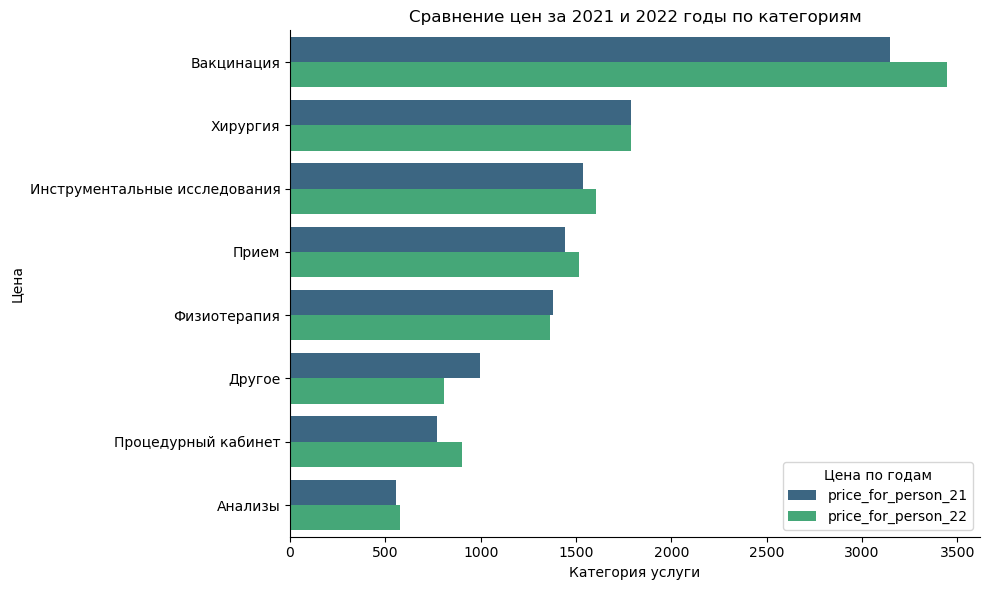

In [106]:
# Построим сравнительный график по ценам на человека за услугу в 2021 и 2022 годах
melted_data = tmp_сat_price.melt(id_vars='category_name', 
                                       value_vars=['price_for_person_21', 'price_for_person_22'],
                                       var_name='Цена по годам', value_name='Цена')
plt.figure(figsize=(10, 6))

# Строим график
sns.barplot(y='category_name', x='Цена', hue='Цена по годам', data=melted_data, palette='viridis')
plt.xlabel('Категория услуги')
plt.ylabel('Цена')
plt.title('Сравнение цен за 2021 и 2022 годы по категориям')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

sns.despine()
plt.tight_layout()

plt.show()

Рост цен не похож на общую индексацию, цены выросли выборочно на ряд услуг.

Цены выросли во почти всех категориях, кроме "Хирургии", "Физиотерапии", да и там разница в ценах минимальная. Цены не выросли на категорию услуг "Другое", но в нее попали довольно специфические услуги, так что можно понять, почему в этом случае цены остались без индексации. Больше всего выросли цены на вакцинацию. Высокий спрос на лекарства и медицинские расходные материалы, связанный с пандемией Сovid-19, мог привести к увеличению цен на эти товары. Производители и поставщики сталкивались с увеличенным спросом и трудностями в производстве товаров и их доставке. Также могли повлиять инфляция, изменение баланса спроса и предложения, политика регулировки цен в стране.

По данным Росстата за 2021 год "лекарственные препараты, не относящиеся к жизненно необходимым и важнейшим лекарственным препаратам (ЖНВЛП), стали дороже на 0,7%, cреди медицинских товаров и перевязочных материалов подорожали: бинты – на 0,4%, шприцы одноразовые, вата отечественная – на 0,3%.

По данным Росстата за 2022 год "лекарственные препараты, не относящиеся к жизненно необходимым и важнейшим лекарственным препаратам (ЖНВЛП), стали дороже на 1,0%; цены на лекарственные препараты, относящиеся к ЖНВЛП, выросли на 0,7%; среди медицинских товаров и перевязочных материалов подорожали: бинты – на 1,0%, вата отечественная – на 0,4%, шприцы одноразовые – на 0,3%". Выросли цены и на следующие медицинские услуги: "лечебный массаж – на 1,1%, физиотерапевтическое лечение – на 0,7%, первичный консультативный прием у врача специалиста, первичный консультативный осмотр больного у стоматолога – на 0,5%."

Поскольку мы не знаем, какие медицинские препараты и товары использовала клиника (отечественные или импортные), были ли в клинике достаточные запасы медицинской продукции и лекарств на складе, то утверждать наверняка мы ничего не можем.  Но так или иначе Росстатом зафиксирован рост на медицинские товары  и услуги, и рост цен в клинике может быть связан в том числе и с этим фактом.

**Выводы:**

Гипотеза не подтверждается. Цены изменились дважды на анализируемый период. Изменение цен на востребованные услуги было в октябре 2021 года и в июле 2022 года. Цены были подняты на ряд услуг практически по всем категориям, кроме "Хирургии", "Физиотерапии" и "Другое" на 55.8% наименований услуг.

<a id="12"></a>

#### Вторая гипотеза

*Изменение цены в 2022 году по сравнению с 2021 годом  зависит от увеличения количества пациентов.*

Проверим данную гипотезу.

Нулевая гипотеза (H0): количество пациентов в 2021 и 2022 годах одинаковое.

Альтернативная гипотеза (H1): количество пациентов в 2021 и 2022 годах отличается.

In [107]:
# Проверка гипотезы о том, что количество пациентов в 2021 и 2022 годах одинаковое
alpha = 0.05

# Разделяем данные по годам
data_2021 = data.query('service_month in [1,2,3,4,5,6,7,8] & service_year == 2021')['insured'].unique()
data_2022 = data.query('service_year == 2022')['insured'].unique()

# Проверка равенства дисперсий
_, p_var = st.levene(data_2021, data_2022)
print(f'p-value для проверки равенства дисперсий: {p_var}')

if p_var < alpha:
    print('Eсть статистически значимые различия в дисперсиях между группами')
else:
    print('Нет статистически значимых различий в дисперсиях между группами')

p-value для проверки равенства дисперсий: 6.481600520237938e-66
Eсть статистически значимые различия в дисперсиях между группами


In [108]:
# Используем t-тест с учетом неравенства дисперсий
results = st.ttest_ind(data_2021, data_2022, equal_var=False)
print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу о том, что количество пациентов в 2021 и 2022 годах одинаковое')
else:
    print('Нет оснований отвергнуть нулевую гипотезу о том, что количество пациентов в 2021 и 2022 годах одинаковое')

p-value: 0.0
Отвергаем нулевую гипотезу о том, что количество пациентов в 2021 и 2022 годах одинаковое


Полученное значение p-value говорит о том, что мы отвергаем нулевую гипотезу,  что количество пациентов в 2021 и 2022 годах одинаковое. Проверим, насколько сильно изменилось количество пациентов в 2022 году по сравнению с 2021 годом.

In [109]:
# Посчитаем количество  пациентов по годам с января по август включительно
tmp = (data
       .query('(service_month in [1,2,3,4,5,6,7,8] & service_year == 2021) | service_year == 2022')
       .groupby('service_year')['insured'].nunique().reset_index()
       .rename(columns={'insured': 'insured_cnt'}))
tmp.style.background_gradient()

,service_year,insured_cnt
0,2021,1733
1,2022,2757


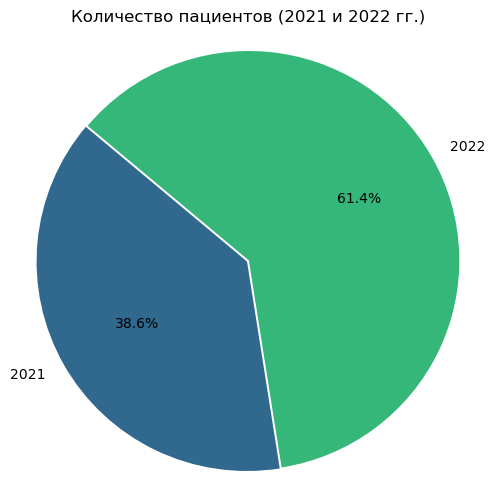

In [110]:
# Построим круговую диаграмму количества уникальных пациентов в 2021 и 2022 годах

# Данные для диаграммы
service_year = tmp['service_year']
insured_cnt = tmp['insured_cnt']
colors = sns.color_palette('viridis', len(labels))

plt.figure(figsize=(6, 6))

# Строим круговую диаграмму
plt.pie(insured_cnt, labels=service_year, autopct='%1.1f%%', startangle=140, colors=colors, explode = (0.01, 0))

plt.title('Количество пациентов (2021 и 2022 гг.)')
plt.axis('equal')

plt.show()

In [111]:
# Посчитаем насколько увеличилось количество пациентов за 8 месяцев 2021 и 2022 годов
tmp_percent = ((tmp['insured_cnt'][1] - tmp['insured_cnt'][0]) / tmp['insured_cnt'][0]) * 100

display(f'Количество визитов пациентов в 2022 году увеличилось на {round(tmp_percent)} %')

'Количество визитов пациентов в 2022 году увеличилось на 59 %'

Какие-то внешние факторы повлекли за собой увеличение количества пациентов. Возможно, это было связано со снятием большинства ковидных ограничений осенью 2021 года. Люди стали чаще обращаться за медицинской помощью, решать накопившиеся за период пандемии проблемы со здоровьем. Мы уже выяснили, что цены были подняты в октябре 2021 года и в июле 2022 года. Посмотрим  связано ли изменение цен с помесячным приростом количества пациентов.

In [112]:
# Подсчитаем количество уникальных пациентов по месяцам в 2021 году
# Количество клиентов за первые 8 месяцев 2021 года
tmp_insured_21_1 = (data
                    .query('service_month in [1,2,3,4,5,6,7,8] & service_year == 2021')
                    .groupby('service_month')
                    .agg(insured_21_1=('insured','nunique'))
                    .reset_index()) 

display(tmp_insured_21_1)
display(f'Сумма клиентов за первые 8 месяцев 2021 года: {tmp_insured_21_1["insured_21_1"].sum()}')

# Количество за последние 4 месяца 2021 года
tmp_insured_21_2 = (data
                    .query('service_month in [9,10,11,12] & service_year == 2021')
                    .groupby('service_month')
                    .agg(insured_21_2=('insured','nunique'))
                    .reset_index()) 

display(tmp_insured_21_2)
display(f'Сумма клиентов за последние 4 месяца 2021 года: {tmp_insured_21_2["insured_21_2"].sum()}')

# Общее количество уникальных клиентов за 2021 год
display(f'Общее количество уникальных клиентов за 2021 год: \
{tmp_insured_21_1["insured_21_1"].sum() + tmp_insured_21_2["insured_21_2"].sum()}')

,service_month,insured_21_1
0,1,286
1,2,309
2,3,446
3,4,467
4,5,469
5,6,435
6,7,447
7,8,488


'Сумма клиентов за первые 8 месяцев 2021 года: 3347'

,service_month,insured_21_2
0,9,559
1,10,591
2,11,539
3,12,560


'Сумма клиентов за последние 4 месяца 2021 года: 2249'

'Общее количество уникальных клиентов за 2021 год: 5596'

Виден  последовательный рост количества уникальных пациентов, начиная с начала 2021 года. Гипотетически, этот факт может быть причиной увеличения цены на некоторые (или все) услуги.

In [113]:
# Посчитаем количество уникальных пациентов по месяцам в 2022 году
tmp_insured_22 = (data
                  .query('service_year == 2022')
                  .groupby('service_month')
                  .agg(insured_22=('insured','nunique'))
                  .reset_index())   

display(tmp_insured_22)
display(f'Количество уникальных клиентов за 2022 год: {tmp_insured_22["insured_22"].sum()}')


,service_month,insured_22
0,1,555
1,2,589
2,3,662
3,4,794
4,5,802
5,6,738
6,7,641
7,8,359


'Количество уникальных клиентов за 2022 год: 5140'

Мы видим, что за общее количество уникальных клиентов в 2022 году меньше, чем в 2021, но за аналогичный период в 8 месяцев каждого года виден явный прирост уникальных клиентов. До мая 2022 года виден рост уникальных клиентов, затем начинается падение, в августе практически в 2 раза, может он как раз и связан с тем, что цены в июле были подняты. Или виной тому летний сезон, экономические и политические факторы.

In [114]:
# Объединим таблицы за 8 месяцев 2021 года и 2022 год
tmp_insured_total = tmp_insured_21_1.merge(tmp_insured_22, on='service_month', how='left')
tmp_insured_total.style.background_gradient()

,service_month,insured_21_1,insured_22
0,1,286,555
1,2,309,589
2,3,446,662
3,4,467,794
4,5,469,802
5,6,435,738
6,7,447,641
7,8,488,359


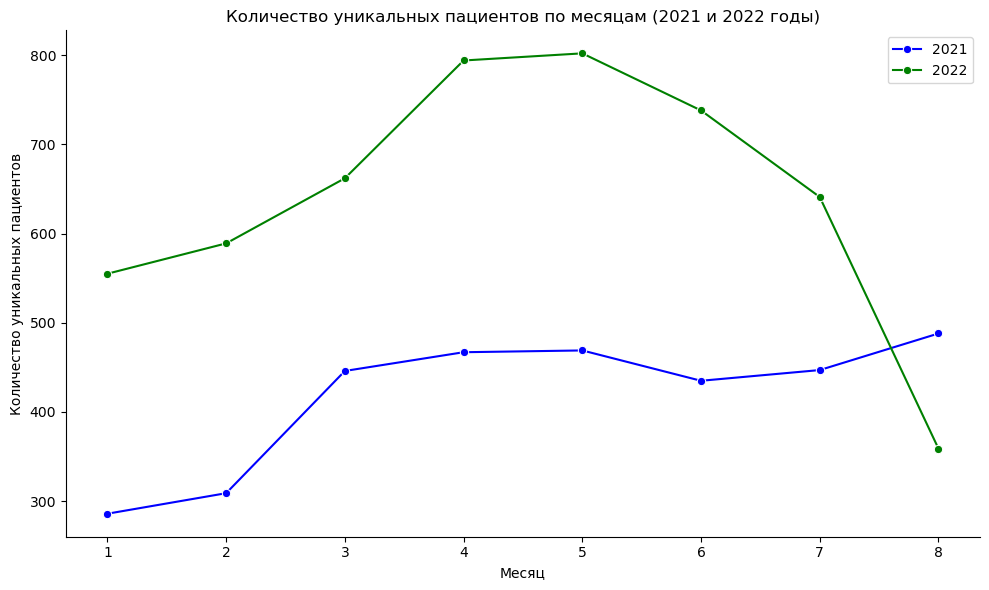

In [115]:
# Построим графики количества уникальных пациентов по месяцам
plt.figure(figsize=(10, 6)) 

# Строим графики
sns.lineplot(data=tmp_insured_total, x='service_month', y='insured_21_1', label='2021', marker='o',
             linestyle='-', color='blue')
sns.lineplot(data=tmp_insured_total, x='service_month', y='insured_22', label='2022', marker='o',
             linestyle='-', color='green')

plt.xlabel('Месяц')
plt.ylabel('Количество уникальных пациентов')
plt.title('Количество уникальных пациентов по месяцам (2021 и 2022 годы)')
plt.legend()
plt.grid(False)

plt.tight_layout()
sns.despine()

plt.show()

В 2021 года количество пациентов постоянно увеличивалось, не считая небольшого снижения количества в мае-июне. В 2022 году рост продолжился до мая, затем началось снижение. Посмотрим, изменились ли стоимости их визитов в клинику. 

In [116]:
# Найдем сумму потраченных средств и количество визитов для каждого пациента в 2021 году,
# а также средний чек за визит
tmp_price_21 = (data.query('service_year == 2021')
                .groupby('insured')
                .agg({'service_amount': 'sum', 'service_date':'nunique'})
                .reset_index())

tmp_price_21['price_for_one_visit'] = tmp_price_21['service_amount']/tmp_price_21['service_date']

In [117]:
# Найдем сумму потраченных средств и количество визитов для каждого пациента в 2022 году, а также средний чек 
# за визит
tmp_price_22 = (data.query('service_year == 2022')
                .groupby('insured')
                .agg({'service_amount': 'sum', 'service_date':'nunique'})
                .reset_index())

tmp_price_22['price_for_one_visit'] = tmp_price_22['service_amount']/tmp_price_22['service_date']

In [118]:
# Объединим полученные данные и удалим строки с пропусками, нам для анализа нужны только пациенты, 
# посещавщие клинику и в 2021 и в 2022 годах
tmp_price_total = tmp_price_21.merge(tmp_price_22, on ='insured', how ='left')
tmp_price_total.dropna(inplace=True)
tmp_price_total.columns=['insured', 'amount_21', 'visits_21', 'price_for_one_visit_21', 'amount_22', 'visits_22',
                        'price_for_one_visit_22']

tmp_price_total[['visits_22','amount_22']] = tmp_price_total[['visits_22','amount_22']].astype(int)

# Посчитаем разницу средних чеков за визит по годам в процентах
tmp_price_total['percent'] = (1 - tmp_price_total['price_for_one_visit_21'] / \
                                 tmp_price_total['price_for_one_visit_22']) * 100
tmp_price_total.drop(columns=['amount_21', 'visits_21','amount_22', 'visits_22'], inplace=True)

round(tmp_price_total)


,insured,price_for_one_visit_21,price_for_one_visit_22,percent
1,125094,4228.0,3190.0,-33.0
7,142438,3425.0,2158.0,-59.0
8,142447,3248.0,1941.0,-67.0
9,142488,3104.0,6625.0,53.0
10,142530,2221.0,2607.0,15.0
...,...,...,...,...
2505,774384,1540.0,2162.0,29.0
2506,774385,2955.0,3798.0,22.0
2509,774388,2326.0,2424.0,4.0
2510,774389,12140.0,3074.0,-295.0


In [119]:
# Найдем, количество случаев, когда стоимость услуги в 2021 не изменилась и в 2022
len(tmp_price_total.query('percent == 0'))

4

Всего в 4 случаях цены остались прежними.

In [120]:
# Посмотрим, сколько пользователей платили за услугу в среднем меньше в 2022 году, чем в 2021
len(tmp_price_total.query('percent < 0'))

404

In [121]:
# Посмотрим, сколько пользователей платили за услугу в среднем больше в 2022 году, чем в 2021
len(tmp_price_total.query('percent > 0'))

376

In [122]:
# Посчитаем сколько процентов посетителей от общего количества платили в 2022 году меньше 
tmp_diff = round(len(tmp_price_total.query('percent<0')) / len(tmp_price_total) * 100, 1)

print(f'У {tmp_diff}% пациентов средний чек уменьшился, у {100 - tmp_diff}% - увеличился.')

У 51.5% пациентов средний чек уменьшился, у 48.5% - увеличился.


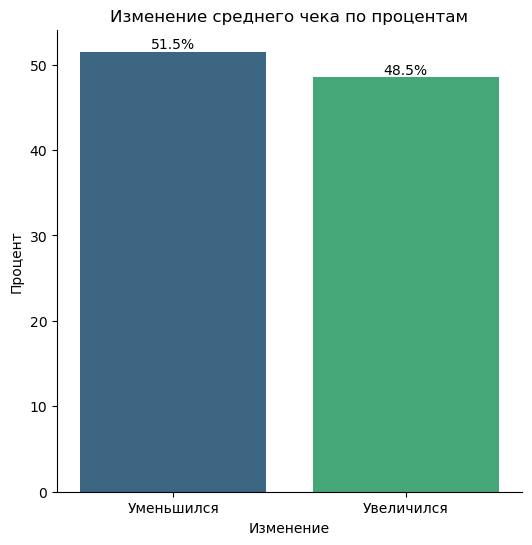

In [123]:
# Построим визуализацию
tmp_diff_viz = [tmp_diff, 100 - tmp_diff]

# Создаем график
plt.figure(figsize=(6, 6))
sns.barplot(x=['Уменьшился', 'Увеличился'], y=tmp_diff_viz, palette='viridis')

# Добавляем значения над столбцами
for i, value in enumerate(tmp_diff_viz):
    plt.text(i, value, str(round(value, 1)) + '%', ha='center', va='bottom')

plt.title('Изменение среднего чека по процентам')
plt.xlabel('Изменение')
plt.ylabel('Процент')

sns.despine()

plt.show()

**Выводы:**

Гипотеза скорее подтверждается. Изменение (поднятие цен) может быть связано с увеличением притока новых пациентов. Поток пациентов увеличивался в течение всего времени до лета 2022 года. Затем началось снижение, не совcем понятно поднятие цен в июле 2022 года, но бизнес мог просто не успеть среагировать на снижение количества пациентов, или воспринять его как системное явление, так как летом 2021 года была похожая ситуация. Что было в перспективе нескольких месяцев после подъема цен мы не знаем, данных нет. Но при этом изменились средние чеки на лечение - в 51.5% случаев снизились, а в 48.5% случаев, наоборот, увеличились, возможно, это связано со спросом на конкретные услуги.

<a id="13"></a>

#### Третья гипотеза

Было бы интересно изучить вопрос о связи роста цен с внешними экономическими и политическими событиями, ростом валюты, повлекшими за собой подорожание расходных материалов и лекарственных средств, но для этого у нас нет данных, нам нужно больше сведений по затратам медцентра, чтобы проверить эту гипотезу. Даже если мы зафиксируем какие-то различия - то мы не сможем доказать такую связь.

Для рассмотрения следующей гипотезы я возьму такую услугу без применения расходных материалов, как "Прием/Консультация специалистов". Эта услуга не подразумевает поднятия цен из-за подорожания лекарственных препаратов.

*Цены на лечение меняются в зависимости  от  колебания спроса на услугу.*

Проверим данную гипотезу.

In [124]:
# Сделаем срез в датасете по приемам
tmp = data.query('category_name == "Прием"')

# Посчитаем количество уникальных услуг в 2021 году
tmp_21 = tmp.query('service_year == 2021')

print('Количество уникальных услуг в категории "Прием" в 2021 году:',
      len(tmp_21['service_name'].sort_values().unique()))

# Посчитаем количество уникальных услуг в 2022 году
tmp_22 = tmp.query('service_year == 2022')

print('Количество уникальных услуг в категории "Прием" в 2021 году:',
      len(tmp_22['service_name'].sort_values().unique()))
      

Количество уникальных услуг в категории "Прием" в 2021 году: 64
Количество уникальных услуг в категории "Прием" в 2021 году: 69


In [125]:
# Найдем услуги, которые не совпадают в 2021 и в 2022 году
tmp_name_21 = set(tmp_21['service_name'])
tmp_name_22 = set(tmp_22['service_name'])

only_in_21 = tmp_name_21 - tmp_name_22
only_in_22 = tmp_name_22 - tmp_name_21

print(f'Значения только в 2021 году: {sorted(only_in_21)}')
print()
print(f'Значения только в 2022 году: {sorted(only_in_22)}')

Значения только в 2021 году: ['Консультация ведущего специалиста перед вакцинацией', 'Консультация врача перед вакцинацией', 'Контрольный осмотр', 'Прием ведущего специалиста', 'Прием врача по лечебной физкультуре', 'Прием главного специалиста, врача-эксперта', 'Прием на дому (в пределах до 15 км за МКАД)', 'Прием на дому (до МКАД)', 'Прием первичный', 'Прием повторный']

Значения только в 2022 году: ['Консультация педиатра перед вакцинацией', 'Прием анестезиолога, первичный', 'Прием врача эндокринолога, руководителя направления Блох С.П.', 'Прием гастроэнтеролога, ведущего специалиста', 'Прием гастроэнтеролога, главного специалиста, врача-эксперта', 'Прием логопеда, первичный', 'Прием мануального терапевта, ведущего специалиста', 'Прием отоларинголога, профессора', 'Прием педиатра, главного специалиста, врача-эксперта', 'Прием терапевта на дому (до МКАД)', 'Прием терапевта, первичный', 'Прием травматолога-ортопеда, главного специалиста, врача-эксперта', 'Прием уролога, ведущего специа

Как мы видим, в 2022 году было изменено название некоторых услуг и добавлено несколько новых, некоторые услуги пропали из списка, например, "Прием терапевта на дому (за МКАД)", "Прием врача по лечебной физкультуре", "Прием первичный", "Прием повторный", последние два совершенно логично, так как не было понятно, какого специалиста это прием. Добавились консультации специалистов более высокого ранга, профессоров, руководителя направления и т.д, а также анастезиолога и логопеда.

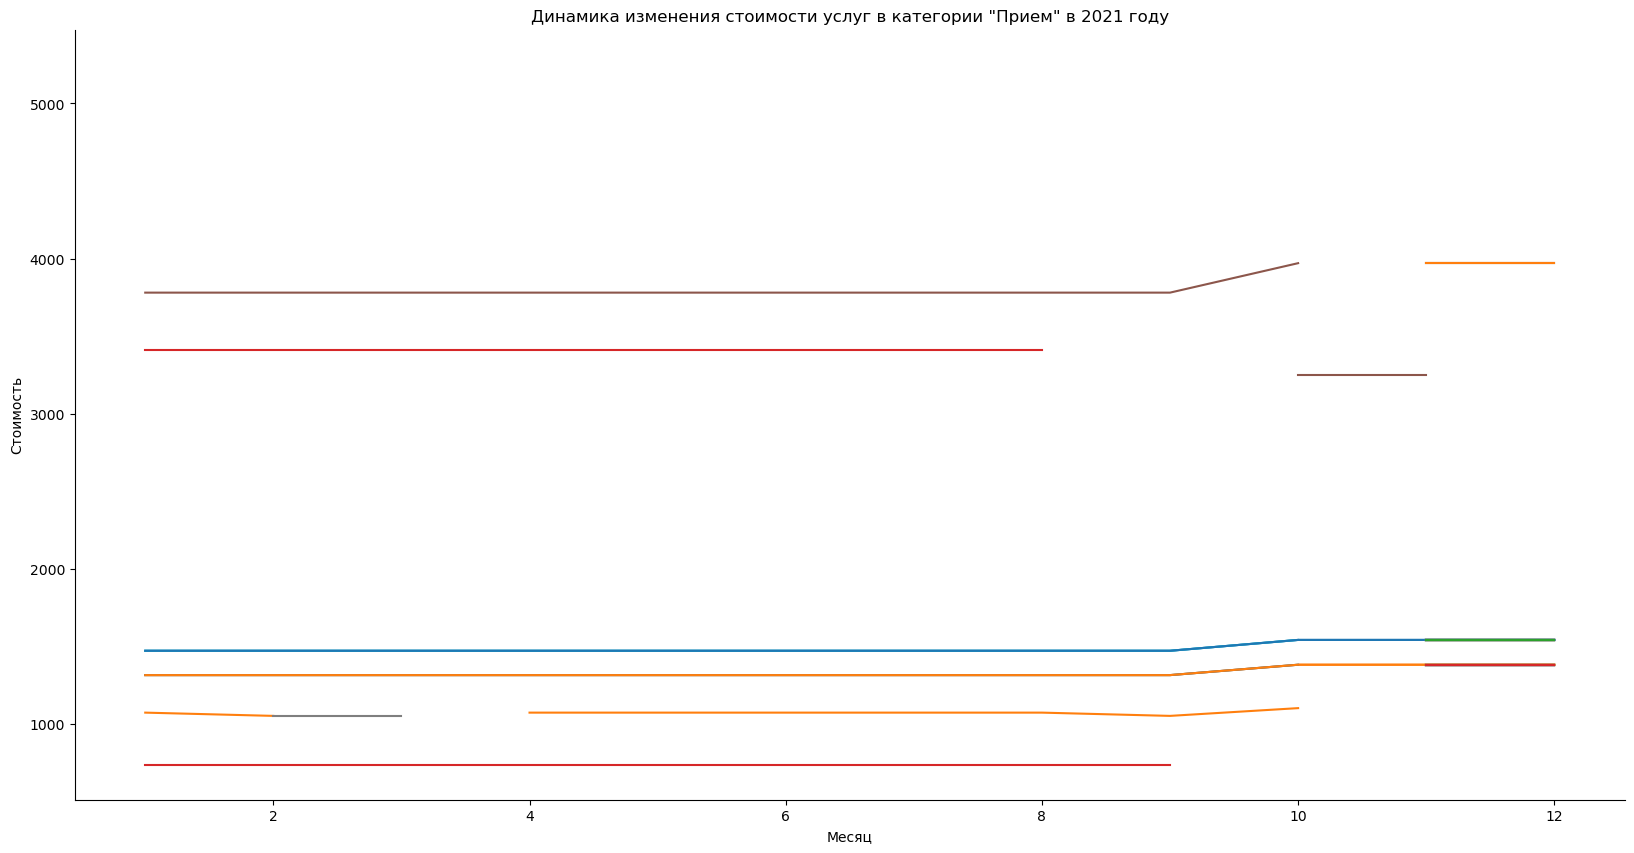

In [126]:
# Посмотрим, когда было изменение цены на категорию услуг "Прием" в 2021 году
tmp_change_price_21 = tmp_21.copy()

# Подсчитаем для каждой услуги стоимость в месяц с помощью mode:
(tmp_change_price_21
 .assign(one_service_price = lambda x: x['service_amount']/x['service_number'])
 .groupby(['service_month','service_name'])
 .agg({'one_service_price':lambda x: x.mode().iloc[0]})
 .reset_index() 
 
# Создаем сводную таблицу для построения графиков динамики:
 .pivot_table(index='service_month', columns='service_name', values='one_service_price', aggfunc='mean')
).plot(figsize=(20, 10), title='Динамика изменения стоимости услуг в категории "Прием" в 2021 году')
plt.xlabel('Месяц')
plt.ylabel('Стоимость')
plt.legend().remove()
sns.despine()

plt.show()

Ожидаемо, в октябре 2021 года.

In [127]:
# Посмотрим на уникальные значения стобца service_name в этом разрезе за 2021 год
tmp_name_price_21 = tmp_21.copy()

tmp_name_price_21 = tmp_name_price_21.groupby('service_name')['price_for_one_service'].unique().reset_index()
tmp_name_price_21['price_for_one_service'] = tmp_name_price_21['price_for_one_service'].\
apply(lambda x: ' '.join(map(str, x)))

# Отфильтруем строки с более чем 1 значением в столбце 'service_amount'
display(tmp_name_price_21[tmp_name_price_21['price_for_one_service'].apply(lambda x: len(x.split()) > 1)])


,service_name,price_for_one_service
1,Консультация врача перед вакцинацией,1071.0 1050.0 1100.0 1120.0
6,Прием ведущего специалиста,2100.0 2810.0
14,"Прием гинеколога, профессора",4190.0 5510.0
15,"Прием главного специалиста, врача-эксперта",3780.0 3970.0
20,"Прием мануального терапевта, первичный",1470.0 1540.0
21,"Прием мануального терапевта, повторный",1313.0 1380.0
39,Прием первичный,1470.0 1755.0 1540.0
40,Прием повторный,1313.0 1380.0
45,Прием психотерапевта,3098.0 3250.0
50,"Прием рефлексотерапевта, первичный",1470.0 1540.0


У нас всего 11 услуг из 64 в категории прием, цены на которые выросли хотя бы один раз за 2021 год. Изучим более внимательно услуги "Консультация врача перед вакцинацией" и "Прием первичный", по которым подъем цен был более, чем 1 раз.

In [128]:
# Определим функцию для анализа данных по названию услуги
def service_name_analysis(data, title):
    name = (data
            .query('service_name == @title')
            .groupby(['category_age', 'price_for_one_service', 'service_date'])
            .agg({'insured':'count'})
            .reset_index())
    display(name)
    display(f'Количество обращений по услуге "{title}": {name["insured"].sum()}')
    display('Количество обращений по каждой цене:')
    display(name.groupby('price_for_one_service')['insured'].sum())

In [129]:
# Определим функцию для визуализации данных по услуге
def viz_service_name(title, year):
    # Извлечение месяца из даты
    name = (data
            .query('service_name == @title')
            .groupby(['category_age', 'price_for_one_service', 'service_date'])
            .agg({'insured':'nunique'})
            .reset_index())
    name['service_date'] = pd.to_datetime(name['service_date'])
    name['month'] = name['service_date'].dt.to_period('M')

    # Группировка данных по месяцам и подсчет количества insured
    monthly_insured_count = name.groupby('month')['insured'].sum().reset_index()
    monthly_insured_count['month'] = monthly_insured_count['month'].astype(str)

    # Построение графика
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=monthly_insured_count, x='month', y='insured', linestyle='-', marker='o', color='blue')
    plt.title(f'Количество пациентов по услуге "{title}" по месяцам {year} года')
    plt.xlabel('Месяц')
    plt.ylabel('Общее количество пациентов')
    plt.xticks(rotation=45, ha='right')
    sns.despine()

    plt.show() 

In [130]:
# "Консультация врача перед вакцинацией"
service_name_analysis(tmp_21, "Консультация врача перед вакцинацией")

,category_age,price_for_one_service,service_date,insured
0,0-9,1050.0,2021-02-17,1
1,0-9,1050.0,2021-07-28,1
2,0-9,1050.0,2021-09-09,1
3,0-9,1050.0,2021-09-12,1
4,0-9,1071.0,2021-01-15,1
5,0-9,1071.0,2021-01-22,1
6,0-9,1071.0,2021-01-26,1
7,0-9,1071.0,2021-02-06,1
8,0-9,1071.0,2021-04-02,1
9,0-9,1071.0,2021-04-11,1


'Количество обращений по услуге "Консультация врача перед вакцинацией": 30'

'Количество обращений по каждой цене:'

price_for_one_service
1050.0     6
1071.0    19
1100.0     3
1120.0     2
Name: insured, dtype: int64

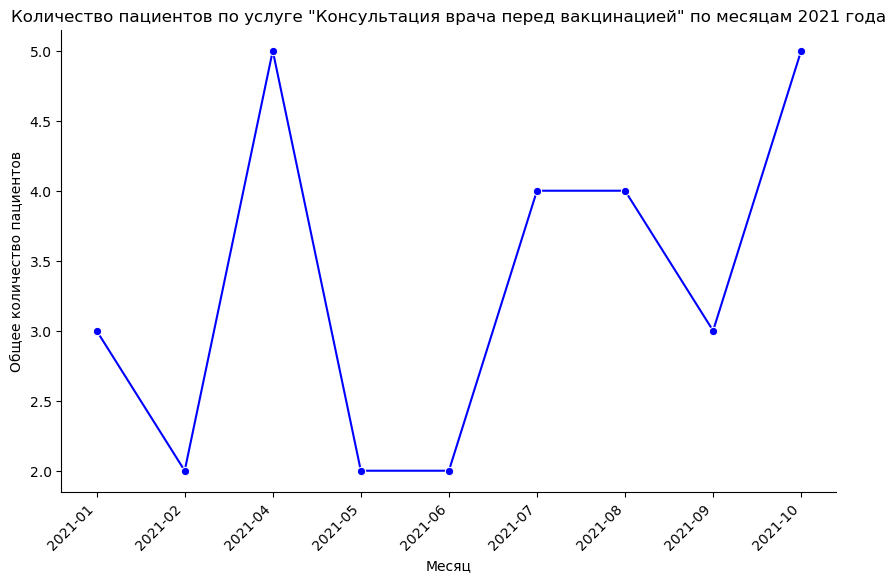

In [131]:
# Построим график распределния количества пациентов, получивших "Консультацию перед вакцинацией" по месяцам 2021 г.
viz_service_name("Консультация врача перед вакцинацией", 2021)

Тут, конечно, довольно непонятная ситуация с ценами. Цена 1071 р. за услугу была только для детей до 9 лет (возможно, у нас просто нет попадания пациентов другой возрастной категории на эту услугу в период ее такой стоимости). При этом цена ниже (1050 р.) действовала для некоторых пациентвов уже после поднятия цены до 1071 р. В октябре 2021 было два поднятия до 1100 р. для категории 20-29 лет и 1120 р. для категории 10-19 лет. На пару недель позже цена поднялась до 1100 р. для категории 30-39 лет. Судя по количеству клиентов, услуга вакцинации не слишком частая в клинике, скорее всего цены были подняты и для других возрастных категорий. Но по выборке из 30 человек выряд ли мы можем сделать вывод, что цены подняли из-за повышения спроса на услугу.
И из 30 консультаций 25 было детских. Тут уже напрашивается еще одна гипотеза о том, что  одни и те же услуги для разных возрастных категорий стоят по-разному, "Консультация перед вакцинацией" для детей стоит дороже, чем для взрослых. Рассмотрим ее позже.

In [132]:
# "Прием первичный"
service_name_analysis(tmp_21, "Прием первичный")

,category_age,price_for_one_service,service_date,insured
0,0-9,1470.0,2021-01-04,1
1,0-9,1470.0,2021-01-05,1
2,0-9,1470.0,2021-01-07,4
3,0-9,1470.0,2021-01-09,5
4,0-9,1470.0,2021-01-12,2
...,...,...,...,...
1505,60-69,1540.0,2021-10-31,1
1506,70+,1470.0,2021-03-21,1
1507,70+,1470.0,2021-05-03,1
1508,70+,1540.0,2021-10-29,1


'Количество обращений по услуге "Прием первичный": 6057'

'Количество обращений по каждой цене:'

price_for_one_service
1470.0    5265
1540.0     791
1755.0       1
Name: insured, dtype: int64

In [133]:
# Срез по цене 1755 рублей за прием по основному датасету
data.query('price_for_one_service == 1755')

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date,category_name,category_age,service_year,service_month,price_for_one_service,season,days_between_visits,churn
13047,30786105703,2021-05-05,Прием первичный,1755,1,362913,женский,31,Прием,30-39,2021,5,1755.0,весна,0.0,1


Такая запись всего одна в датасете, возможно это ошибка в данных. На всякий случай посмотрим на историю приемов данной пациентке.

In [134]:
data.query('insured ==362913 & service_year == 2021 & category_name == "Прием"').\
groupby(['service_date', 'service_name', 'price_for_one_service'])['record_id'].nunique()

service_date  service_name                            price_for_one_service
2021-01-26    Прием первичный                         1470.0                   1
2021-01-29    Прием первичный                         1470.0                   1
2021-04-07    Прием первичный                         1470.0                   1
2021-04-12    Прием мануального терапевта, первичный  1470.0                   1
              Прием первичный                         1470.0                   1
              Прием рефлексотерапевта, первичный      1470.0                   1
2021-04-16    Контрольный осмотр                      735.0                    1
2021-04-21    Прием рефлексотерапевта, повторный      1313.0                   1
2021-04-22    Прием повторный                         1313.0                   1
2021-04-23    Прием мануального терапевта, повторный  1313.0                   1
2021-04-30    Контрольный осмотр                      735.0                    1
              Прием повторный    

Нам попалась пациентка, которая похоже живет в клинике. Но вообще странная какая-то история, у нее три первичных приема в один день, два из которых по разной цене. Поскольку других услуг за такую цену нет в данных вообще, перепутать ни с чем это было нельзя,  будем считать, что это опечатка, или там был прием плюс что-то еще. Но это не повышение цены.

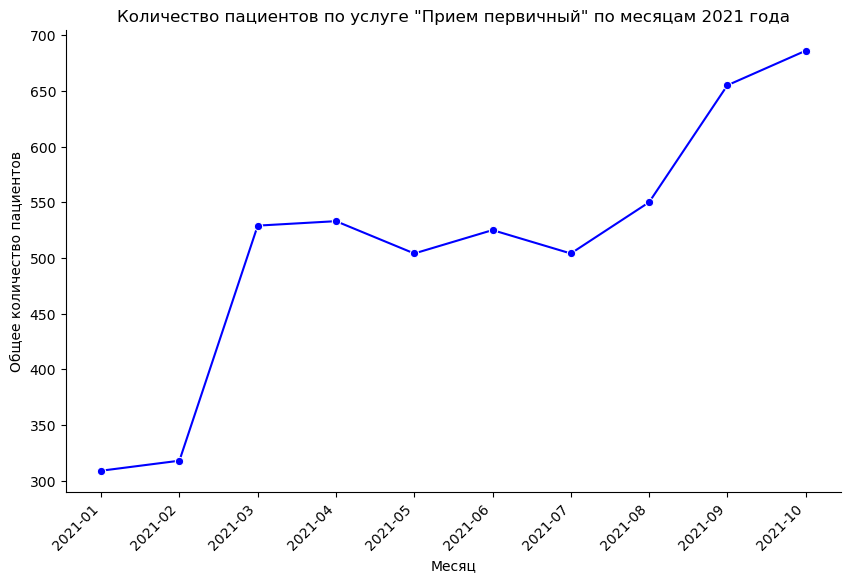

In [135]:
# Построим график распределения количества пациентов, получивших услугу "Прием первичный" по месяцам 2021 г.
viz_service_name("Прием первичный", 2021)

В данном случае вполне можно сказать, что цены на услугу "Прием первичный" могли быть подняты из-за повышения спроса на нее.

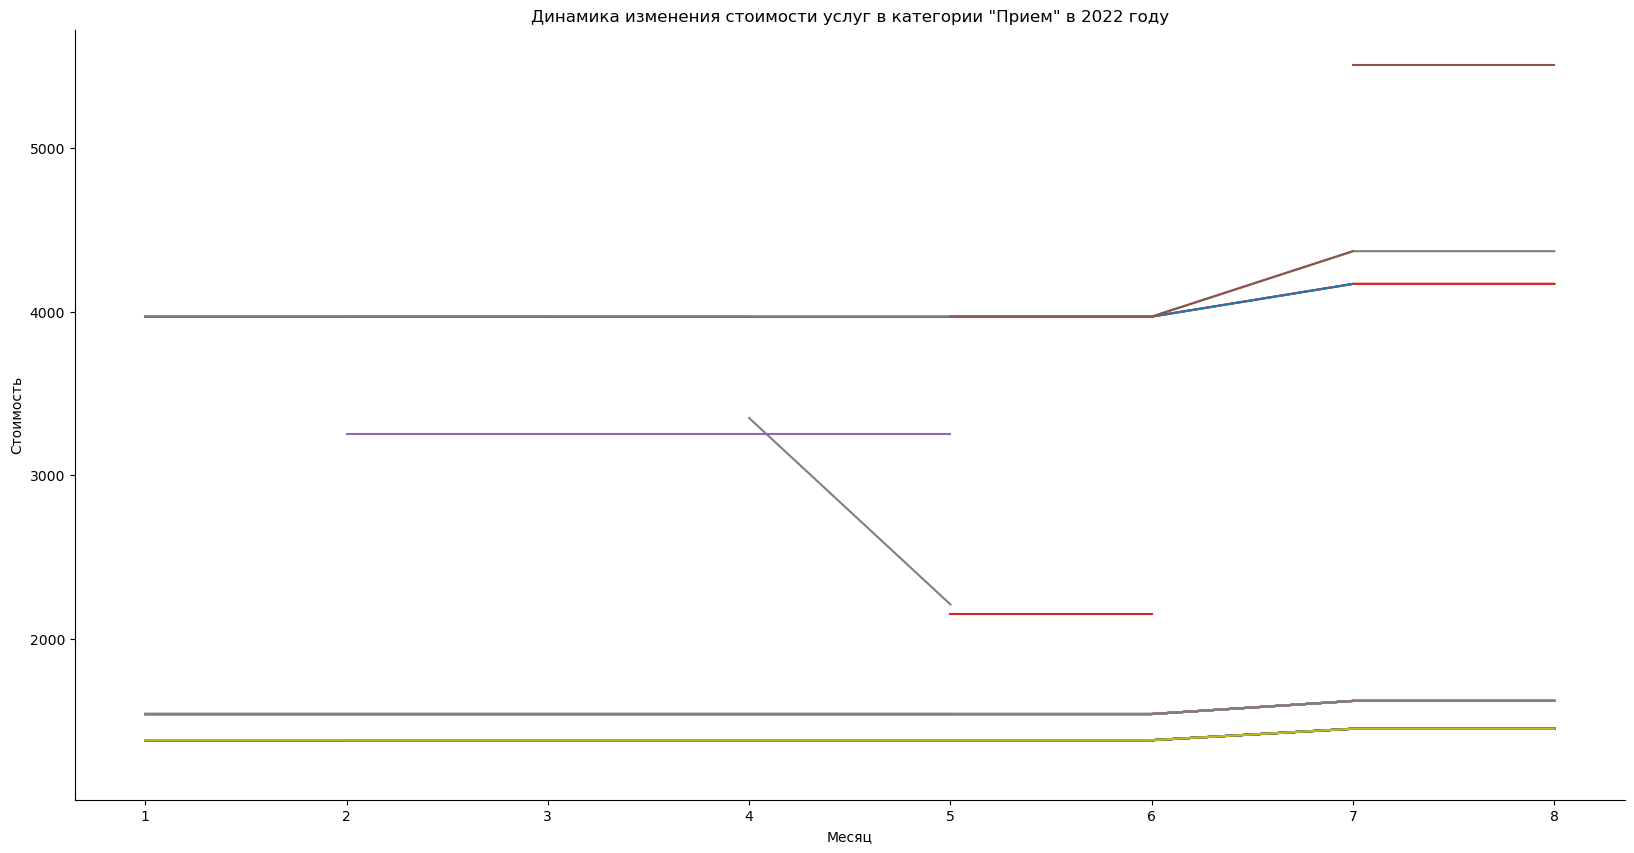

In [136]:
# Посмотрим, когда было изменение цены на категорию услуг "Прием" в 2022 году
tmp_change_price_22 = tmp_22.copy()

# Подсчитаем для каждой услуги стоимость в месяц с помощью mode:
(tmp_change_price_22
 .assign(one_service_price = lambda x: x['service_amount']/x['service_number'])
 .groupby(['service_month','service_name'])
 .agg({'one_service_price':lambda x: x.mode().iloc[0]})
 .reset_index() 
 
# Создаем сводную таблицу для построения графиков динамики:
 .pivot_table(index='service_month', columns='service_name', values='one_service_price', aggfunc='mean')
).plot(figsize=(20, 10), title='Динамика изменения стоимости услуг в категории "Прием" в 2022 году')
plt.xlabel('Месяц')
plt.ylabel('Стоимость')
plt.legend().remove()
sns.despine()

plt.show()

В 2022 году цены выросли в июле, видим также какое-то падение по услуге в мае.

In [137]:
# Посмотрим на уникальные значения стобца service_name по категории услуги "Прием" за 2022 год
tmp_name_price_22 = tmp_22.copy()

tmp_name_price_22 = tmp_name_price_22.groupby('service_name')['price_for_one_service'].unique().reset_index()
tmp_name_price_22['price_for_one_service'] = tmp_name_price_22['price_for_one_service'].\
apply(lambda x: ' '.join(map(str, x)))

# Отфильтруем строки с более чем 1 значением в столбце 'service_amount'
display(tmp_name_price_22[tmp_name_price_22['price_for_one_service'].apply(lambda x: len(x.split()) > 1)])
display(len(tmp_name_price_22[tmp_name_price_22['price_for_one_service'].apply(lambda x: len(x.split()) > 1)]))

,service_name,price_for_one_service
1,Консультация психолога (30 минут),1710.0 1800.0
2,"Прием аллерголога, первичный",1540.0 1620.0
3,"Прием аллерголога, повторный",1380.0 1450.0
6,"Прием врача-дерматолога, главного специалиста, врача-эксперта",3970.0 4170.0
7,"Прием гастроэнтеролога, ведущего специалиста",3350.0 2210.0
9,"Прием гастроэнтеролога, первичный",1540.0 1620.0
10,"Прием гастроэнтеролога, повторный",1380.0 1450.0
11,"Прием гинеколога, главного специалиста, врача-эксперта",3970.0 4170.0
12,"Прием гинеколога, первичный",1540.0 1620.0
13,"Прием гинеколога, повторный",1380.0 1450.0


52

На 52 услуги из 69 были подняты цены. Проверим некоторые, вызывающие вопросы данные.

In [138]:
# "Прием дерматолога, первичный"
service_name_analysis(tmp_22, "Прием дерматолога, первичный")

,category_age,price_for_one_service,service_date,insured
0,0-9,1540.0,2022-01-09,1
1,0-9,1540.0,2022-01-15,2
2,0-9,1540.0,2022-02-16,1
3,0-9,1540.0,2022-02-20,1
4,0-9,1540.0,2022-03-06,1
...,...,...,...,...
329,60-69,1540.0,2022-01-18,1
330,60-69,1620.0,2022-07-07,1
331,60-69,1620.0,2022-07-19,1
332,60-69,1620.0,2022-08-03,1


'Количество обращений по услуге "Прием дерматолога, первичный": 435'

'Количество обращений по каждой цене:'

price_for_one_service
1540.0    331
1620.0    102
2655.0      1
3350.0      1
Name: insured, dtype: int64

In [139]:
# Проверим две последние цены
display(data.query('service_name == "Прием дерматолога, первичный" & price_for_one_service == 2655'))
display(data.query('service_name == "Прием дерматолога, первичный" & price_for_one_service == 3350'))

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date,category_name,category_age,service_year,service_month,price_for_one_service,season,days_between_visits,churn
49326,32112482403,2022-02-10,"Прием дерматолога, первичный",2655,1,706408,женский,28,Прием,20-29,2022,2,2655.0,зима,1.0,1


,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date,category_name,category_age,service_year,service_month,price_for_one_service,season,days_between_visits,churn
70498,32631705803,2022-05-23,"Прием дерматолога, первичный",3350,1,1072833,женский,24,Прием,20-29,2022,5,3350.0,весна,3.0,1


Это никак не связанные друг с другом пациенты, это не подьем цены, вероятно, им была оказанам какая-то дополнительная услуга в рамках приема.

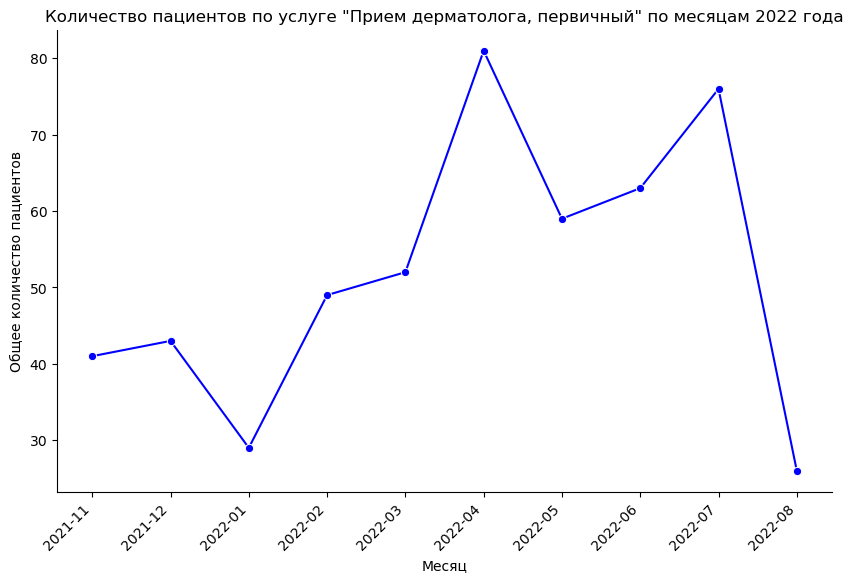

In [140]:
# Построим график распределения количества пациентов, получивших услугу "Прием дерматолога, 
# первичный" по месяцам 2021 г.
viz_service_name("Прием дерматолога, первичный", 2022)

Если не считать уменьшение количества пациентов к дерматологу в мае, то услуга действительно пользовалась спросом, что могло повлиять на изменение цены.

In [141]:
# "Прием гастроэнтеролога, ведущего специалиста"
service_name_analysis(tmp_22, "Прием гастроэнтеролога, ведущего специалиста")

,category_age,price_for_one_service,service_date,insured
0,20-29,3350.0,2022-04-05,1
1,30-39,2210.0,2022-05-24,1


'Количество обращений по услуге "Прием гастроэнтеролога, ведущего специалиста": 2'

'Количество обращений по каждой цене:'

price_for_one_service
2210.0    1
3350.0    1
Name: insured, dtype: int64

Вот тут, скорее всего, тот случай, когда услуга не пользуется популярностью и цена упала, что мы и видим на графике. Есть услуга "Прием гастроэнтеролога, первичный" и "Прием гастроэнтеролога, повторный". Думаю, что большинство пациентов не захотели переплачивать, или доктор на стандартном приеме хороший, и искать "второе мнение" необходимости нет. Но возможна и другая ситуация, просто в более высокую цену была включена какая-то дополнительная услуга. Слишком мало данных для точного анализа.

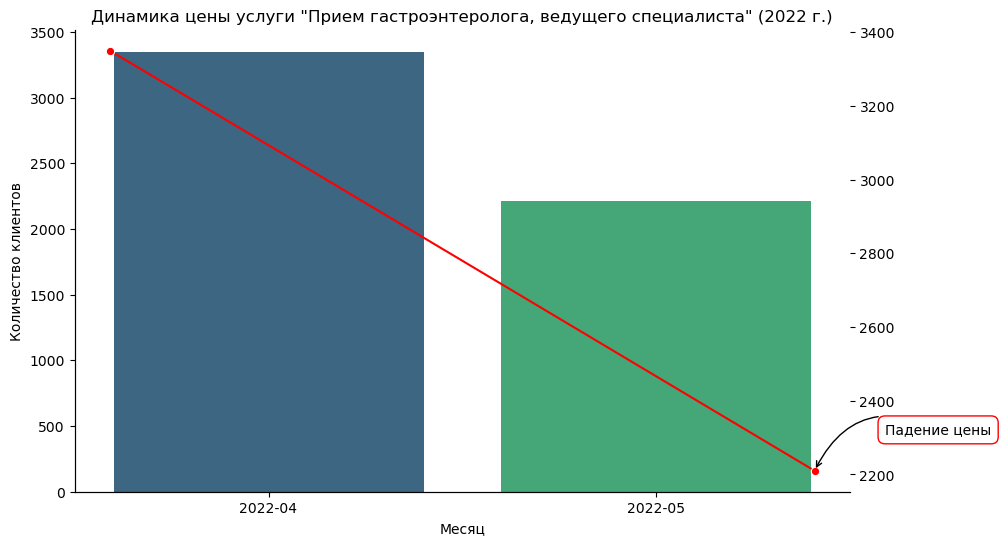

In [142]:
# Построим график количества посетителей, воспользовавшихся услугой с акцентом на месяц понижения цены
plt.figure(figsize=(10, 6))
tmp_name = (tmp_22
            .query('service_name == "Прием гастроэнтеролога, ведущего специалиста"')
            .groupby(['category_age', 'price_for_one_service', 'service_date'])
            .agg({'insured':'nunique'})
            .reset_index())
tmp_name['month'] = tmp_name['service_date'].dt.to_period('M')
tmp_name['month'] = tmp_name['month'].astype(str)
ax = sns.barplot(data=tmp_name, x='month', y='price_for_one_service', palette='viridis')
ax2 = ax.figure.add_subplot(111, label='line')
sns.lineplot(data=tmp_name, x='month', y='price_for_one_service', marker='o', linestyle='-', color='red', ax=ax2)

# Определение координат для аннотации
highlighted_month = '2022-05'
highlighted_x = tmp_name[tmp_name['month'] == highlighted_month].index.tolist()[0]
highlighted_y = tmp_name[tmp_name['month'] == highlighted_month]['price_for_one_service'].values[0]

# Выделение месяца падения цены
plt.annotate('Падение цены', xy=(highlighted_x, highlighted_y), xytext=(highlighted_x+0.1, highlighted_y+100),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5'),
             bbox=dict(boxstyle='round,pad=0.5', edgecolor='r', facecolor='none'))
ax.set_xlabel('Месяц')  
ax.set_ylabel('Количество клиентов')   
plt.xlabel('')
plt.ylabel('')
plt.title('Динамика цены услуги "Прием гастроэнтеролога, ведущего специалиста" (2022 г.)')
plt.grid(False)
ax2.set_facecolor('None')
ax2.xaxis.set_visible(False)
ax2.yaxis.tick_right()

sns.despine()

plt.show()

In [143]:
# "Прием физиотерапевта, первичный"
service_name_analysis(tmp_22, "Прием физиотерапевта, первичный")

,category_age,price_for_one_service,service_date,insured
0,0-9,1540.0,2022-02-07,1
1,0-9,1540.0,2022-02-25,1
2,0-9,1540.0,2022-03-21,1
3,0-9,1540.0,2022-04-04,1
4,0-9,1540.0,2022-04-15,1
...,...,...,...,...
250,60-69,1540.0,2022-05-11,1
251,60-69,1620.0,2022-07-25,1
252,70+,1540.0,2022-02-26,1
253,70+,1540.0,2022-04-18,1


'Количество обращений по услуге "Прием физиотерапевта, первичный": 324'

'Количество обращений по каждой цене:'

price_for_one_service
1350.0      1
1540.0    260
1620.0     63
Name: insured, dtype: int64

In [144]:
display(data.query('service_name == "Прием физиотерапевта, первичный" & price_for_one_service == 1350'))

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date,category_name,category_age,service_year,service_month,price_for_one_service,season,days_between_visits,churn
79952,32978881103,2022-07-08,"Прием физиотерапевта, первичный",1350,1,1154934,мужской,28,Прием,20-29,2022,7,1350.0,лето,6.0,1


Сниженная цена у единственного пациента уже после повышения цен на услугу говорит скорее всего о какой-то ошибке, или, возможно, была какая-то скидка, акция и т.д.

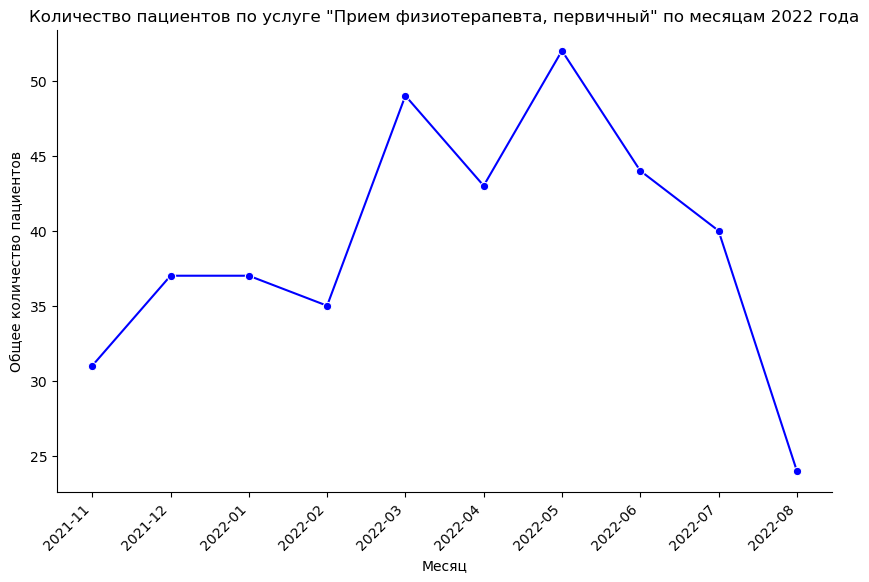

In [145]:
# Построим график распределения количества пациентов, получивших услугу "Прием физиотерапевта, первичный" по 
# месяцам 2021 г.
viz_service_name("Прием физиотерапевта, первичный", 2022)

In [146]:
# "Прием тeрапевта, первичный"
service_name_analysis(tmp_22, "Прием тeрапевта, первичный")

,category_age,price_for_one_service,service_date,insured
0,20-29,1540.0,2022-01-03,2
1,20-29,1540.0,2022-01-04,1
2,20-29,1540.0,2022-01-09,1
3,20-29,1540.0,2022-01-10,2
4,20-29,1540.0,2022-01-11,1
...,...,...,...,...
507,60-69,1540.0,2022-05-13,1
508,60-69,1540.0,2022-06-02,1
509,60-69,1540.0,2022-06-14,1
510,60-69,1620.0,2022-07-04,1


'Количество обращений по услуге "Прием тeрапевта, первичный": 936'

'Количество обращений по каждой цене:'

price_for_one_service
1540.0    809
1620.0    126
2950.0      1
Name: insured, dtype: int64

In [147]:
display(data.query('service_name == "Прием тeрапевта, первичный" & price_for_one_service == 2950'))

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date,category_name,category_age,service_year,service_month,price_for_one_service,season,days_between_visits,churn
47776,31996579603,2022-01-04,"Прием тeрапевта, первичный",2950,1,682378,женский,37,Прием,30-39,2022,1,2950.0,зима,0.0,1


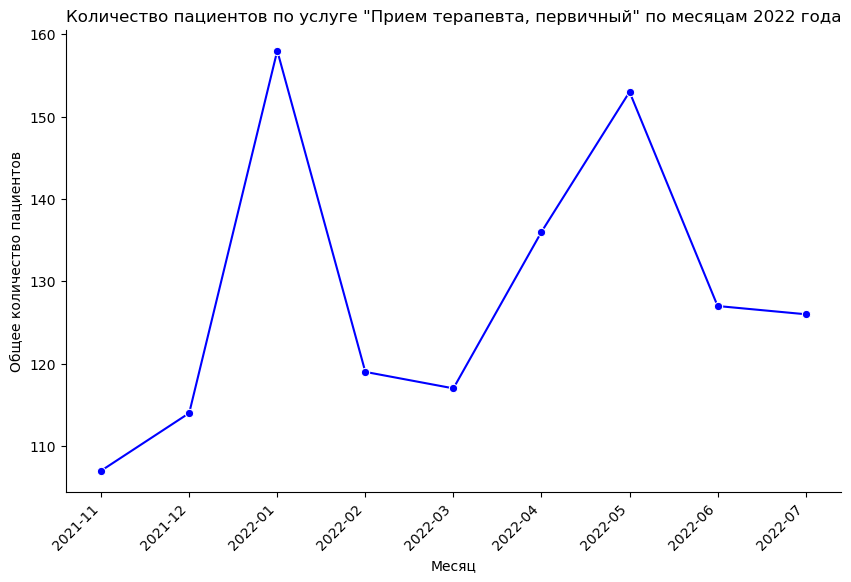

In [148]:
# Построим график распределния количества пациентов, получивших услугу "Прием тeрапевта, первичный" по месяцам 
# 2021 г.
viz_service_name("Прием тeрапевта, первичный", 2022)

In [149]:
# "Прием терапевта, повторный"
service_name_analysis(tmp_22, "Прием терапевта, повторный")

,category_age,price_for_one_service,service_date,insured
0,20-29,1380.0,2022-01-05,1
1,20-29,1380.0,2022-01-10,2
2,20-29,1380.0,2022-01-11,1
3,20-29,1380.0,2022-01-13,2
4,20-29,1380.0,2022-01-15,2
...,...,...,...,...
398,50-59,1450.0,2022-08-23,1
399,60-69,1380.0,2022-02-23,1
400,60-69,1380.0,2022-03-06,1
401,60-69,1380.0,2022-06-27,1


'Количество обращений по услуге "Прием терапевта, повторный": 580'

'Количество обращений по каждой цене:'

price_for_one_service
1380.0    468
1450.0    111
2250.0      1
Name: insured, dtype: int64

In [150]:
display(data.query('service_name == "Прием терапевта, повторный" & price_for_one_service == 2250'))

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date,category_name,category_age,service_year,service_month,price_for_one_service,season,days_between_visits,churn
74724,32801217403,2022-06-17,"Прием терапевта, повторный",2250,1,1155035,мужской,39,Прием,30-39,2022,6,2250.0,лето,0.0,0


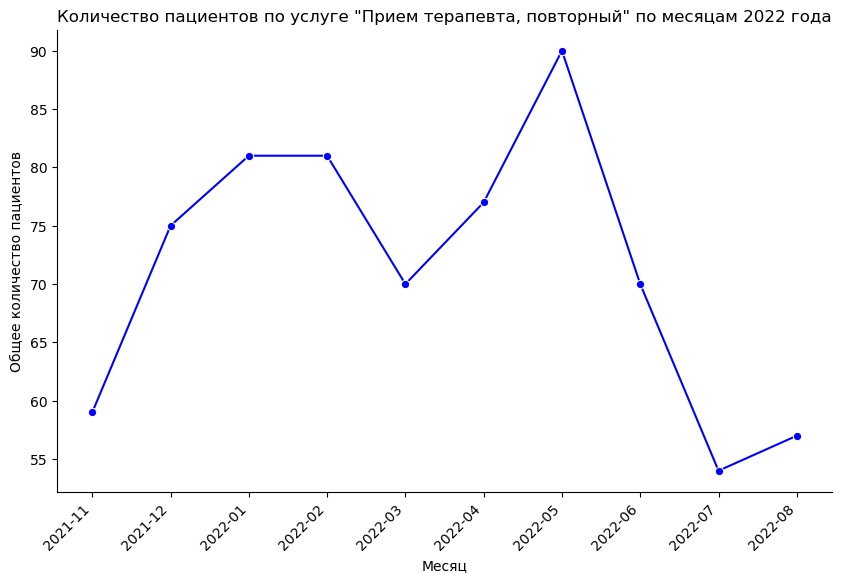

In [151]:
# Построим график распределния количества пациентов, получивших услугу "Прием терапевта, повторный" по месяцам 
# 2021 г.
viz_service_name("Прием терапевта, повторный", 2022)

Повышение цены на "Прием терапевта, первичный" и "Прием терапевта, повторный" было в июле 2022 года, к этому времени количество визитеров снижалось примерно с мая по сравнению с началом года, такая же ситуация была в 2021 году, поэтому ее могли не брать в расчет. Таким образом, определенная зависимость изменения цены из-за изменения спроса на услугу присутствует.

**Выводы:**

Третья гипотеза скорее подтверждается. Определенная зависимость есть. Изменение цены на услугу (без использования лекарственных средств) может определяться изменением спроса на нее.

<a id="14"></a>

**Четвертая гипотеза**

*Изменение цены на услуги зависит от разной стоимости за одну и ту же услугу для разных категорий пациентов.*

Нулевая гипотеза (H0): цены на одну услугу для разных категорий одинаковые.

Альтернативная гипотеза (H1): цены на одну услугу для разных категорий отличаются.

Сделаем несколько срезов данных и найдем топ 10-услуг по количеству пациентов в каждой подкатегории:
- по двум возрастным категориям, условно дети (до 18 лет) и взрослые (старше 18 лет);
- мужчины и женщины.

In [152]:
# Проверка гипотезы о том, что цены на услуги для разных возрастных категорий  одинаковые
alpha = 0.05

# Разделяем данные по возрастным категориям

# Срез по детям
data_kids = (data
             .query('age_for_service_date < 18')
             .groupby(['service_name', 'price_for_one_service', 'service_year'])
             .agg({'insured':'nunique'})
             .sort_values(by='insured', ascending=False)
             .reset_index()
             .head(10)
             .sort_values(by='service_year'))

# Сред по взрослым
data_adult = (data
              .query('age_for_service_date >= 18')
              .groupby(['service_name', 'price_for_one_service', 'service_year'])
              .agg({'insured':'nunique'})
              .sort_values(by='insured', ascending=False)
              .reset_index()
              .head(10)
              .sort_values(by='service_year'))

# Проверка равенства дисперсий
_, p_var = st.levene(data_kids['price_for_one_service'], data_adult['price_for_one_service'])
print(f'p-value для проверки равенства дисперсий: {p_var}')

if p_var < alpha:
    print('Eсть статистически значимые различия в дисперсиях между группами')
else:
    print('Нет статистически значимых различий в дисперсиях между группами')

p-value для проверки равенства дисперсий: 0.7114264954903564
Нет статистически значимых различий в дисперсиях между группами


In [153]:
# Используем t-тест с учетом равенства дисперсий
results = st.ttest_ind(data_kids['price_for_one_service'], data_adult['price_for_one_service'])
print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу о том, что цены на одну услугу для разных возрастов одинаковые')
else:
    print('Нет оснований отвергнуть нулевую гипотезу о том, что цены на одну услугу для разных возрастов одинаковые')

p-value: 0.3705782027773833
Нет оснований отвергнуть нулевую гипотезу о том, что цены на одну услугу для разных возрастов одинаковые


Проверка статистическим тестом говорит нам, что у нас нет оснований считать, что цены для детей и взрослых отличаются.

In [154]:
# Объединим данные по срезам для детей и взрослых
merged_data = data_kids.merge(data_adult, on='service_name', suffixes=('_kids', '_adult'))

# Выведем несовпадающие строки
cleaned_data1 = (merged_data
                 .query('not(price_for_one_service_kids == price_for_one_service_kids & \
                                 service_year_kids == service_year_adult)')
                 .replace({'Взятие крови из периферической вены':'Взятие крови',
                           'Общий анализ крови (лейкоцитарная формула, СОЭ)':'Общий анализ крови'}))
cleaned_data1

,service_name,price_for_one_service_kids,service_year_kids,insured_kids,price_for_one_service_adult,service_year_adult,insured_adult
5,Взятие крови,158.0,2021,117,170.0,2022,993
6,Взятие крови,170.0,2022,119,158.0,2021,808
7,Взятие крови,170.0,2022,119,170.0,2021,455
10,Общий анализ крови,693.0,2021,117,730.0,2022,895
11,Общий анализ крови,730.0,2022,112,693.0,2021,737


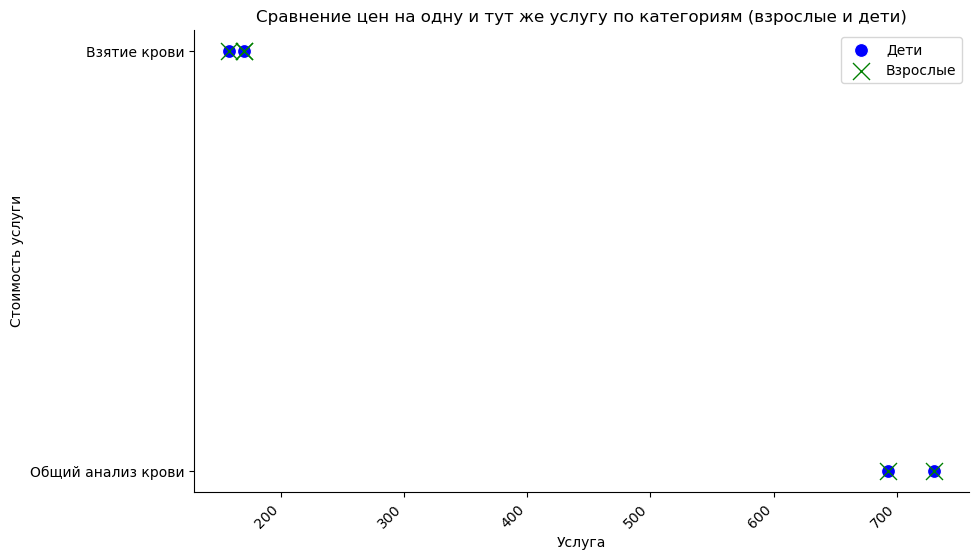

In [155]:
# Построим визуализацию
plt.figure(figsize=(10, 6))

sns.scatterplot(data=cleaned_data1, y='service_name', x='price_for_one_service_kids', label='Дети', 
                marker='o', s=100, color='blue')
sns.scatterplot(data=cleaned_data1, y='service_name', x='price_for_one_service_adult', label='Взрослые', 
                marker='x', s=150, color='green')

# Настройка подписей осей и заголовка
plt.xlabel('Услуга')
plt.ylabel('Стоимость услуги')
plt.title('Сравнение цен на одну и тут же услугу по категориям (взрослые и дети)')
plt.xticks(rotation=45, ha='right')

sns.despine()

plt.show()

Думаю, что даже если цена для взрослых и детей на одни и те же услуги менялась не в один день, но в итоге она все равно была приведена к одному значению, нет такого, чтобы аналогичный анализ крови для детей и взрослых стоил разных денег.

In [156]:
# Проверка гипотезы о том, что цены на услуги для мужчин и женщин одинаковые 
alpha = 0.05

# Разделяем данные по категориям

# Срез по мужчинам
data_male = (data
             .query('sex_id == "мужской"')
             .groupby(['service_name', 'price_for_one_service', 'service_year'])
             .agg({'insured':'nunique'})
             .sort_values(by='insured', ascending=False)
             .reset_index()
             .head(10))

# Срез по женщинам
data_female = (data
               .query('sex_id == "женский"')
               .groupby(['service_name', 'price_for_one_service', 'service_year'])
               .agg({'insured':'nunique'})
               .sort_values(by='insured', ascending=False)
               .reset_index()
               .head(10))

# Проверка равенства дисперсий
_, p_var = st.levene(data_male['price_for_one_service'], data_female['price_for_one_service'])
print(f'p-value для проверки равенства дисперсий: {p_var}')

if p_var < alpha:
    print('Eсть статистически значимые различия в дисперсиях между группами')
else:
    print('Нет статистически значимых различий в дисперсиях между группами')

p-value для проверки равенства дисперсий: 0.9836043486136737
Нет статистически значимых различий в дисперсиях между группами


In [157]:
# Используем t-тест с учетом равенства дисперсий
results1 = st.ttest_ind(data_male['price_for_one_service'], data_female['price_for_one_service'])
print(f'p-value: {results1.pvalue}')

if results1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу о том, что цены на одну услугу для мужчин и женщин одинаковые')
else:
    print('Нет оснований отвергнуть нулевую гипотезу о том, что цены на одну услугу для мужчин и женщин одинаковые')

p-value: 0.9909549142960082
Нет оснований отвергнуть нулевую гипотезу о том, что цены на одну услугу для мужчин и женщин одинаковые


Проверка статистическим тестом говорит нам, что у нас нет оснований считать, что цены мужчин и женщин отличаются.

In [158]:
# Объединим данные по срезам для мужчин и женщин
merged_data = data_male.merge(data_female, on='service_name', suffixes=('_male', '_female'))

# Выведем несовпадающие строки
cleaned_data2 = (merged_data
                 .query('not(price_for_one_service_male == price_for_one_service_female & \
                                 service_year_male == service_year_female)')
                 .replace({'Взятие крови из периферической вены':'Взятие крови',
                           'Общий анализ крови (лейкоцитарная формула, СОЭ)':'Общий анализ крови'}))
cleaned_data2

,service_name,price_for_one_service_male,service_year_male,insured_male,price_for_one_service_female,service_year_female,insured_female
3,Взятие крови,170.0,2022,449,158.0,2021,554
4,Взятие крови,158.0,2021,371,170.0,2022,663
7,Общий анализ крови,730.0,2022,424,693.0,2021,504
8,Общий анализ крови,693.0,2021,350,730.0,2022,583


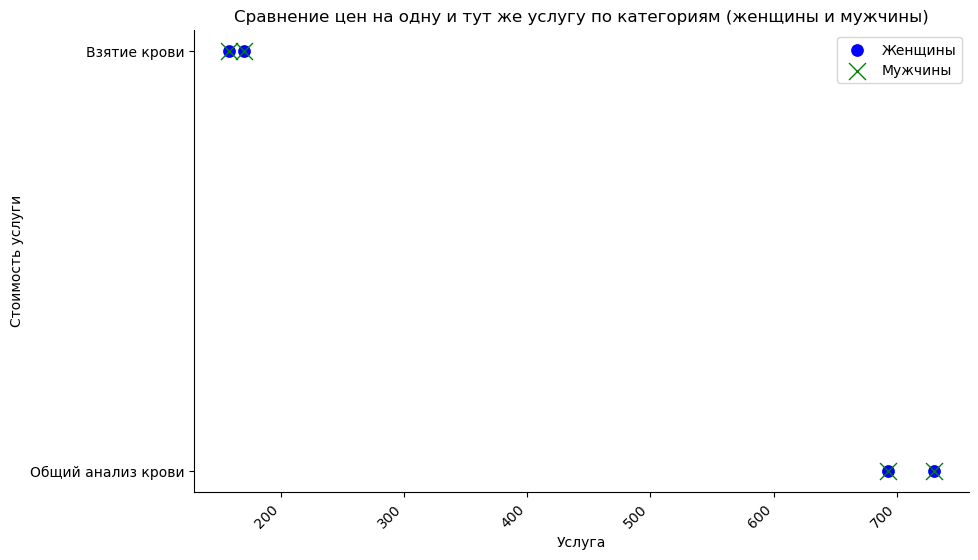

In [159]:
# Построим визуализацию

plt.figure(figsize=(10, 6))

sns.scatterplot(data=cleaned_data2, y='service_name', x='price_for_one_service_female', label='Женщины', 
                marker='o', s=100, color='blue')
sns.scatterplot(data=cleaned_data2, y='service_name', x='price_for_one_service_male', label='Мужчины', 
                marker='x', s=150, color='green')

plt.xlabel('Услуга')
plt.ylabel('Стоимость услуги')
plt.title('Сравнение цен на одну и тут же услугу по категориям (женщины и мужчины)')
plt.xticks(rotation=45, ha='right')
sns.despine()

plt.show()

Та же самая история, как с детьми и взрослыми.

**Выводы:**

Четвертая гипотеза не подтверждается. Цена на одинаковую услугу одинаковая для всех.

<a id="15"></a>

**Пятая гипотеза**

*Цена на услугу меняется в зависимости от общего количества оказанных услуг.*

Может быть есть какая-то бонусная программа для постоянных клиентов с накопительной скидкой?

In [160]:
# Найдем всех пациентов, вернувшихся в течение 2 недель после первого визита
returned_patients = (data
                     .groupby('insured')
                     .filter(lambda x: (x['service_date'].diff() <= pd.Timedelta(days=14))
                     .any())
                     .sort_values(by='service_amount', ascending=False)
                     
                     # Уберем из датасета тех, у кого дата первого визита совпадает с датой последнего
                     .groupby('insured')
                     .filter(lambda x: (x['service_date'].diff() <= pd.Timedelta(days=14))
                     .any() and (x['service_date'].min() != x['service_date'].max()))
                     .sort_values(by='service_amount', ascending=False))

In [161]:
# Сгруппируем данные по идентификационному номеру пациента
def list_aggregate(series):
    return list(series)

insured_grouped = (returned_patients
                   .groupby('insured')
                   .agg(total_services=('insured', 'count'),
                        total_cost=('service_amount', 'sum'),
                        sex=('sex_id', 'first'),
                        age=('age_for_service_date', 'first'),
                        category_name=('service_name', list_aggregate),
                        service_date=('service_date',  list_aggregate))
                   .sort_values(by='total_services', ascending = False))

In [162]:
# Посчитаем для пациентов количество дней, прошедших с первой даты визита до последней и выделим топ-10 пациентов 
# по количеству дней после первого визита
def total_days_visited(dates):
    date_diff = max(dates) - min(dates)
    return date_diff.days

insured_grouped['total_days_visited'] = insured_grouped['service_date'].apply(total_days_visited)
insured_group_top10 = insured_grouped.sort_values(by='total_days_visited', ascending = False).head(10)

# Посчитаем среднюю цену за одну услугу для этих пациентов
insured_group_top10['avg_cost'] = round(insured_group_top10['total_cost']/insured_group_top10['total_services'], 1)
insured_group_top10

,total_services,total_cost,sex,age,category_name,service_date,total_days_visited,avg_cost
insured,,,,,,,,
418193,303,361352,женский,50,"[Обзорная рентгенография (цифровая) молочных желез в прямой и косых проекциях (запись на диск), Комплексная мануальная терапия, Комплексная мануальная терапия, Комплексная мануальная терапия, Комплексная мануальная терапия, Комплексная мануальная терапия, Комплексная мануальная терапия, Дуплексн...","[2022-08-12 00:00:00, 2021-08-06 00:00:00, 2021-08-15 00:00:00, 2021-08-08 00:00:00, 2021-07-25 00:00:00, 2021-07-30 00:00:00, 2021-07-23 00:00:00, 2022-01-25 00:00:00, 2022-08-12 00:00:00, 2022-08-09 00:00:00, 2022-02-07 00:00:00, 2021-05-15 00:00:00, 2021-05-15 00:00:00, 2021-04-23 00:00:00, 2...",603,1192.6
490605,38,43908,женский,2,"[УЗИ брюшной полости, Прием психиатра, Прием офтальмолога, первичный, Прием педиатра, первичный, Прием педиатра, первичный, Прием педиатра, первичный, Прием первичный, Прием отоларинголога, первичный, Прием педиатра, первичный, Прием первичный, Прием первичный, Прием первичный, Прием первичный, ...","[2021-01-30 00:00:00, 2021-01-17 00:00:00, 2022-08-29 00:00:00, 2022-03-19 00:00:00, 2022-03-25 00:00:00, 2022-04-23 00:00:00, 2021-10-30 00:00:00, 2022-01-07 00:00:00, 2022-01-03 00:00:00, 2021-01-26 00:00:00, 2021-01-30 00:00:00, 2021-06-08 00:00:00, 2021-06-08 00:00:00, 2021-09-25 00:00:00, 2...",589,1155.5
402409,208,245609,женский,36,"[Эхокардиография с допплеровским анализом, Комплексная мануальная терапия, Комплексная мануальная терапия, Комплексная мануальная терапия, Комплексная мануальная терапия, Комплексная мануальная терапия, Комплексная мануальная терапия, Комплексная мануальная терапия, Комплексная мануальная терапи...","[2021-10-17 00:00:00, 2021-10-29 00:00:00, 2021-10-25 00:00:00, 2021-11-16 00:00:00, 2021-11-19 00:00:00, 2021-11-15 00:00:00, 2021-11-20 00:00:00, 2021-10-20 00:00:00, 2021-10-24 00:00:00, 2021-11-21 00:00:00, 2022-06-25 00:00:00, 2021-05-21 00:00:00, 2022-06-28 00:00:00, 2021-10-15 00:00:00, 2...",574,1180.8
194254,43,40253,женский,41,"[УЗИ гинекология трансвагинально с ДС сосудов, Рентгенография органов грудной клетки (2 проекции), УЗИ гинекология трансвагинально с ДС сосудов, Рентгенография органов грудной клетки (2 проекции), Прием терапевта, первичный, Прием тeрапевта, первичный, Рентгенография крупного сустава (2 снимка),...","[2021-12-02 00:00:00, 2022-07-02 00:00:00, 2021-01-11 00:00:00, 2021-04-03 00:00:00, 2022-08-04 00:00:00, 2022-07-08 00:00:00, 2021-03-11 00:00:00, 2022-04-08 00:00:00, 2021-12-16 00:00:00, 2021-03-11 00:00:00, 2021-03-26 00:00:00, 2021-08-07 00:00:00, 2021-08-05 00:00:00, 2021-04-09 00:00:00, 2...",570,936.1
490552,46,55677,мужской,6,"[Прием на дому (до МКАД), Прием на дому (до МКАД), Прием на дому (до МКАД), Прием на дому (до МКАД), Прием на дому (до МКАД), Прием педиатра, первичный, Прием педиатра, первичный, Прием отоларинголога, первичный, Прием педиатра, первичный, Прием педиатра, первичный, Прием педиатра, первичный, Пр...","[2021-04-14 00:00:00, 2021-02-21 00:00:00, 2021-02-19 00:00:00, 2021-02-16 00:00:00, 2021-04-05 00:00:00, 2022-08-30 00:00:00, 2022-07-23 00:00:00, 2022-06-17 00:00:00, 2022-06-14 00:00:00, 2022-05-20 00:00:00, 2022-03-16 00:00:00, 2021-10-15 00:00:00, 2021-06-02 00:00:00, 2021-02-13 00:00:00, 2...",563,1210.4
490912,101,76717,женский,31,"[УЗИ большие сроки беременности (II, III триместр), УЗИ большие сроки беременности (II, III триместр), УЗИ брюшной полости, Прием ведущего специалиста, УЗИ брюшной полости, Пренатальный скрининг 2 триместра (14-21 неделя), КТГ (кардиотокография) плода, Прием гастроэнтеролога, первичный, Прием пе...","[2021-04-08 00:00:00, 2021-07-01 00:00:00, 2022-08-30 00:00:00, 2021-07-22 00:00:00, 2021-07-07 00:00:00, 2021-04-09 00:00:00, 2021-07-15 00:00:00, 2022-08-23 00:00:00, 2021-06-08 00:00:00, 2021-05-11 00:00:00, 2021-07-06 00:00:00, 2022-08-30 00:00:00, 2022-08-23 00:00:00, 2021-04-14 00:00:00, 2...",556,759.6
242444,7,9464,женский,11,"[Прием педиатра

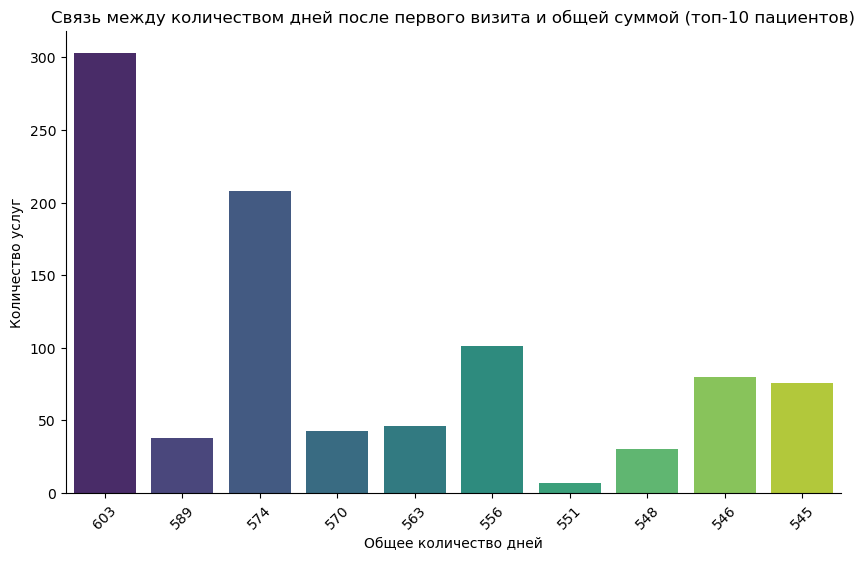

In [163]:
# Построим график зависимости между количеством дней после первого визита клиники и количества оказанных услуг 
# за это время
plt.figure(figsize=(10, 6))

sns.barplot(data=insured_group_top10, x='total_days_visited', y='total_services', palette='viridis', 
            order=insured_group_top10['total_days_visited'])

plt.xlabel('Общее количество дней')
plt.ylabel('Количество услуг')
plt.title('Связь между количеством дней после первого визита и общей суммой (топ-10 пациентов)')
plt.xticks(rotation=45)

sns.despine()

plt.show()

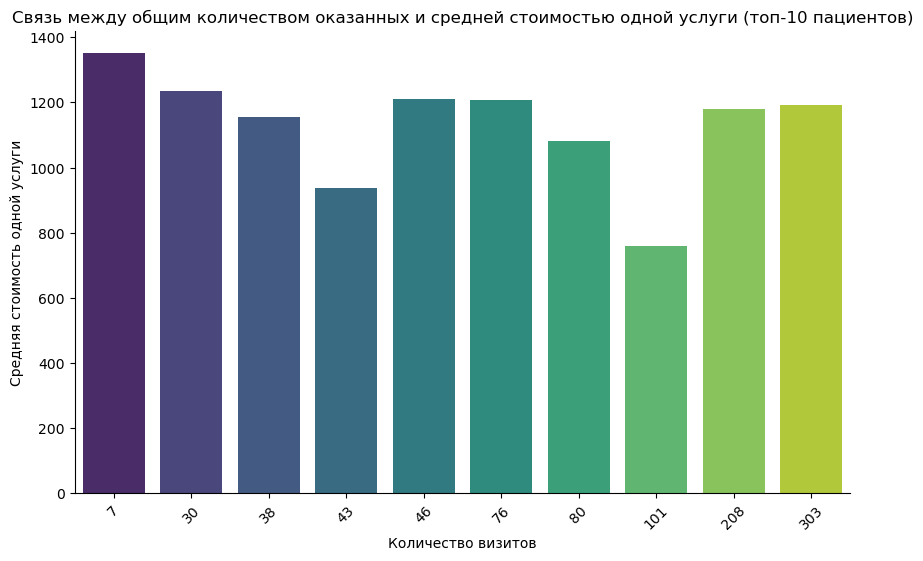

In [164]:
# Построим график зависимости общего количества оказанных услуг и средней стоимостью одной услуги

plt.figure(figsize=(10, 6))
insured_group_top10 = insured_group_top10.sort_values(by='total_services')
sns.barplot(data=insured_group_top10, x='total_services', y='avg_cost', palette='viridis')

plt.xlabel('Количество визитов')
plt.ylabel('Средняя стоимость одной услуги')
plt.title('Связь между общим количеством оказанных и средней стоимостью одной услуги (топ-10 пациентов)')
plt.xticks(rotation=45)

sns.despine()

plt.show()

Цена на лечение от общего количества оказанных услуг не зависит. Количество оказанных услуг за весь период лечения, по всей видимости, никаких бонусов не приносит. Есть пациенты, которые наблюдаются больше года, и они потратили совсем разные суммы. Количество услуг, оказанных им, у всех разное, средняя сумма при наибольшем количестве услуг была бы меньше всего, если бы была система бонусов, но в данном случае, я этого не наблюдаю.

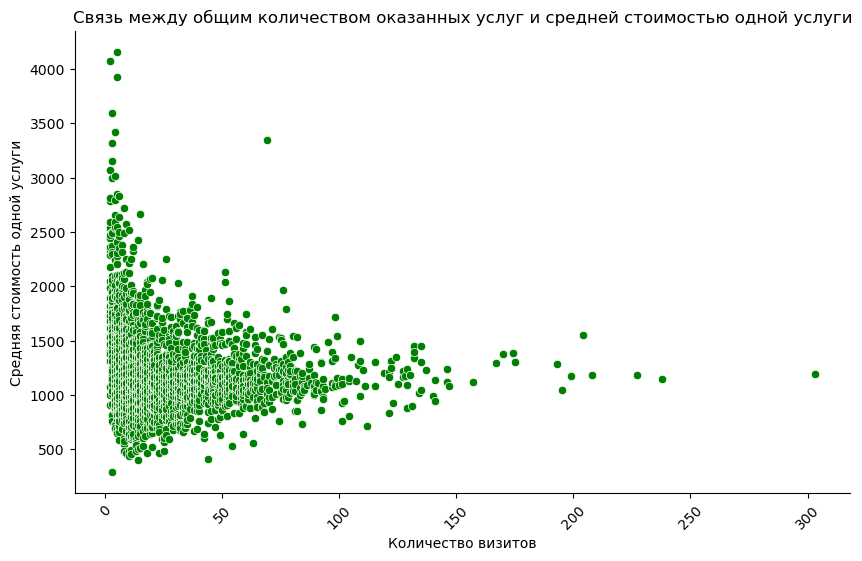

In [165]:
# Построим график зависимости средней стоимости услуги и общим количеством оказанных услуг по всем пациентам
insured_grouped['avg_cost'] = round(insured_grouped['total_cost']/insured_grouped['total_services'], 1)

plt.figure(figsize=(10, 6))
insured_grouped = insured_grouped.sort_values(by='total_services')
sns.scatterplot(data=insured_grouped, x='total_services', y='avg_cost', color='green')

plt.xlabel('Количество визитов')
plt.ylabel('Средняя стоимость одной услуги')
plt.title('Связь между общим количеством оказанных услуг и средней стоимостью одной услуги')
plt.xticks(rotation=45)

sns.despine()

plt.show()

Действительно, нет такой связи.

**Выводы:**

Гипотеза зависимости изменения цены от количества оказанных услуг не подтверждается.

<a id="16"></a>

**Шестая гипотеза**

*Цена на лечение зависит от комплексности услуги. Отдельно взятая услуга (анализы) в составе комплекса стоит дешевле, чем по отдельности.*

Попробуем рассмотреть комплексные услуги поближе. Речь скорее тут идет об комплексах анализов.

In [166]:
# Сделаем срез по категории "Анализы"
sorted(data.query('category_name=="Анализы"')['service_name'].unique())

['(1 E) Аллергопанель IgE (Молоко коровье, Молоко козье, Молоко овечье, Сыр, Творог, Сметана, Йогурт, Кефир)',
 '(2 E) Аллергопанель IgE (Пшеничная мука, Ржаная мука, Рис, Гречка, Овес, Перловка, Пшено, Ячменная крупа)',
 '(3 E) Аллергопанель IgE (Фасоль (бобы), Горох, Чечевица (смесь), Кукуруза, Дрожжи пекарские, Белок куриного яйца, Желток куриного яйца, Яйцо перепелиное)',
 '(4 E) Аллергопанель IgE (Говядина, Телятина, Свинина, Баранина, Курица, Индейка, Утка, Гусь)',
 '17-OH-гидроксипрогестерон',
 '25-OH витамин D (25-гидроксихолекальциферол)',
 'Ascaris IgG',
 'Bordetella (pertusis) IgA',
 'Bordetella (pertusis) IgG',
 'Bordetella (pertusis) IgM',
 'Bordetella pertussis (Слюна)',
 'Bordetella pertussis (Соскоб)',
 'CMV (цитомегаловирус) (Кровь)',
 'CMV (цитомегаловирус) (Слюна)',
 'CMV (цитомегаловирус) (Соскоб)',
 'Candida albicans (Соскоб)',
 'Chlamydia pneumoniae IgA',
 'Chlamydia pneumoniae IgG',
 'Chlamydia pneumoniae IgM',
 'Chlamydia trachomatis (Соскоб)',
 'Chlamydia trach

In [167]:
# Посмотрим на один из таких комплексов
data.query('service_name == "Б2 (12) Аллергопанель IgE (Таракан, Шерсть морской свинки, \
Шерсть кролика, Перхоть лошади, Перо попугая, Дафния, Вата, Латекс)"')

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date,category_name,category_age,service_year,service_month,price_for_one_service,season,days_between_visits,churn
33040,31485767303,2021-10-17,"Б2 (12) Аллергопанель IgE (Таракан, Шерсть морской свинки, Шерсть кролика, Перхоть лошади, Перо попугая, Дафния, Вата, Латекс)",1520,1,627894,женский,26,Анализы,20-29,2021,10,1520.0,осень,0.0,1


In [168]:
# Посмотрим на цену одного из компонентов комплекса
data.query('service_name == "Аллерген индивидуальный (Латекс) IgE"')

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date,category_name,category_age,service_year,service_month,price_for_one_service,season,days_between_visits,churn
41927,31814052303,2021-12-29,Аллерген индивидуальный (Латекс) IgE,1210,1,774380,женский,24,Анализы,20-29,2021,12,1210.0,зима,0.0,1
59475,32510703303,2022-04-27,Аллерген индивидуальный (Латекс) IgE,1210,1,935361,мужской,32,Анализы,30-39,2022,4,1210.0,весна,0.0,1


In [169]:
# Посмотрим на цену еще одного из компонентов комплекса
data.query('service_name == "Аллерген индивидуальный (Таракан) IgE"')

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date,category_name,category_age,service_year,service_month,price_for_one_service,season,days_between_visits,churn
21097,31111910303,2021-07-23,Аллерген индивидуальный (Таракан) IgE,1155,1,652001,женский,37,Анализы,30-39,2021,7,1155.0,лето,0.0,1
41926,31814052203,2021-12-29,Аллерген индивидуальный (Таракан) IgE,1210,1,774380,женский,24,Анализы,20-29,2021,12,1210.0,зима,0.0,1
58600,32327307503,2022-03-29,Аллерген индивидуальный (Таракан) IgE,1210,1,194239,мужской,42,Анализы,40-49,2022,3,1210.0,весна,0.0,1
59474,32510703203,2022-04-27,Аллерген индивидуальный (Таракан) IgE,1210,1,935361,мужской,32,Анализы,30-39,2022,4,1210.0,весна,0.0,1
61499,32510907403,2022-04-30,Аллерген индивидуальный (Таракан) IgE,1210,1,822662,женский,31,Анализы,30-39,2022,4,1210.0,весна,0.0,1
63525,32511112303,2022-04-27,Аллерген индивидуальный (Таракан) IgE,1210,1,935392,женский,32,Анализы,30-39,2022,4,1210.0,весна,0.0,1


In [170]:
# Сравним цены
data_test = data.query('service_name == "Б2 (12) Аллергопанель IgE (Таракан, Шерсть морской свинки, \
Шерсть кролика, Перхоть лошади, Перо попугая, Дафния, Вата, Латекс)" | \
service_name == "Аллерген индивидуальный (Таракан) IgE" ')[['service_name', 'price_for_one_service']]
            
data_test.drop_duplicates (subset=['service_name','price_for_one_service'], inplace=True)
data_test

,service_name,price_for_one_service
21097,Аллерген индивидуальный (Таракан) IgE,1155.0
33040,"Б2 (12) Аллергопанель IgE (Таракан, Шерсть морской свинки, Шерсть кролика, Перхоть лошади, Перо попугая, Дафния, Вата, Латекс)",1520.0
41926,Аллерген индивидуальный (Таракан) IgE,1210.0


Вот и доказательство. Анализ на  один аллерген  стоит 1210 рублей, а комплекс из 8ми, куда входит этот аллерген - 1520. Но при этом, комплекс выбрали 1-2 человека, а индивидуальный анализ - 6 человек. Подозреваю, что клинике выгоднее не оповещать пациентов о возможности комплексной сдачи и ее цены. Видимо основную  стоимость занимает сама процедуры взятия пробы, т.е. оплата услуг мед персонала. Посмотрим что-то еще.

In [171]:
# Изучим еще один комплекс анализов
data.query('service_name == "Гемостазиограмма (Коагулограмма: Антитромбин III, АЧТВ, МНО, \
Плазминоген, Протромбиновое время, РФМК, Тромбиновое время, Фибриноген, \
Активность факторов протромбинового комплекса % по Квику)"').groupby('service_amount')['insured'].count()

service_amount
1964    23
2060    31
2100     3
Name: insured, dtype: int64

In [172]:
data.query('service_name == "Антитромбин III"')

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date,category_name,category_age,service_year,service_month,price_for_one_service,season,days_between_visits,churn
3520,30346972603,2021-02-02,Антитромбин III,347,1,490607,женский,35,Анализы,30-39,2021,2,347.0,зима,0.0,1
12533,30786054303,2021-05-29,Антитромбин III,347,1,544852,женский,36,Анализы,30-39,2021,5,347.0,весна,0.0,1
13121,30786113103,2021-05-22,Антитромбин III,347,1,544434,женский,24,Анализы,20-29,2021,5,347.0,весна,0.0,1
18817,30961816903,2021-06-22,Антитромбин III,347,1,175058,женский,30,Анализы,30-39,2021,6,347.0,лето,0.0,1
19637,31111764203,2021-07-09,Антитромбин III,347,1,556420,женский,33,Анализы,30-39,2021,7,347.0,лето,0.0,1
19769,31111777403,2021-07-01,Антитромбин III,347,1,490912,женский,31,Анализы,30-39,2021,7,347.0,лето,0.0,1
41980,31814057703,2021-12-10,Антитромбин III,360,1,774346,мужской,49,Анализы,40-49,2021,12,360.0,зима,0.0,1
47231,31996523303,2022-01-13,Антитромбин III,360,1,774346,мужской,49,Анализы,40-49,2022,1,360.0,зима,0.0,1
56524,32327097503,2022-03-10,Антитромбин III,360,1,418185,мужской,52,Анализы,50-59,2022,3,360.0,весна,0.0,1
63716,32511132003,2022-04-25,Антитромбин III,360,1,816403,женский,32,Анализы,30-39,2022,4,360.0,весна,0.0,1


In [173]:
data.query('service_name == "Фибриноген"').groupby('service_amount')['insured'].count()

service_amount
352    14
370    32
400     5
Name: insured, dtype: int64

In [174]:
# Сравним цены
data_test1 = data.query('service_name == "Гемостазиограмма (Коагулограмма: Антитромбин III, АЧТВ, МНО, \
Плазминоген, Протромбиновое время, РФМК, Тромбиновое время, Фибриноген, Активность факторов протромбинового \
комплекса % по Квику)" | service_name == "Антитромбин III" | service_name == "Фибриноген"')\
[['service_name', 'price_for_one_service']]
data_test1.drop_duplicates (subset=['service_name','price_for_one_service'], inplace=True)
data_test1

,service_name,price_for_one_service
799,"Гемостазиограмма (Коагулограмма: Антитромбин III, АЧТВ, МНО, Плазминоген, Протромбиновое время, РФМК, Тромбиновое время, Фибриноген, Активность факторов протромбинового комплекса % по Квику)",1964.0
2772,Фибриноген,352.0
3520,Антитромбин III,347.0
32237,"Гемостазиограмма (Коагулограмма: Антитромбин III, АЧТВ, МНО, Плазминоген, Протромбиновое время, РФМК, Тромбиновое время, Фибриноген, Активность факторов протромбинового комплекса % по Квику)",2060.0
32367,Фибриноген,370.0
41980,Антитромбин III,360.0
78216,Фибриноген,400.0
78925,"Гемостазиограмма (Коагулограмма: Антитромбин III, АЧТВ, МНО, Плазминоген, Протромбиновое время, РФМК, Тромбиновое время, Фибриноген, Активность факторов протромбинового комплекса % по Квику)",2100.0


В комплексе "Гемостазиограмма" 9 позиций, если рассчитать среднюю цену за каждую позицию из расчета макимальной цены за комплекс в 2100 рублей, то сумма булет около 233 рубля, отдельные компоненты комплекса стоят стоят дороже по отдельности.

**Выводы:**

Гипотеза зависимости цены от комплексности услуги подтвердилась. Услуги в составе комплекса стоят дешевле, чем по отдельности.

<a id="17"></a>

**Седьмая гипотеза**

*Выручка клиники зависит от гендерного признака.*

Нулевая гипотеза (H0): мужчины и женщины приносят клинике одинаковую выручку.

Альтернативная гипотеза (H1): выручка от пациентов-мужчин и пациентов-женщин отличается.

In [175]:
# Проверка гипотезы о том, что прибыль, на услуги для мужчин и женщин отличаются
alpha = 0.05

# Разделяем данные по категориям

# Срез по мужчинам
data_male1 = (data
             .query('sex_id == "мужской"')
             .groupby(['service_name', 'service_amount', 'service_year'])
             .agg({'insured':'nunique'})
             .sort_values(by='insured', ascending=False)
             .reset_index())

# Срез по женщинам
data_female1 = (data
               .query('sex_id == "женский"')
               .groupby(['service_name', 'service_amount', 'service_year'])
               .agg({'insured':'nunique'})
               .sort_values(by='insured', ascending=False)
               .reset_index())

# Проверка равенства дисперсий
_, p_var = st.levene(data_male1['service_amount'], data_female1['service_amount'])
print(f'p-value для проверки равенства дисперсий: {p_var}')

if p_var < alpha:
    print('Eсть статистически значимые различия в дисперсиях между группами')
else:
    print('Нет статистически значимых различий в дисперсиях между группами')

p-value для проверки равенства дисперсий: 0.12526963926041954
Нет статистически значимых различий в дисперсиях между группами


In [176]:
# Используем t-тест с учетом равенства дисперсий
results1 = st.ttest_ind(data_male1['service_amount'], data_female1['service_amount'])
print(f'p-value: {results1.pvalue}')

if results1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу о том, что мужчины и женщины приносят клинике одинаковую выручку')
else:
    print('Нет оснований отвергнуть нулевую гипотезу о том, что мужчины и женщины приносят клинике \
одинаковую выручку')

p-value: 0.11573525834294483
Нет оснований отвергнуть нулевую гипотезу о том, что мужчины и женщины приносят клинике одинаковую выручку


Проверка статистическим тестом говорит нам, что у нас нет оснований считать, что выручка, приносимая клинике мужчинами и женщинами отличается.

In [177]:
# Посчитаем, сколько раз женщины и мужчины обращались в клинику за весь период
data_gender_cnt = data.groupby('sex_id').agg({'insured':'count'}).reset_index()

data_gender_cnt.style.background_gradient()

,sex_id,insured
0,женский,52821
1,мужской,32544


In [178]:
# Посчитаем, сколько женщин и мужчин в датасете
data_gender_unique = data.groupby('sex_id').agg({'insured':'nunique'}).reset_index()

data_gender_unique.style.background_gradient()

,sex_id,insured
0,женский,2555
1,мужской,1932


In [179]:
# Cравним средние затраты на одного мужчину и женщину по категориям
# Группируем данные по полу, категории и клиенту и считаем сумму расходов и количество услуг для каждого клиента
summary_table1 = (data
    .groupby(['sex_id','category_name','insured'])
    .agg({'service_amount':'sum','service_number':'sum'})
    .reset_index()

# Группируем данные только по полу и категории и считаем средние значения
    .groupby(['sex_id','category_name'])
    .agg({'insured':'nunique','service_amount':'mean','service_number':'mean'})
    .reset_index()
 
# Сводная таблица
    .pivot_table(index='category_name', columns='sex_id', values=['insured','service_amount','service_number']) 
 
# Подсчитаем отношение затрат мужчин к женщинам
    .assign(service_amount_share=lambda x: x['service_amount','мужской'] / x['service_amount','женский'] - 1)
)
styled_summary_table = (summary_table1
    .style
    .background_gradient(subset=pd.IndexSlice[:, :])
    .highlight_max(color='lightblue')
    .highlight_max(color='lightgreen'))

styled_summary_table

В таблице видны средние затраты по услугам на 1 мужчину и женщину, а также отношение мужских затрат к женским. Мужчины тратят больше средств на услуги из категории "Процедурный кабинет", "Физиотерапия" и другое. При чем рост по "Процедурному кабинету" существенный -  около 15%. Женщины, похоже, делают упор на плановое отслеживание состояния здоровья: приемы, анализы, инструментальные исследования и вакцинация. Сравним, как ситуация изменилась по годам.

In [180]:
# Cравним средние затраты на одного мужчину и женщину по категориям в 2021 году
# Группируем данные по полу, категории и клиенту и считаем сумму расходов и количество услуг для каждого клиента
summary_table2 = (data
    .query('service_year == 2021')
    .groupby(['sex_id','category_name','insured'])
    .agg({'service_amount':'sum','service_number':'sum'})
    .reset_index()

# Группируем данные только по полу и категории и считаем средние значения
    .groupby(['sex_id','category_name'])
    .agg({'insured':'nunique','service_amount':'mean','service_number':'mean'})
    .reset_index()
 
# Сводная таблица
    .pivot_table(index='category_name', columns='sex_id', values=['insured','service_amount','service_number']) 
 
# Подсчитаем отношение затрат мужчин к женщинам
    .assign(service_amount_share=lambda x: x['service_amount','мужской'] / x['service_amount','женский'] - 1)
)
styled_summary_table = (summary_table2
    .style
    .background_gradient(subset=pd.IndexSlice[:, :])
    .highlight_max(color='lightblue')
    .highlight_max(color='lightgreen'))

styled_summary_table

В 2021 году мужчины тратили больше денег, чем женщины на "Процедурный кабинет", "Физиотерапию" и "Хирургию". Женщины - на "Анализы", "Приемы" и "Вакцинацию".

In [181]:
# Cравним средние затраты на одного мужчину и женщину по категориям в 2022 году
# Группируем данные по полу, категории и клиенту и считаем сумму расходов и количество услуг для каждого клиента
summary_table3 = (data
    .query('service_year == 2022')
    .groupby(['sex_id','category_name','insured'])
    .agg({'service_amount':'sum','service_number':'sum'})
    .reset_index()

# Группируем данные только по полу и категории и считаем средние значения
    .groupby(['sex_id','category_name'])
    .agg({'insured':'nunique','service_amount':'mean','service_number':'mean'})
    .reset_index()
 
# Сводная таблица
    .pivot_table(index='category_name', columns='sex_id', values=['insured','service_amount','service_number']) 
 
# Подсчитаем отношение затрат мужчин к женщинам
    .assign(service_amount_share=lambda x: x['service_amount','мужской'] / x['service_amount','женский'] - 1)
)
styled_summary_table = (summary_table3
    .style
    .background_gradient(subset=pd.IndexSlice[:, :])
    .highlight_max(color='lightblue')
    .highlight_max(color='lightgreen'))

styled_summary_table

В 2022 году у мужчин на первый план по сравнению с женщинами снова вышел "Процедурный кабинет" и категория "Другое". У женщин помимо указанных ранее категорий был рекордный запрос на "Вакцинацию".  Используем для дальнейшего анализа результаты сегментации. Посмотрим на группы, которые чаще всего посещали клинику и принесли наибольший доход, например, 344 и 444.

In [182]:
# Посчитаем, сколько в общем уникальных пациентов проходили лечение в клинике за период анализа
data['insured'].nunique()

4488

In [183]:
# Используем данные RFM анализа. Посмотрим, сколько клиентов входит в перспективные сегменты 344 и 444
segment_344 = rfm_data.query('RFM == "344"')
print('Количество клиентов в сегменте 344:')
print(len(segment_344))

segment_444 = rfm_data.query('RFM == "444"')
print('Количество клиентов в сегменте 444:')
print(len(segment_444))

print('Общее количество в двух сегментах:', len(segment_344) + len(segment_444))

Количество клиентов в сегменте 344:
276
Количество клиентов в сегменте 444:
374
Общее количество в двух сегментах: 650


In [184]:
# Создадим списки с уникальными номерами застрахованнх в этих двух сегментах
insured_numbers_in_segment_344 = segment_344['insured'].tolist()
insured_numbers_in_segment_444 = segment_444['insured'].tolist()

# Объединим списки
combined_list = insured_numbers_in_segment_344 + insured_numbers_in_segment_444

# Сделаем срез по датасету для этих 650 человек
data_344_444 = data.query('insured == @combined_list')
print('Общее количество записей:', len(data))
print('Количество записей в сегментах 344 и 444:', len(data_344_444))

Общее количество записей: 85369
Количество записей в сегментах 344 и 444: 36776


Неплохо, 650 человек из 4488 обеспечили больше трети записей в клинике за анализируемый период.

In [185]:
# Посмотрим, как данная выборка разделилась по гендерному признаку
data_gender_cnt = data_344_444.groupby('sex_id').agg({'insured':'nunique'})
data_gender_cnt.style.background_gradient()

,insured
sex_id,
женский,434
мужской,216


In [186]:
# Поcчитаем общую сумму, потраченную мужчинами и женщинами из нашего сегмента на лечение
data_amount_sum = data_344_444.groupby('sex_id').agg({'service_amount':'sum'})
data_amount_sum.style.background_gradient()

,service_amount
sex_id,
женский,29020721
мужской,14388273


Женщин ровно в 2 раза больше. И потратили они практически в 2 раза больше. Посчитаем средние затраты групп.

In [187]:
# Cравним средние затраты на одного мужчину и женщину по категориям в разрезе сегментов 344 и 444
# Группируем данные по полу, категории и клиенту и считаем сумму расходов и количество услуг для каждого клиента
summary_table4 =(data_344_444
    .groupby(['sex_id','category_name','insured'])
    .agg({'service_amount':'sum','service_number':'sum'})
    .reset_index()

# Группируем данные только по полу и категории и считаем средние значения
    .groupby(['sex_id','category_name'])
    .agg({'insured':'nunique','service_amount':'mean','service_number':'mean'})
    .reset_index()
 
# Сводная таблица
    .pivot_table(index='category_name', columns='sex_id', values=['insured','service_amount','service_number']) 
 
# Подсчитаем отношение затрат мужчин к женщинам
    .assign(service_amount_share=lambda x: x['service_amount','мужской'] / x['service_amount','женский'] - 1)
)
styled_summary_table = (summary_table4
    .style
    .background_gradient(subset=pd.IndexSlice[:, :])
    .highlight_max(color='lightblue')
    .highlight_max(color='lightgreen'))

styled_summary_table

In [188]:
# Посмотрим на средние затраты в целом
data_avg_amount = round(data_344_444.groupby('sex_id').agg({'service_amount':'mean'}), 1)
data_avg_amount.style.background_gradient()

,service_amount
sex_id,
женский,1180.700000
мужской,1179.700000


Что тут можно сказать...Если по категориям затраты мужчин и женщин различаются, то в целом женщины из наших сегментов потратили примерно на 1 рубль больше мужчин.

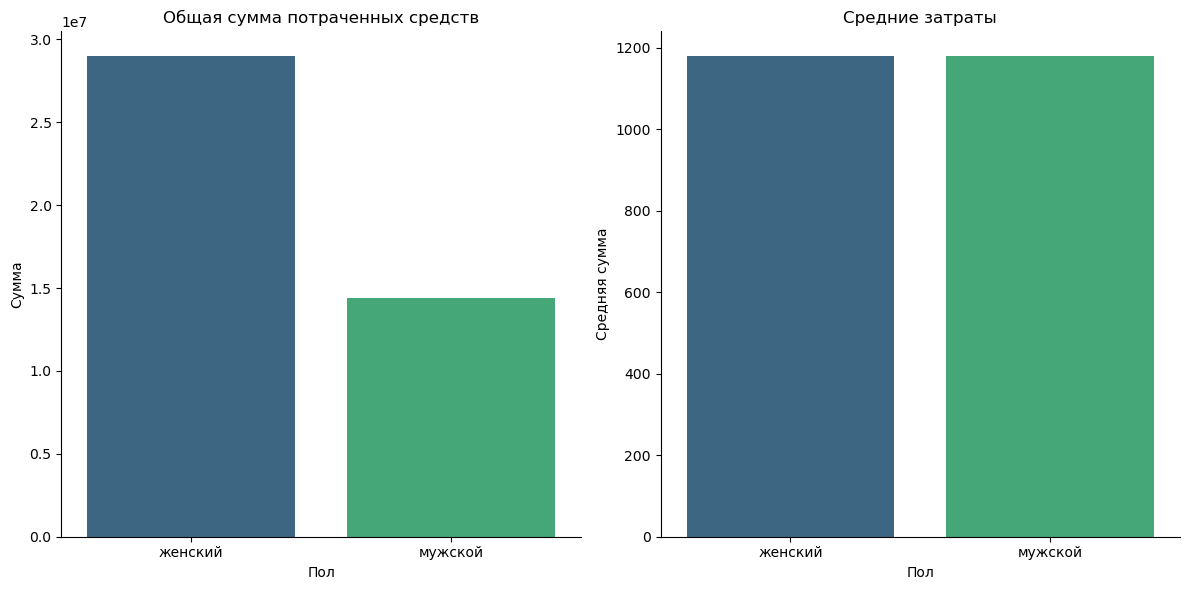

In [189]:
# Визуализируем результат
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# График суммы потраченных средств по полу
sns.barplot(x=data_amount_sum.index, y='service_amount', data=data_amount_sum, ax=axes[0], palette='viridis')
axes[0].set_title('Общая сумма потраченных средств')
axes[0].set_xlabel('Пол')
axes[0].set_ylabel('Сумма')

# График средних затрат по полу
sns.barplot(x=data_avg_amount.index, y='service_amount', data=data_avg_amount, ax=axes[1], palette='viridis')
axes[1].set_title('Средние затраты')
axes[1].set_xlabel('Пол')
axes[1].set_ylabel('Средняя сумма')

plt.tight_layout()
sns.despine()

plt.show()

**Выводы:**

Седьмая гипотеза подтверждается. Выручка клиники зависит от гендерного признака в том смысле, что пациенток-женщин больше, чем пациентов-мужчин, и почти 2/3 обращений в клинику поступает именно от женщин. По приносимой выручке на человека различия между тратами мужчин и женщин минимальны.

<a id="18"></a>

**Восьмая гипотеза**

*Выручка клиники зависит от возрастных категорий.*

In [190]:
# Посчитаем численность каждой возрастной категории
data_age_cat = data.groupby('category_age').agg({'insured':'nunique'}).\
                    sort_values(by='insured', ascending = False).reset_index()

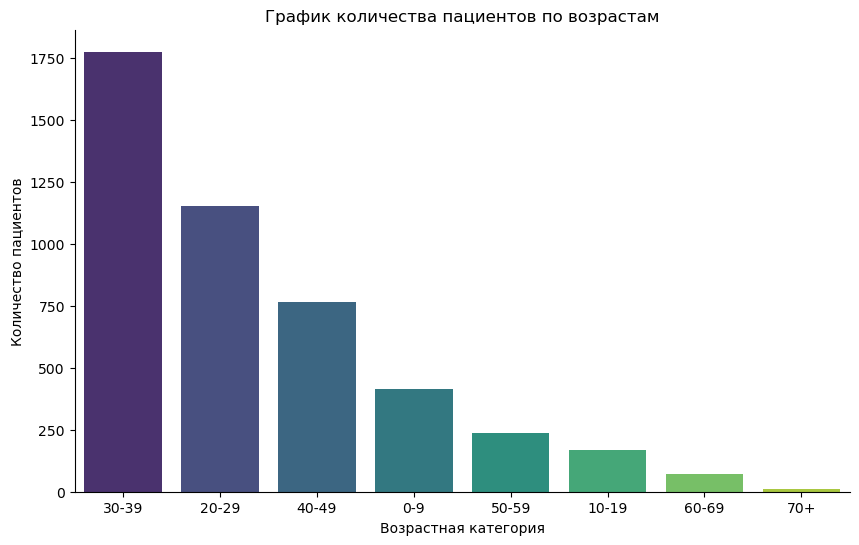

In [191]:
# Построим график численности пациентов по возрастам
data_age_cat_melted = pd.melt(data_age_cat, id_vars=['category_age'], value_vars=['insured'])

plt.figure(figsize=(10, 6))

# Строим график
ax = sns.barplot(x='category_age', y='value', data=data_age_cat_melted, palette='viridis')

plt.xlabel('Возрастная категория')
plt.ylabel('Количество пациентов')
plt.title('График количества пациентов по возрастам')

sns.despine()

plt.show()

In [192]:
# Cравним средние затраты на одного пациента по категориям
# Группируем данные по возрасту, категории и клиенту и считаем сумму расходов и количество услуг для каждого 
# клиента
summary_table5 = (data
# Группируем данные только по возрасту и категории и считаем средние значения
    .groupby(['category_age','category_name'])
    .agg({'service_amount':'mean'})
    .reset_index()
 
# Сводная таблица
    .pivot_table(index='category_name', columns='category_age', 
              values=['service_amount'])
    .T
 # Заполним пропуски нулями
    .fillna(0) 
 # Подсчитаем сумм затрат по возрастам
    .assign(service_amount_sum=lambda x: x.sum(axis=1))
)
styled_summary_table = (summary_table5
    .style
    .background_gradient(subset=pd.IndexSlice[:, :])
    .highlight_max(color='lightblue')
    .highlight_max(color='lightgreen'))

styled_summary_table

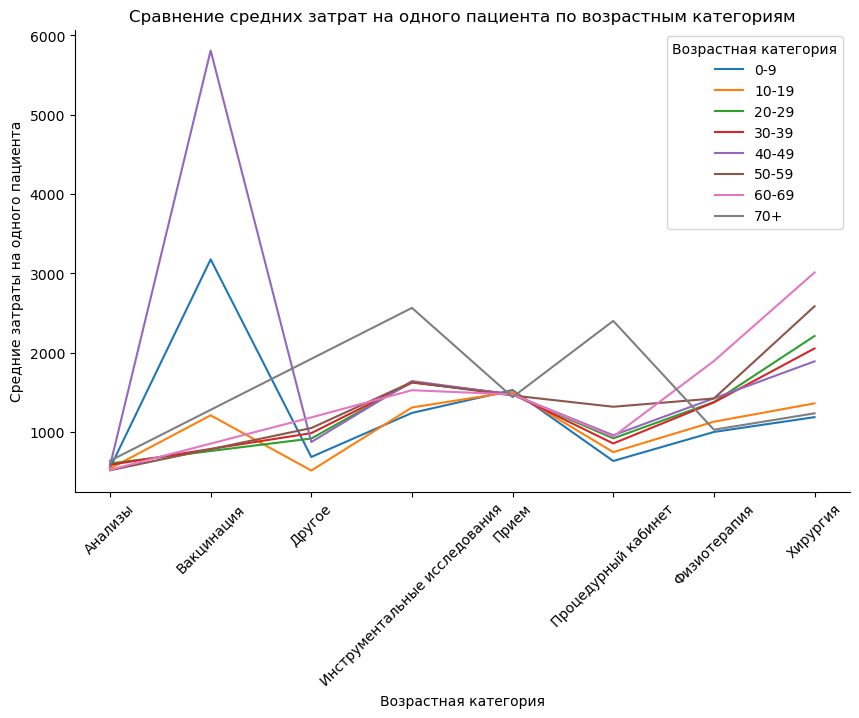

In [193]:
# Визуализируем данные
data_avg = (data
            .groupby(['category_age', 'category_name'])
            .agg({'service_amount':'mean'})
            .reset_index())

plt.figure(figsize=(10, 6))
sns.lineplot(data=data_avg, x='category_name', y='service_amount', hue='category_age')
plt.title('Сравнение средних затрат на одного пациента по возрастным категориям')
plt.xlabel('Возрастная категория')
plt.ylabel('Средние затраты на одного пациента')
plt.xticks(rotation=45)
plt.legend(title='Возрастная категория')

sns.despine()

plt.show()

Итак, максимальную прибыль клинике приносят пациенты после 40 лет и дети. На первом месте: 40-49ти летние, на втором: 70+, на третьем: дети до 9 лет включительно. 

**Выводы:**

Восьмая гипотеза подтверждается. Выручка клиники зависит от возраста пациентов.

<a id="19"></a>

**Девятая гипотеза**

*Сезонность влияет на прибыльность бизнеса.*

Нулевая гипотеза (H0): выручка в разные сезоны одинаковая.

Альтернативная гипотеза (H1): выручка в разные сезоны разная.

Поскольку у нас в 2022 году нет данных за осень и часть зимы, разобьем датасет на выборки по двум противоположным сезонам: на зиму и лето, будем учитывать также, что в 2022 году нет данных за декабрь, т.е. выборки будут с неравной дисперсией. 

In [194]:
# Проверка гипотезы о том, что выручка в разные сезоны отличается
alpha = 0.05

# Разделяем данные по категориям

# Срез по зимнему сезону
data_winter = (data
             .query('season == "зима"')
             .groupby(['service_name', 'service_amount', 'service_year'])
             .agg({'insured':'nunique'})
             .sort_values(by='insured', ascending=False)
             .reset_index())

# Срез по летнему сезону
data_summer = (data
               .query('season == "лето"')
               .groupby(['service_name', 'service_amount', 'service_year'])
               .agg({'insured':'nunique'})
               .sort_values(by='insured', ascending=False)
               .reset_index())

# Проверка равенства дисперсий
_, p_var = st.levene(data_winter['service_amount'], data_summer['service_amount'])
print(f'p-value для проверки равенства дисперсий: {p_var}')

if p_var < alpha:
    print('Eсть статистически значимые различия в дисперсиях между группами')
else:
    print('Нет статистически значимых различий в дисперсиях между группами')

p-value для проверки равенства дисперсий: 5.698005696988954e-05
Eсть статистически значимые различия в дисперсиях между группами


In [195]:
# Используем t-тест с учетом неравенства дисперсий
results1 = st.ttest_ind(data_winter['service_amount'], data_summer['service_amount'], equal_var=False)
print(f'p-value: {results1.pvalue}')

if results1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу о том, что выручка в разные сезоны одинаковая')
else:
    print('Нет оснований отвергнуть нулевую гипотезу о том, что выручка в разные сезоны одинаковая')

p-value: 1.9010957202568015e-05
Отвергаем нулевую гипотезу о том, что выручка в разные сезоны одинаковая


Результаты статистического теста показывают, что мы может отвергнуть гипотезу о равенстве выручки в рaзные сезоны. Посмотрим, как она менялась.

In [196]:
# Посчитаем выручку по сезонам в 2021 году
data_season_21 = data.query('service_year == 2021').groupby('season').agg({'service_amount':'sum'})

In [197]:
# Посчитаем выручку по сезонам в 2022 году
data_season_22 = data.query('service_year == 2022').groupby('season').agg({'service_amount':'sum'})

In [198]:
# Объединим данные
data_season = (data_season_21
               .merge(data_season_22, on='season', how='left')
               .reset_index()
               .fillna(value=0)
               .rename(columns={'season':'season', 'service_amount_x':'2021', 'service_amount_y':'2022'})
               .sort_values(by='2021'))

data_season.style

,season,2021,2022
1,зима,9655406,10098555.000000
0,весна,12606713,22074250.000000
2,лето,12705783,16813857.000000
3,осень,15593769,0.000000


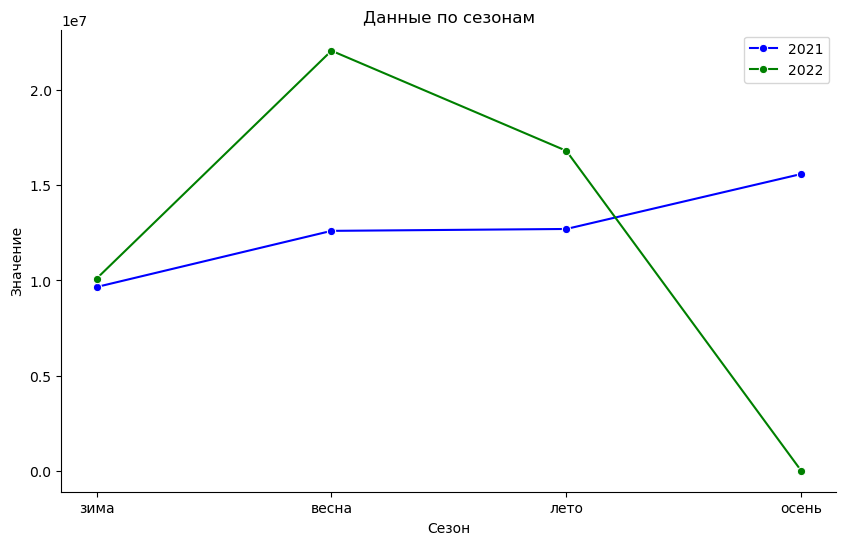

In [199]:
# Построим график изменения выручки по сезонам в разные годы
plt.figure(figsize=(10, 6))

# Строим графики для каждого года
sns.lineplot(data=data_season, x='season', y='2021', label='2021', marker='o',
             linestyle='-', color='blue')
sns.lineplot(data=data_season, x='season', y='2022', label='2022', marker='o',
             linestyle='-', color='green')

plt.title('Данные по сезонам')
plt.xlabel('Сезон')
plt.ylabel('Значение')
plt.legend()
plt.grid(False)

sns.despine()

plt.show()

**Выводы:**

По 2021 году хорошо видна зависимость выручки от сезона. Зимой и осенью - сезоны повышения заболеваемости, летом почти без подъема после весны. Начало 2022 года имеет такую же тенденцию, но уже с более высокой выручкой после поднятия цен в октябре 2021 и притоком пациентов. Но к лету тенденция меняется, наблюдается сильное падение выручки из-за оттока пациентов. Данных за осень и часть зимы у нас нет, поэтому мы не может сказать выровнялась ли ситуация. Считаю, что гипотеза про сезонность подтвердилась, но в 2022 году приходится делать скидку на внешние факторы, политическую и экономическую обстановку.

<a id="20"></a>

### Общий вывод

Мы провели исследование данных медицинской клиники за период с 3 января 2021 года по 31 августа 2022 года с целью выявить ключевые драйверы изменения цены на лечение и прибыльность бизнеса.

***Исследование состояло из следующих этапов:***

- ***Загрузка и предобработка данных:***
  - Прочитали файл с данными;
  - Вывели и изучили общую информацию о нем;
  - Минимальная дата в датасете: 2021-01-03;
  - Максимальная дата в датасете: 2022-08-31.
  - Преобразовали тип данных в стобце service_date во временной формат;
  - Данные в стобцах были проверены на пропуски, в столбце sex_id было найдено 21 пропущенное значение, 17 из них удалось дозаполнить, сравнив данные по столбцу insured
  - Преобразовали уникальные значения столбца sex_id в "мужской" и "женский"
  - Проверили данные на дубликаты - явных дубликатов нет;
  - Заменили 3 неявных дубликата в столбце service_name;
  - Изучили уникальные значения в стобцах;
  - Исправлены опечатки, убраны лишние пробелы, запятые, скобки и добавлены недостающие, данные приведены к условно однинаковой стилистике в столбце service_name, благодаря чему количество уникальных значений в столбце сократилось с 875 до 861.

- ***Добавление новых признаков:***
  - category_name содержит категории: Анализы, Инструментальные исследования, Физиотерапия, Вакцинация, Процедурный кабинет, Хирургия, Прием, Другое;
  - category_age содержит данные по возрастным катгориям: 0-9, 10-19, 20-29, 30-39, 40-49, 40-59, 60-69, 70+;
  - service_year содержит год посещения клиники;
  - service_month содержит месяц посещения клиники;
  - price_for_one_service содержит среднюю стоимость одной услуги в течении дня;
  - season содержит данные по сезонности: зима, весна, лето, осень;
  - churn содержит данные об оттоке клиентов: 0-остались, 1- ушли.

- ***Исследовательский анализ данных:***
  - Рассчитали изменение прибыли в 2022 году по сравнению с 2021 годом:
    - Выручка за 8 месяцев 2022 года на 19 млн. рублей больше выручки за аналогичные месяцы 2021 года;
    - Прибыль за последние 4 месяца 2021 года составляет 40.8% от общегодовой прибыли за этот год. Причины этого попробуем определить в дальнейшем исследовании;
    - Цены на популярные услуги выросли в октябре 2021 года и в июле 2022 года.
  - Рассчитали средние чеки по категориям и по дням:
    - Самые высокие средние чеки в категории "Вакцинация", "Хирургия", "Другое", "Инструментальные исследования";
    - В 2022 году средний чек по дате вырос и стартует от, примерно, 950 р., в отличие от 800 р. в 2021 году.
  - Рассчитали продуктовые метрики MAU, CRR, Churn rate, ARPU:
    - MAU: в 2021 году число уникальных посетителей ежемесячно плавно растет с незначительными откатами в июне и ноябре, в 2022 же году количество уникальных пациентов уменьшается примерно с мая;
    - CRR: у клиентов, которые пришли в клинику в 2021 году удержание в первые недели выше;
    - Churn rate: отток в 2022 году был в целом выше, чем в 2021. В феврале и декабре 2021 отток был наименьшим, в мае и августе 2022 - самым высоким;
    - ARPU: до мая каждого года выручка с клиента растет симметрично по обоим годам, в 2021 году выручка с одного клиента максимальная в июне, затем резко падает и снова уходит в пике только к октябрю. В 2022 году выручка начинает расти как раз с июня.

- ***Сегментация пользователей:*** 
  - Сегментировали пользователей посредством RFM анализа.

- ***Формирование гипотез:*** 
  - ##### Первая гипотеза. 
    <span style="color:purple">*Цены не изменились в 2022 году по сравнению с 2021 годом.*</span>

    <span style="color:red">Гипотеза не подтверждается.</span> Цены изменились дважды на анализируемый период. Изменение цен на востребованные услуги было в октябре 2021 года и в июле 2022 года. Цены были подняты на ряд услуг практически по всем категориям, кроме "Хирургии", "Физиотерапии" и "Другое" на 55.8% наименований услуг.
        
  - ##### Вторая гипотеза. 
    <span style="color:purple">*Изменение цены в 2022 году по сравнению с 2021 годом зависит от увеличения количества пациентов.*</span>
  
    <span style="color:green">Гипотеза подтверждается.</span> Изменение (поднятие цен) может быть связано с увеличением притока новых пациентов. Поток пациентов увеличивался в течение всего времени до лета 2022 года. Затем началось снижение, не совcем понятно поднятие цен в июле 2022 года, но бизнес мог просто не успеть среагировать на снижение количества пациентов, или воспринять его как системное явление, так как летом 2021 года была похожая ситуация. Что было в перспективе нескольких месяцев после подъема цен мы не знаем, данных нет.
    
  - ##### Третья гипотеза.
    <span style="color:purple">*Цены на лечение меняются в зависимости от колебания спроса на услугу.*</span>
    
    <span style="color:blue">Гипотеза подтверждается частично.</span> Определенная зависимость есть. Повышение цены на услугу (без использования лекарственных средств) может определяться изменением спроса на нее. Для утверждения, что спрос на услугу влияет на понижение цены, недостаточно данных для анализа.
    
  - ##### Четвертая гипотеза.
    <span style="color:purple">*Изменение цены на услуги зависит от разной стоимости за одну и ту же услугу для разных категорий пациентов.*</span>
    
    <span style="color:red">Гипотеза не подтверждается.</span> Цена на одинаковую услугу одинаковая для всех, для детей и взрослых, для мужчин и женщин.
    
  - ##### Пятая гипотеза.
    <span style="color:purple">*Цена на услугу меняется в зависимости от общего количества оказанных услуг.*</span>
    
    <span style="color:red">Гипотеза не подтверждается.</span> Гипотеза зависимости изменения цены от количества оказанных услуг не подтверждается. Большое количество оказанных услуг не ведет за собой снижение стоимости на них.
    
  - ##### Шестая гипотеза.
     <span style="color:purple">*Цена на лечение зависит от комплексности услуги. Отдельно взятая услуга (анализы) в составе комплекса стоит дешевле, чем по отдельности.*</span>
    
    <span style="color:green">Гипотеза подтверждается.</span> Услуги в составе комплекса стоят дешевле, чем по отдельности.
    
  - ##### Седьмая гипотеза.
    <span style="color:purple">*Выручка клиники зависит от гендерного признака.*</span>
    
    <span style="color:green">Гипотеза подтверждается.</span> Выручка клиники зависит от гендерного признака в том смысле, что пациенток-женщин больше, чем пациентов-мужчин, и почти 2/3 обращений в клинику поступает именно от женщин.
    
  - ##### Восьмая гипотеза.
    <span style="color:purple">*Выручка клиники зависит от возрастных категорий.*</span>
    
    <span style="color:green">Гипотеза подтверждается.</span> Максимальную выручку клинике приносят пациенты после 40 лет и дети. На первом месте: 40-49ти летние, на втором: 70+ летние, на третьем: дети до 9 лет включительно.
    
  - ##### Девятая гипотеза.
    <span style="color:purple">*Сезонность влияет на прибыльность бизнеса.*</span>
    
    <span style="color:green">Гипотеза подтверждается.</span> По 2021 году хорошо видна зависимость выручки от сезона. Зимой и осенью - сезоны повышения заболеваемости, летом почти без подъема после весны. Начало 2022 года имеет такую же тенденцию, но уже с более высокой выручкой после поднятия цен в октябре 2021 и притоком пациентов. Во второй половине 2022 года необходимо учесть экономические и политические обстоятельства.   
    
- ***Вывод:*** 
  - Драйверы изменения цены лечения:
    - Рост потока пациентов приводит к росту цен на услуги;
    - Спрос на услугу также приводит к росту цены на нее;
    - Комплексность услуги (анализа) может обеспечить более низкую цену на подкатегорию услуги.
  - Драйверы изменения выручки клиники:
    - Женщины - более частые клиенты, приносят большую выручку;
    - Люди определенного возраста также приносят большую выручку. В их число входят дети до 9 лет и взрослые после 40 лет;
    - Сезонность. В зимний сезон выручка выше.

- ***Рекомендации:*** 
  - Учитывать сезонность, летом и весной проводить различные акции, например, диспансеризация по привлекательной цене, чтобы привлечь поток пациентов;
  - Учитывать возрастные категории, сделать ниже цену для детей и пенсионеров для удержания данной категории пациентов, запустить различные маркетинговые акции для привлечения пациентвов 20-40 летнего возраста;
  - Учитывать пол. Женщины больше заботятся о своем здоровье, возможно, стоит ввести пакет услуг “Семейный”, чтобы простимулировать женщин записывать на прием своих детей и родственников мужского пола.

- ***Презентация:*** 
  - https://1drv.ms/p/c/6fce2725f38b83eb/Eboq_NYZhYxHrNHvGtBsODUBMGsrbYogj8rzRMGfScvoCQ?e=Jsy38c